# Wine Price Regression
- 와인의 가격을 예측해보자!
- With wine-review dataset
    - Source by https://www.kaggle.com/zynicide/wine-reviews/
    - This dataset was crawled from https://www.winemag.com/?s=&drink_type=wine

## Index
1. Introduction  
   -  1.1. The background of the selection  
   -  1.2. About dataset
1. EDA & data preprocessing 
   - 2.1. Import
   - 2.2. Missing value(NaN)
   - 2.3. Feature analysis & engineering
       - 2.3.1. Continuous features
           - Price
           - Points
       - 2.3.2 Categorical features
           - country
           - province
           - region_1
           - region_2
           - designation
           - winery
           - variety
           - taster_name
           - taster_twitter_handle
           - title
                - vintage
           - description
   - 2.4. Feature selection
       - 3.1.1. L1 regularization
1. Modeling  
    - 3.1. Target encoding
    - 3.2. Baseline: Linear Regression
    - 3.3. Evaluation & Diagnosis
    - 3.4. Ensemble Model: GBDT regressor
4. Review

---

# Introduction

## The background of the selection
- 저는 고등학교 때부터 커피에 관심이 많았던 커피매니아 였습니다. 그래서 커피에 관한 프로젝트를 해보고 싶었지만 아쉽게도 적절한 데이터를 찾아내지 못했습니다.
- 대신 커피와 유사한 성격의 음료인 와인에 관한 데이터들은 많이 발견할 수 있었습니다. 따라서 와인에 대한 데이터를 이용해서 프로젝트를 진행해 보는 것도 재미있겠다고 생각하여 이번 프로젝트 주제로 선정했습니다.
- Not Kaggle competetion
    - 실무에서는 공부를 위한 예제로 쓰는 데이터처럼 모든 데이터가 깔끔하게 잘 들어가 있는 경우가 거의 없다고 들었습니다. 따라서 누락 데이터가 상당부분 존재하는 데이터를 다루면서 전처리와 feature engineering 작업에 대한 고민을 거쳐볼 필요가 있다고 생각했습니다.
    - 지금까지는 대부분 Kaggle competetion 데이터를 바탕으로 한 문제에 대한 정의가 이미 되어있는 프로젝트를 진행해왔습니다. 이번에는 제가 좋아하는 주제의 데이터를 가지고 스스로 문제를 정의하고 결과를 분석해보는 프로젝트를 진행해보고 싶습니다.

## About dataset

### Features of Dataset

- `country`: 와인이 생산된 국가
- `description`: 와인에 대한 테이스트 평가 노트
- `designation`: 포도가 재배된 포도원(Vineyard)
- `points`: WineEnthusiast가 와인을 80 ~ 100 점 척도로 평가 한 점수
- `price`: 와인 한 병의 가격
- `province`: 와인이 생산된 지역(주)
- `region`: 와인이 생산된 province의 구역
- `winery`: 와인이 만들어지는 양조장
- `taster_name`: 'Wine Enthusiast'의 editor이자 와인을 시음하고 리뷰한 테이스터의 이름
- `taster_twitter_handle`: 위 테이스터의 twitter id
- `title`: 리뷰된 와인의 이름
- `variety`: 와인을 만드는데 사용된 포도의 종류(품종)


### From 'Wine Enthusiast Companies'
- https://www.winemag.com/about-us/

열정적인 와인 라이프 스타일을 추구하는 Wine Enthusiast Companies사의 와인 리뷰 사이트에서 수집된 데이터입니다. 테이스팅 노트를 기록한 리뷰(`description`)는 와인의 생산자나 가격에 대한 정보가 없는 상태에서 작성된다고 합니다(단, 와인의 빈티지와 품종, 포도가 재배된 지역에 관한 정보는 알 수 있습니다). 점수(`score`)는 80점 ~ 100점 사이에서 매겨집니다.

![information](./data/information_about_data.png)

# EDA & data preprocessing 

## Import

#### Package

In [1]:
#Math imports
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import normaltest


#Visualization Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Modeling Imports
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import lightgbm as lgb
import category_encoders as ce
from patsy import *


#Text Processing Imports
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag


#etc
from copy import deepcopy
import missingno as msno
from sklearn.externals import joblib
import warnings
warnings.filterwarnings(action='ignore') 

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


#### Dataset

In [2]:
IDIR = "./data/"
df = pd.read_csv(IDIR + "winemag-data-130k-v2.csv", index_col=0)

#### Pandas option

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)

---

### Remove duplicate values

사전에 중복된 record가 존재한다는 것을 확인했기 때문에 이를 제거하는 작업을 하겠습니다.
- 9,983개의 중복 데이터를 제거

In [4]:
df = df.drop_duplicates()
df.shape

(119988, 13)

총 119,988개의 row, 13개의 column을 지니고 있는 데이터셋 입니다.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
country                  119929 non-null object
description              119988 non-null object
designation              85443 non-null object
points                   119988 non-null int64
price                    111593 non-null float64
province                 119929 non-null object
region_1                 100428 non-null object
region_2                 46769 non-null object
taster_name              95071 non-null object
taster_twitter_handle    90542 non-null object
title                    119988 non-null object
variety                  119987 non-null object
winery                   119988 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB


## Missing value(`NaN`)
- 누락된 데이터의 비율을 알아봅니다.

In [6]:
def missing_value(input_df, column='all'):
    if column == 'all':
        nan = input_df.isnull().sum().sort_values(ascending = False)
        rate = round(nan / input_df.shape[0] * 100, 2)
        nan_rate = pd.DataFrame([nan, rate], index=['NaN count', 'NaN rate']).T
        print("Shape of Dataset:", input_df.shape)
        return nan_rate
    else:
        nan = input_df[column].isnull().sum()
        rate = round(nan / input_df.shape[0] * 100, 2)
        print("Shape of Dataset:", input_df.shape)
        print('Missing value of', column)
        print('NaN count' + '\t', nan)
        print('NaN rate' + '\t', str(rate) + '%')

In [7]:
missing_value(df)

Shape of Dataset: (119988, 13)


NaN count  NaN rate
region_2               73219.0    61.02   
designation            34545.0    28.79   
taster_twitter_handle  29446.0    24.54   
taster_name            24917.0    20.77   
region_1               19560.0    16.30   
price                  8395.0     7.00    
province               59.0       0.05    
country                59.0       0.05    
variety                1.0        0.00    
winery                 0.0        0.00    
title                  0.0        0.00    
points                 0.0        0.00    
description            0.0        0.00

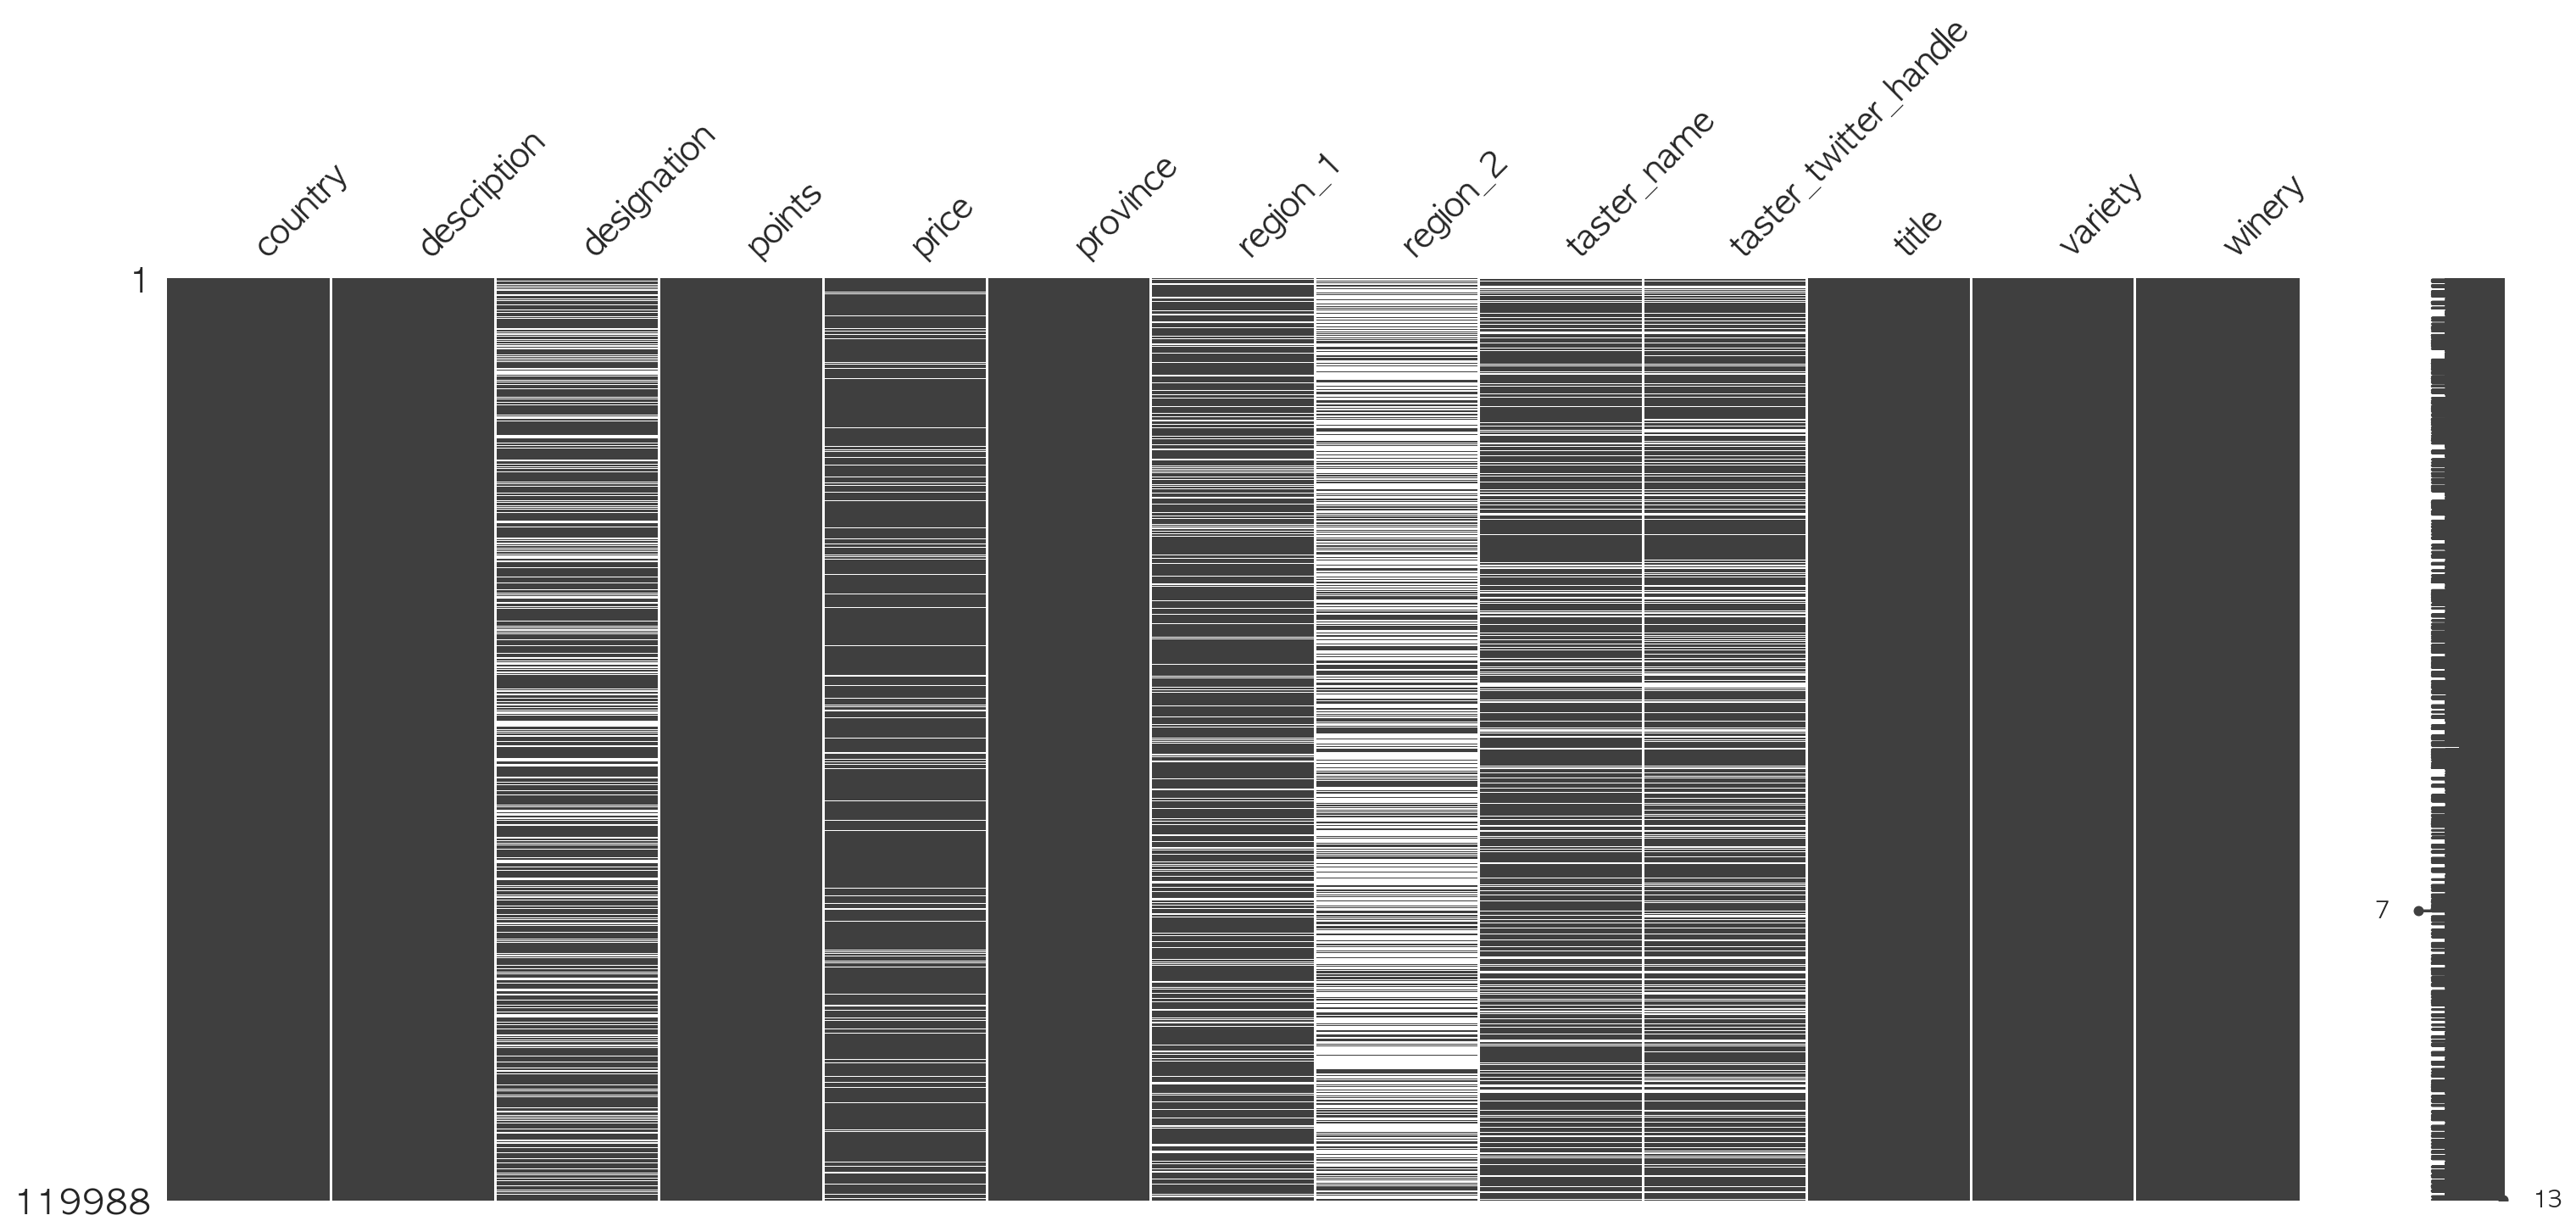

In [8]:
msno.matrix(df, fontsize=20)
plt.show()

위 그래프의 하얀 영역은 데이터가 누락된 부분을 의미합니다. 시각화 결과 상당 부분 누락데이터가 관측되는 데이터라는 사실을 알 수 있습니다. `NaN` 값에 대한 적절한 조치가 필요해 보입니다.

In [9]:
clean_df = df.dropna(axis=0)
print("Number of data with no missing values:", clean_df.shape[0])

del clean_df

Number of data with no missing values: 20493


누락된 feature값이 전혀 없는 완벽한 데이터는 20,493개로, 전체 데이터의 20%도 되지 않습니다. 이 데이터만으로 프로젝트를 진행하는 것은 정보가 지나치게 손실되는 문제가 있으므로, 누락 데이터 처리를 항상 염두에 두면서 전처리 작업을 진행해야 합니다.

## Feature analysis & engineering

### Continuous feature

연속형 데이터는 `points`, `price` 두 가지가 있습니다. `points`의 경우 최소값 80과 최대값 100 사이의 분포를 보입니다.

In [10]:
df.describe()

points          price
count  119988.000000  111593.000000
mean   88.442236      35.620747    
std    3.092915       42.103728    
min    80.000000      4.000000     
25%    86.000000      17.000000    
50%    88.000000      25.000000    
75%    91.000000      42.000000    
max    100.000000     3300.000000

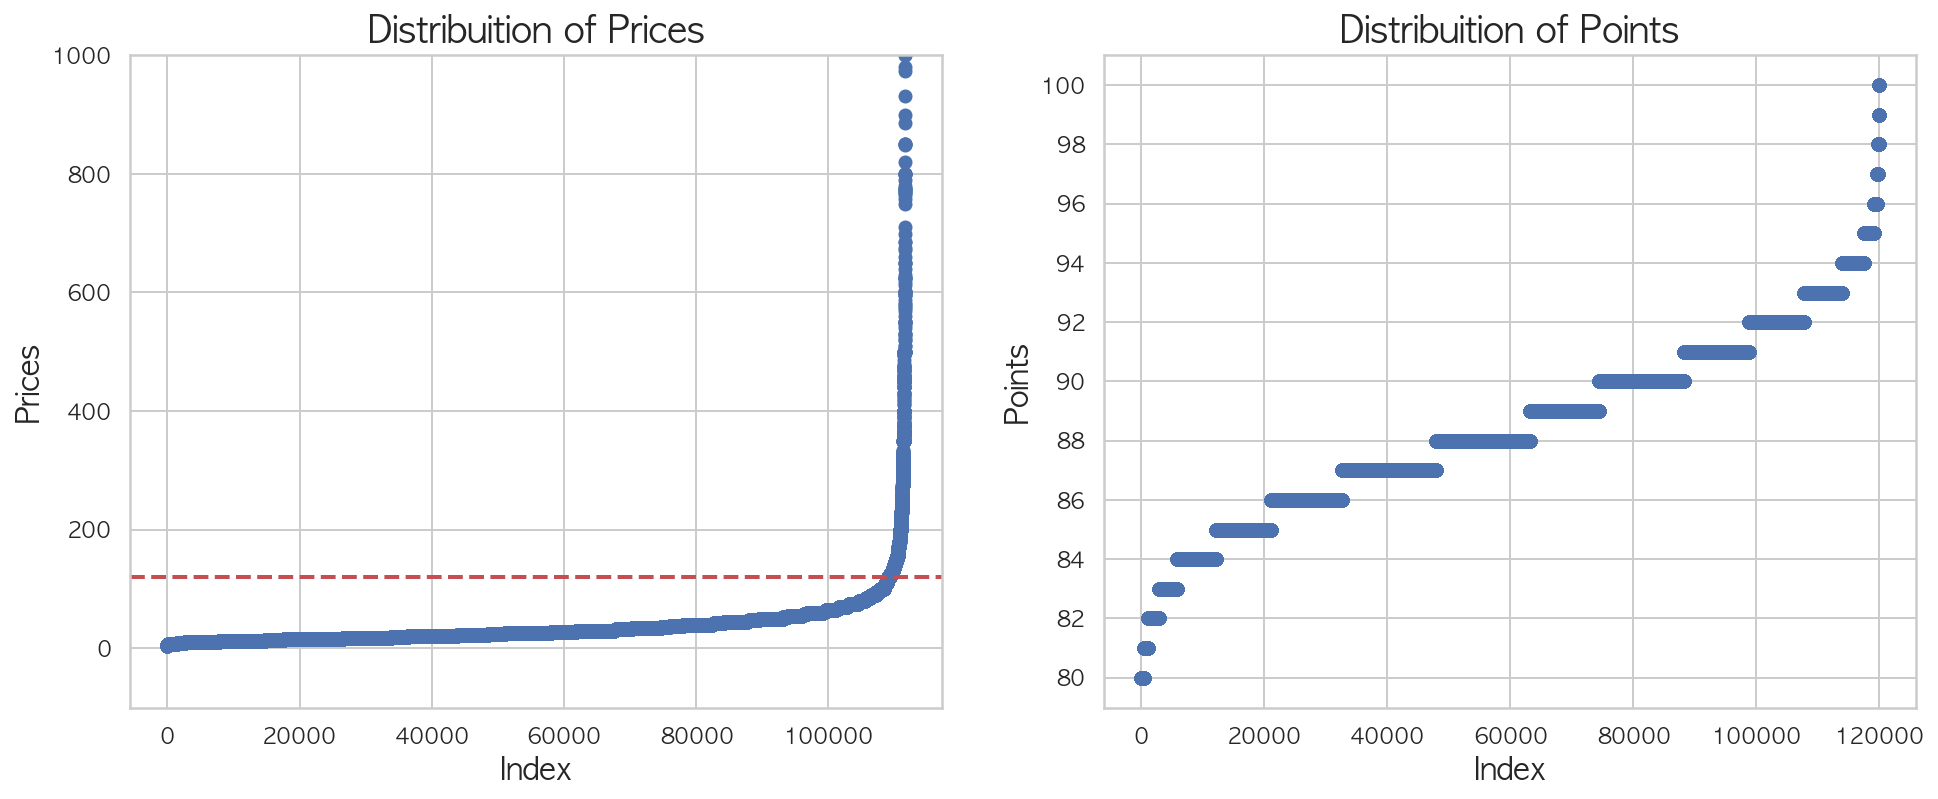

In [11]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1) 
plt.scatter(range(df.shape[0]), np.sort(df.price.values))
plt.title("Distribuition of Prices", fontsize=18)
plt.axhline(y=120, color='r', linestyle='--', linewidth=2) # up to z-score 2
plt.ylim((-100, 1000))
plt.xlabel('Index', fontsize=15)
plt.ylabel('Prices', fontsize=15)

plt.subplot(1, 2, 2) 
plt.scatter(range(df.shape[0]), np.sort(df.points.values))
plt.title("Distribuition of Points", fontsize=18)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Points', fontsize=15)
plt.yticks(np.arange(80, 101, 2))

plt.show()

>위의 빨간선 위의 가격은 z-score 2 이상으로 outlier를 판단한 기준입니다. outlier에 대해서는 후에 서술합니다.

#### Correlation

`price`와 `points`는 어떠한 상관관계를 지니고 있는지 알아보겠습니다.

In [12]:
df.corr()

points     price
points  1.000000  0.416534
price   0.416534  1.000000

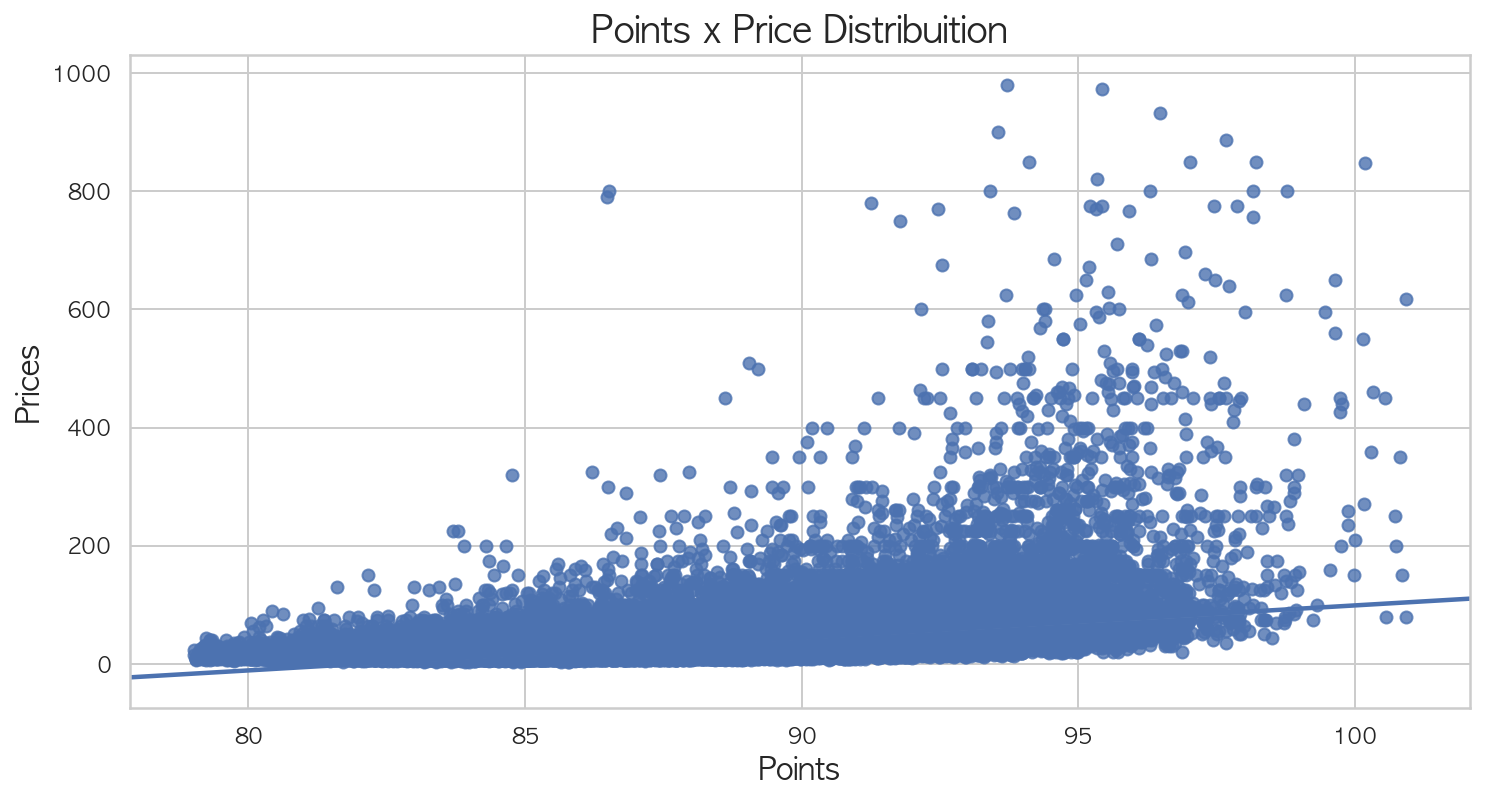

In [13]:
plt.figure(figsize=(12, 6))

sns.regplot(x='points', y='price', data=df[df['price'] < 1000], x_jitter=True)
plt.title("Points x Price Distribuition", fontsize=18)
plt.xlabel("Points", fontsize= 15)
plt.ylabel("Prices", fontsize= 15)

plt.show()

>`price`와 `points`는 약 0.42의 양적 상관관계를 지니고 있습니다.

### `price` -> Target value
- `price`의 NaN 데이터는 119,988 중 8,395개로 약 7%에 해당하는 비중을 차지하고 있습니다.
- 예측하고자 하는 target value가 누락되었다는 것은 사실상 supervised learning에서 필요없는 데이터라는 뜻이 됩니다.
- 다른 값으로 대체하는 방식은 가짜 정답으로 training을 시키는 잘못된 훈련을 만드므로 아예 dataset에서 제외하도록 하겠습니다.

In [14]:
train_df = deepcopy(df)
df_idx = df[df.isnull()['price']].index

del df

#### Missing value

In [15]:
missing_value(train_df).loc['price']

Shape of Dataset: (119988, 13)


NaN count    8395.0
NaN rate     7.0   
Name: price, dtype: float64

In [16]:
drop_idx_price = train_df[train_df.isnull()['price']].index
train_df = train_df.drop(index=drop_idx_price)

#### Distribution

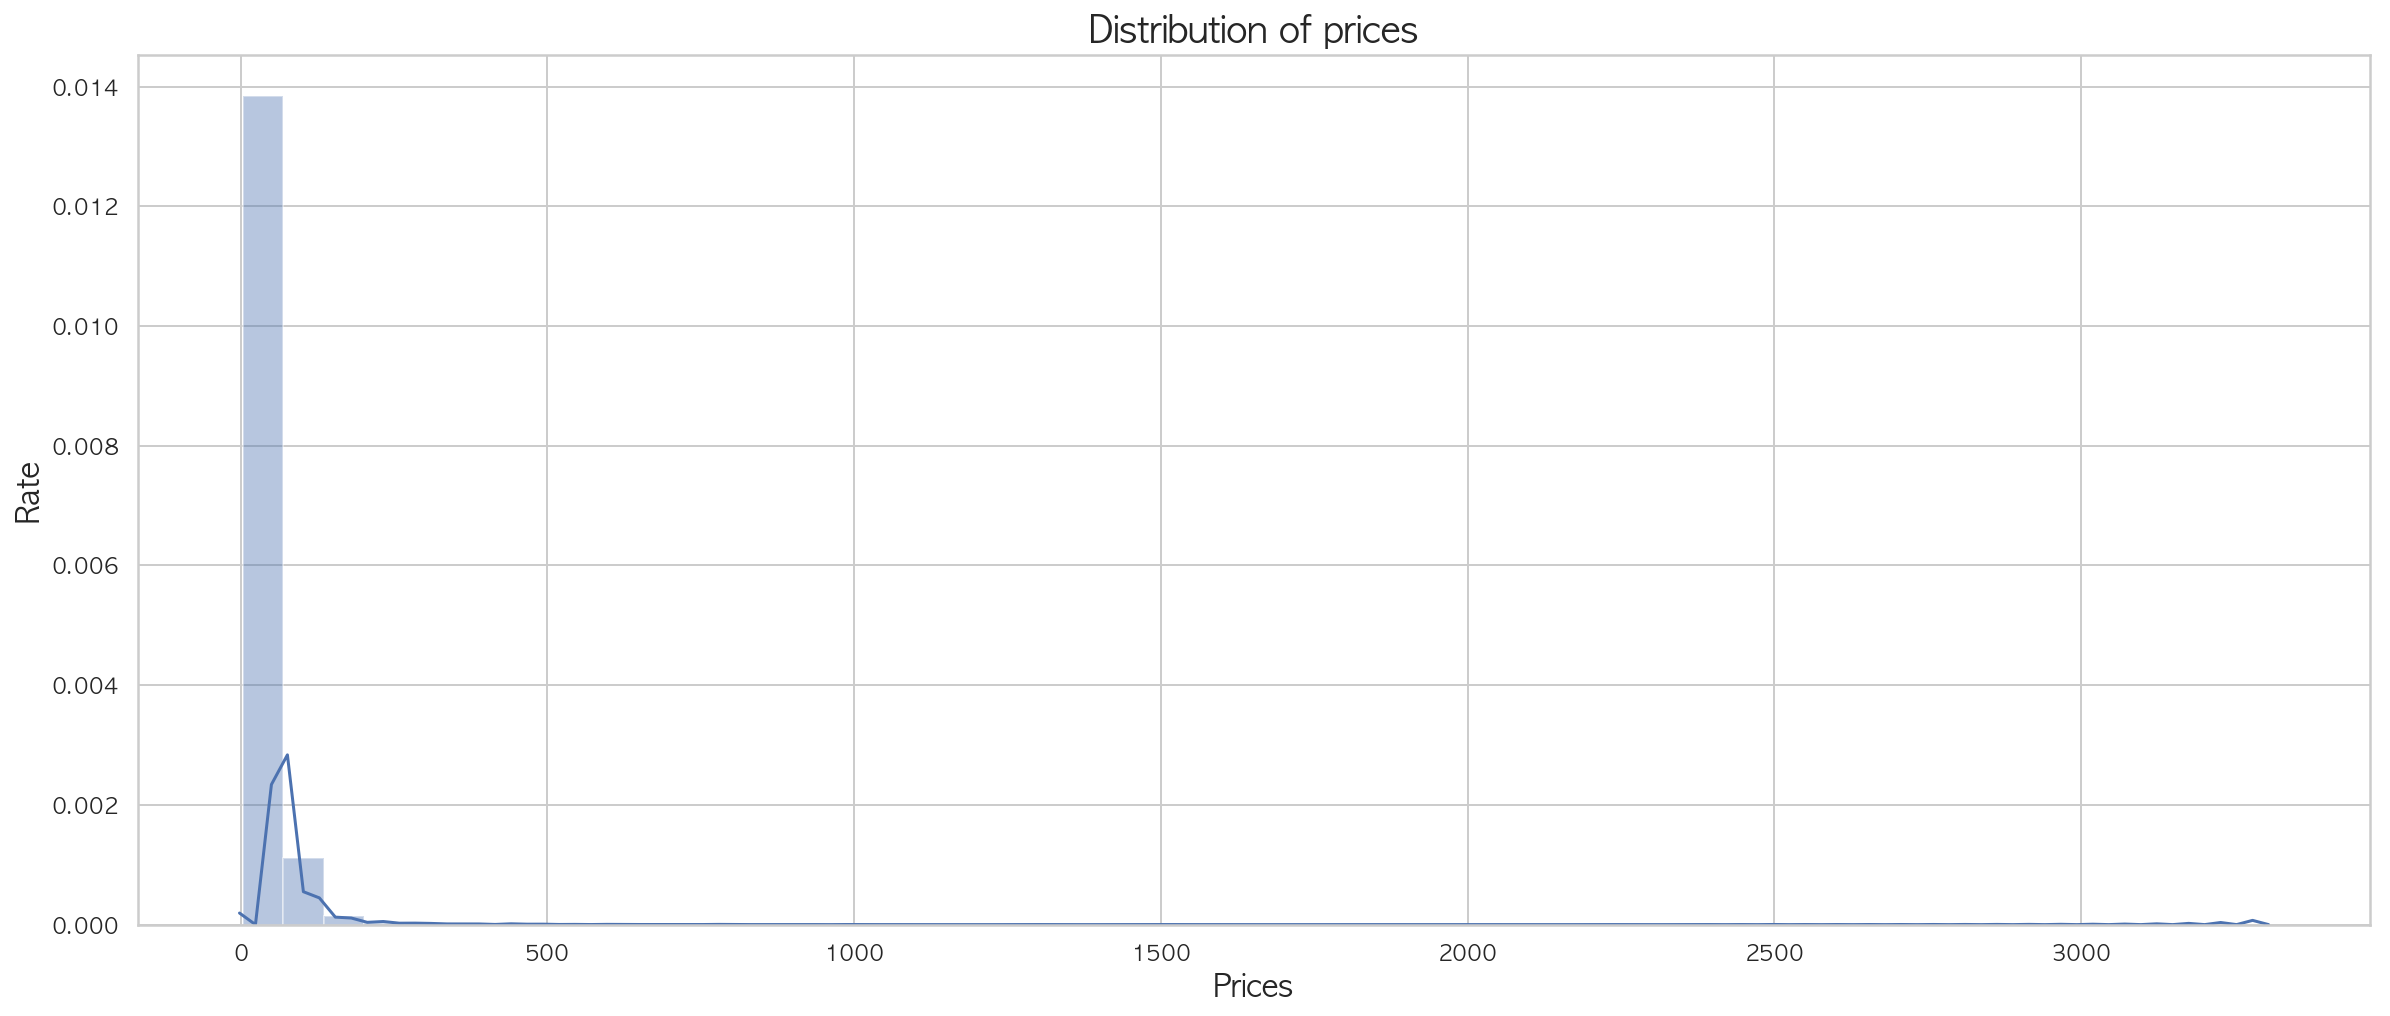

In [17]:
plt.figure(figsize=(20, 8))
sns.distplot(train_df['price'])
plt.title("Distribution of prices", fontsize=18)
plt.xlabel('Prices', fontsize=15)
plt.ylabel('Rate', fontsize=15)
plt.show()

높은 가격대의 값으로 인해 분포가 크게 치우치고 가독성이 떨어지므로 200 이하의 값에 대해서만 분포를 확인해보도록 하겠습니다.

`price`가 200 이상인 데이터의 비율: 0.6 %


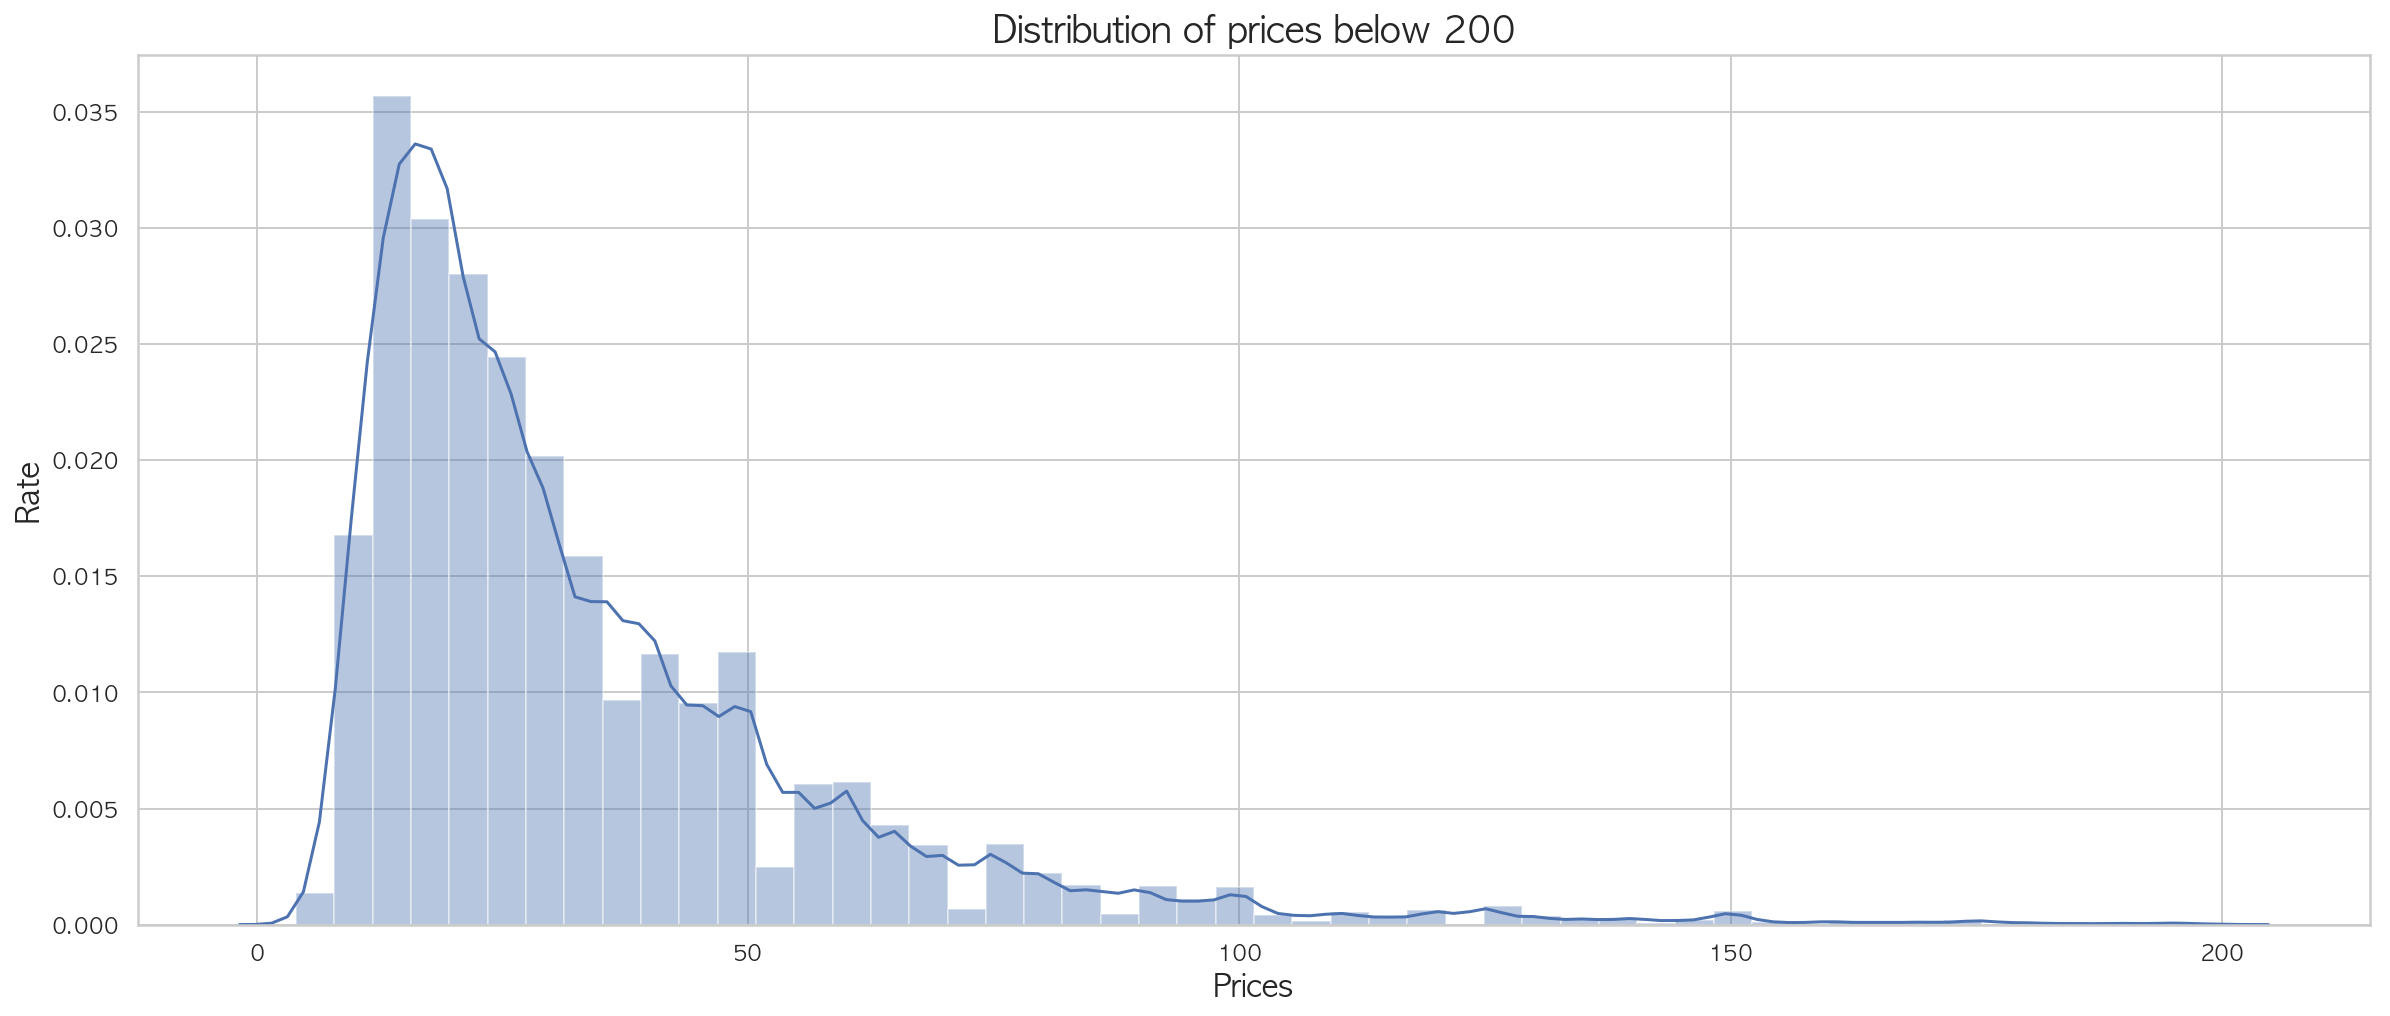

In [18]:
plt.figure(figsize=(20, 8))
sns.distplot(train_df[train_df["price"] < 200]['price'])
plt.title("Distribution of prices below 200", fontsize=18)
plt.xlabel('Prices', fontsize=15)
plt.ylabel('Rate', fontsize=15)

percent = round(train_df[train_df['price'] > 200].shape[0] / train_df.shape[0] * 100, 2)
print("`price`가 200 이상인 데이터의 비율:", percent, "%")

#### Log transformation

`price`는 값이 0부터 시작하고 임의의 큰 값들을 일부 가지고 있으므로, log transformation을 통해 skewness를 어느 정도 해소하고 정규분포에 가까운 형태로 만들 수 있습니다.

Text(0, 0.5, 'Rate')

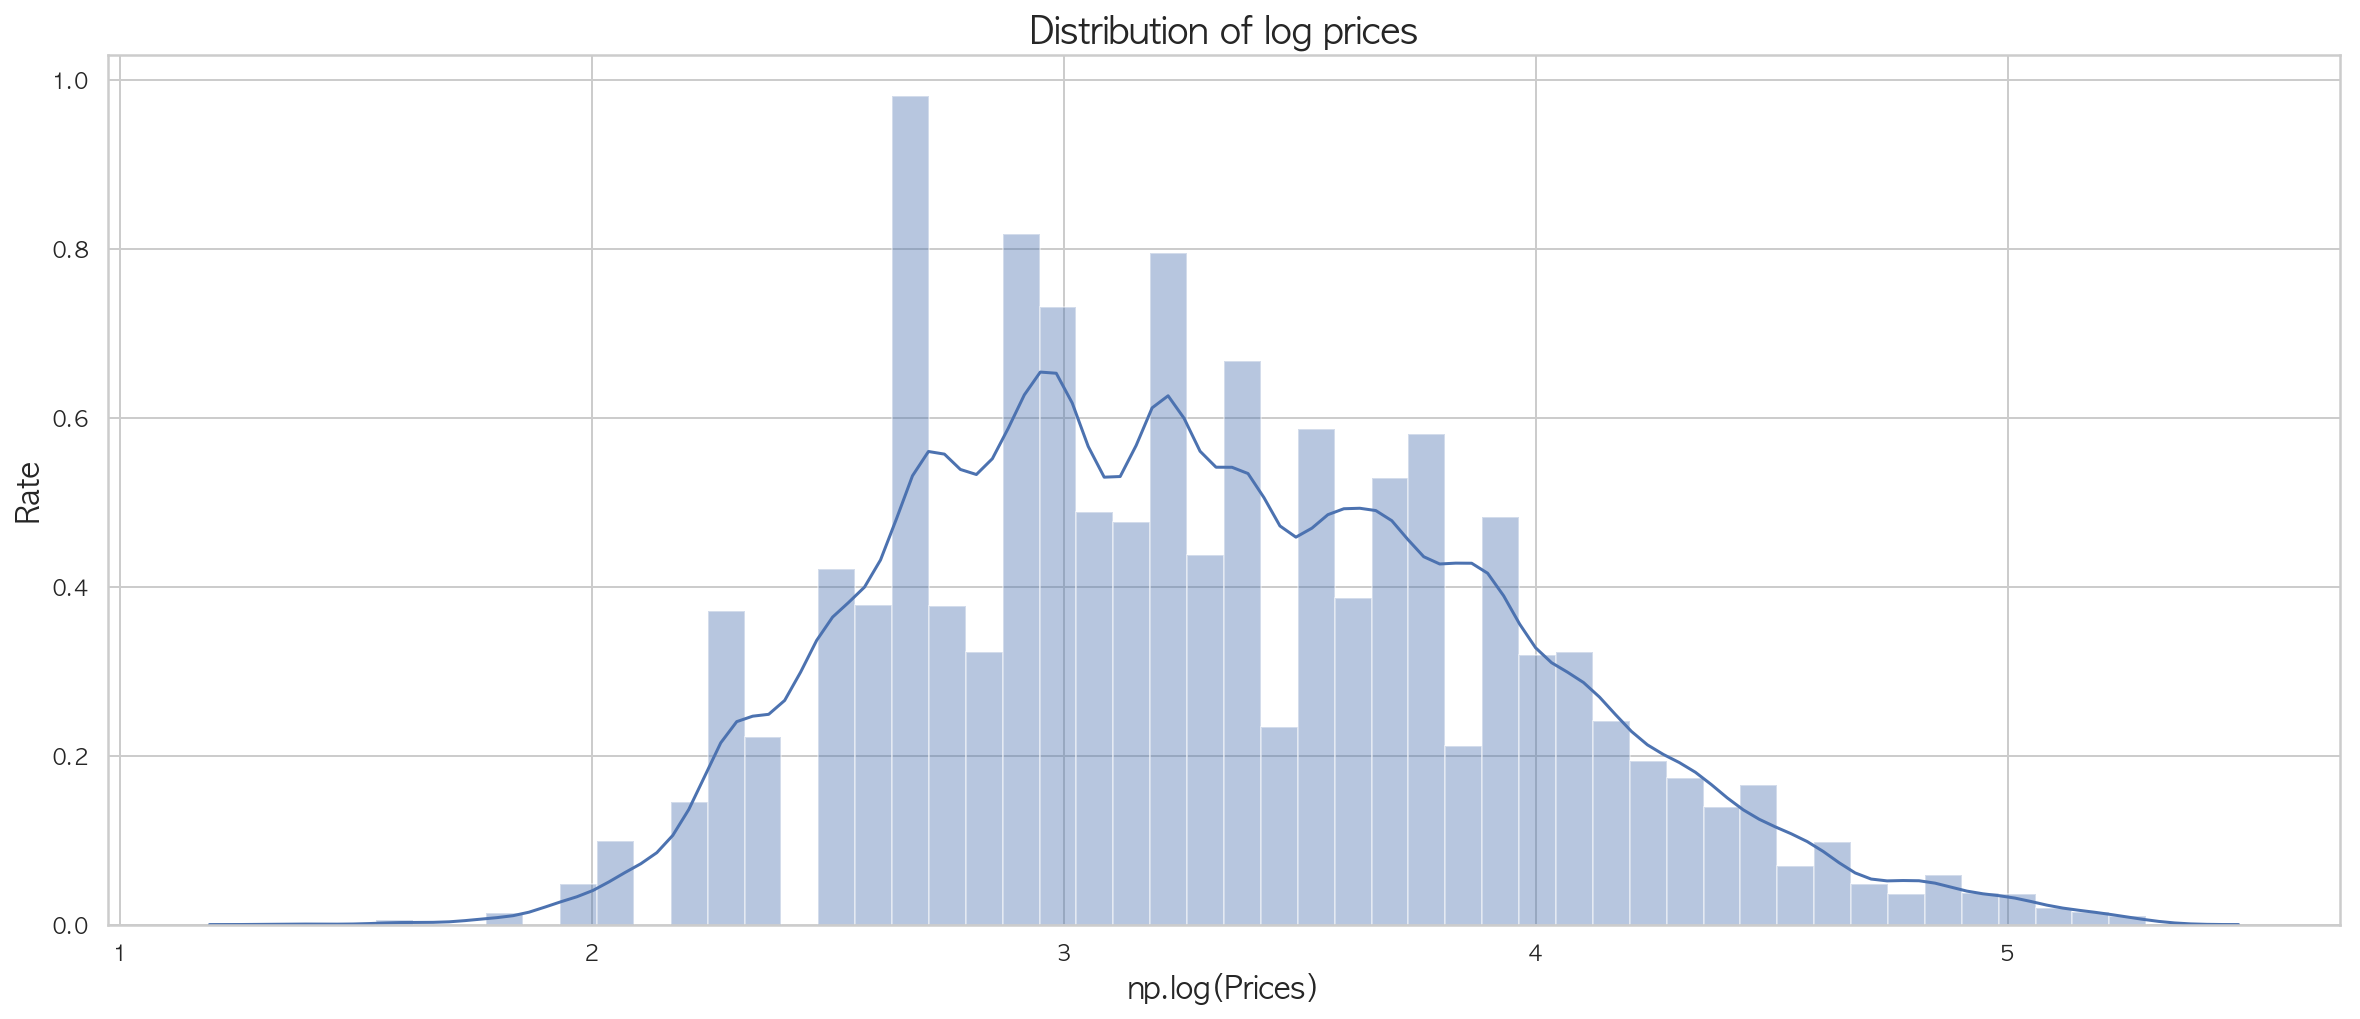

In [19]:
plt.figure(figsize=(20, 8))
sns.distplot(np.log(train_df[train_df['price'] < 200]['price']))
plt.title("Distribution of log prices", fontsize=18)
plt.xlabel('np.log(Prices)', fontsize=15)
plt.ylabel('Rate', fontsize=15)

---

### `points`

#### Distribution

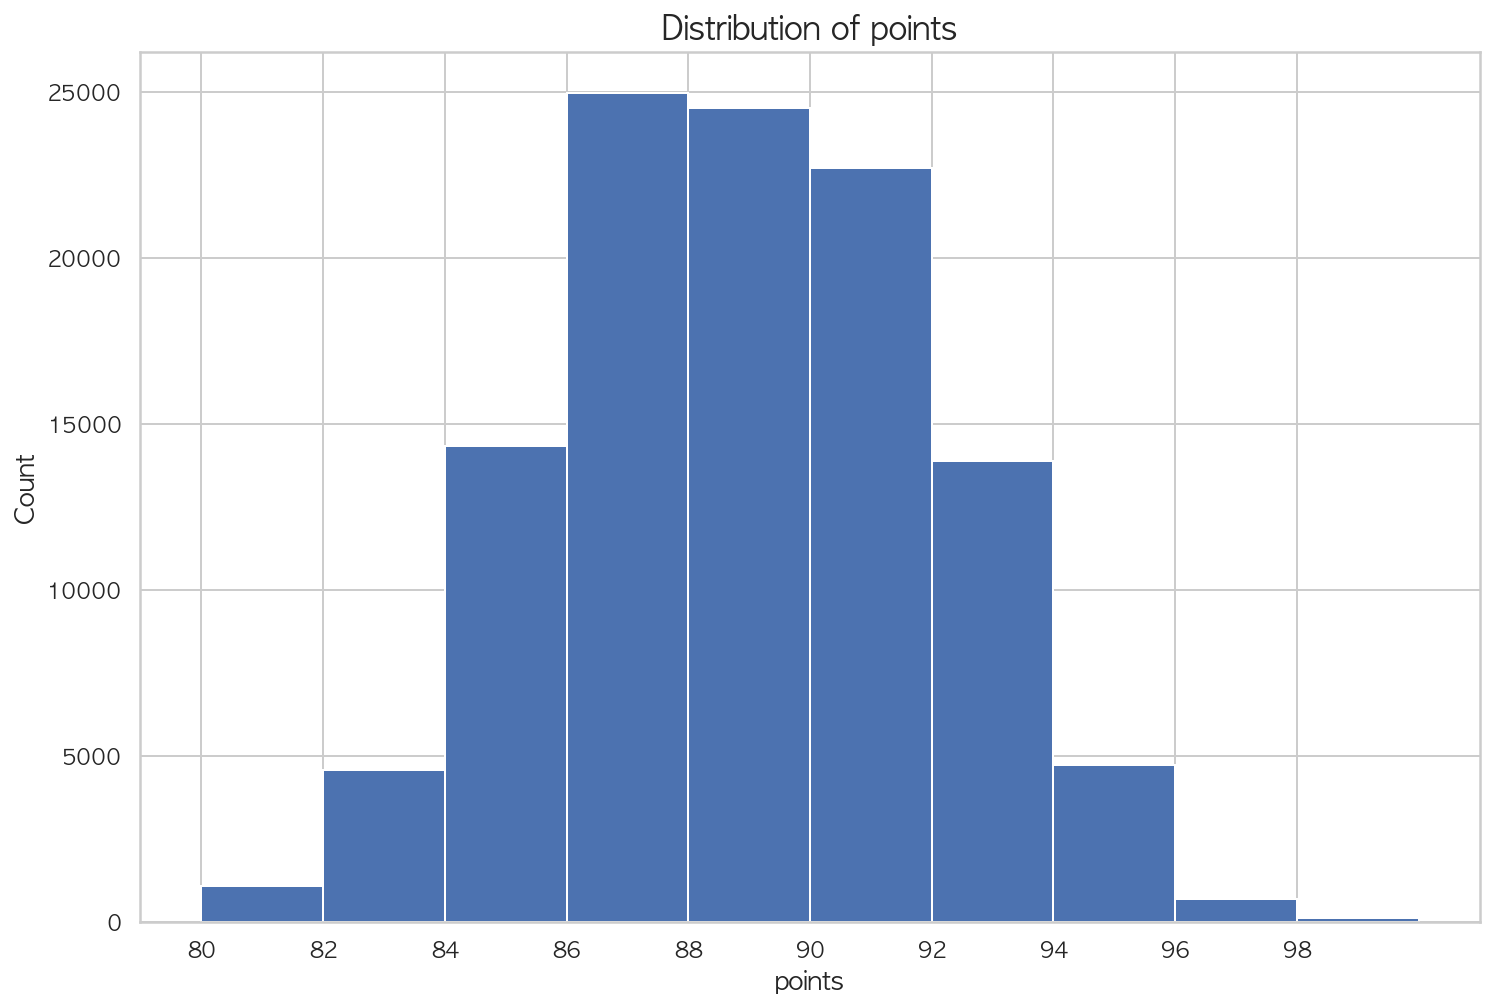

In [20]:
plt.figure(figsize=(12, 8))
plt.hist(train_df['points'], edgecolor='white')
plt.title("Distribution of points", fontsize=16)
plt.xticks(np.arange(80, 100, 2))
plt.xlabel("points", fontsize=13)
plt.ylabel("Count", fontsize=13)
plt.show()

>`points`는 최소값과 최대값이 명확한 분포를 지니는 특성이 있습니다. 이렇게 분포 상의 outlier가 존재하지 않는 수치형 데이터는 평균 0, 표준편차 1로 만드는 `StandardScaler`보다 최소값을 0, 최대값을 1로 만드는 `MinMaxScaler`가 스케일링에 더 적절합니다.

#### Missing value

In [21]:
missing_value(train_df, 'points')

Shape of Dataset: (111593, 13)
Missing value of points
NaN count	 0
NaN rate	 0.0%


#### Normalization

`MinMaxScaler`를 이용한 스케일링 작업으로 `points`를 정규화합니다. 이 과정을 통해서 Feature matix의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상시키고 데이터 간의 관계를 선형 모형에 맞게 바꿀 수 있습니다.

In [22]:
scaler = MinMaxScaler()
train_df['points'] = scaler.fit_transform(train_df['points'].values.reshape(-1, 1))

---

## Categorical Features
- Issue: Dimension reduction of Nominal data

In [23]:
cf_ = pd.DataFrame([train_df['country'].nunique(),
                    train_df['province'].nunique(),
                    train_df['region_1'].nunique(),
                    train_df['region_2'].nunique(),
                    train_df['designation'].nunique(),
                    train_df['winery'].nunique(),
                    train_df['variety'].nunique(),
                   train_df['taster_name'].nunique()],
                    index=['country', 'province', 'region_1', 
                           'region_2','designation', 'winery',
                           'variety', 'taster_name'],
                    columns=['Number of categories'])
cf_.index.names = ['Categorical features']
cf_

Number of categories
Categorical features                      
country               42                  
province              422                 
region_1              1204                
region_2              17                  
designation           35776               
winery                15855               
variety               697                 
taster_name           19

>전반적으로 카테고리의 수가 많은 High cardinality feature입니다.

### Geographical Features
- 아래의 5개의 feature는 지역적 특성을 반영하고 있습니다.
- `Country` > `province` > `region_1`, `region_2` > `designation`

### `country`

#### Distribution

총 42개의 국가가 있습니다.

In [24]:
train_df['country'].nunique()

42

In [25]:
countries = train_df['country'].value_counts()

42개의 국가 중 가장 많은 비중을 차지하는 10개의 국가를 확인하겠습니다.

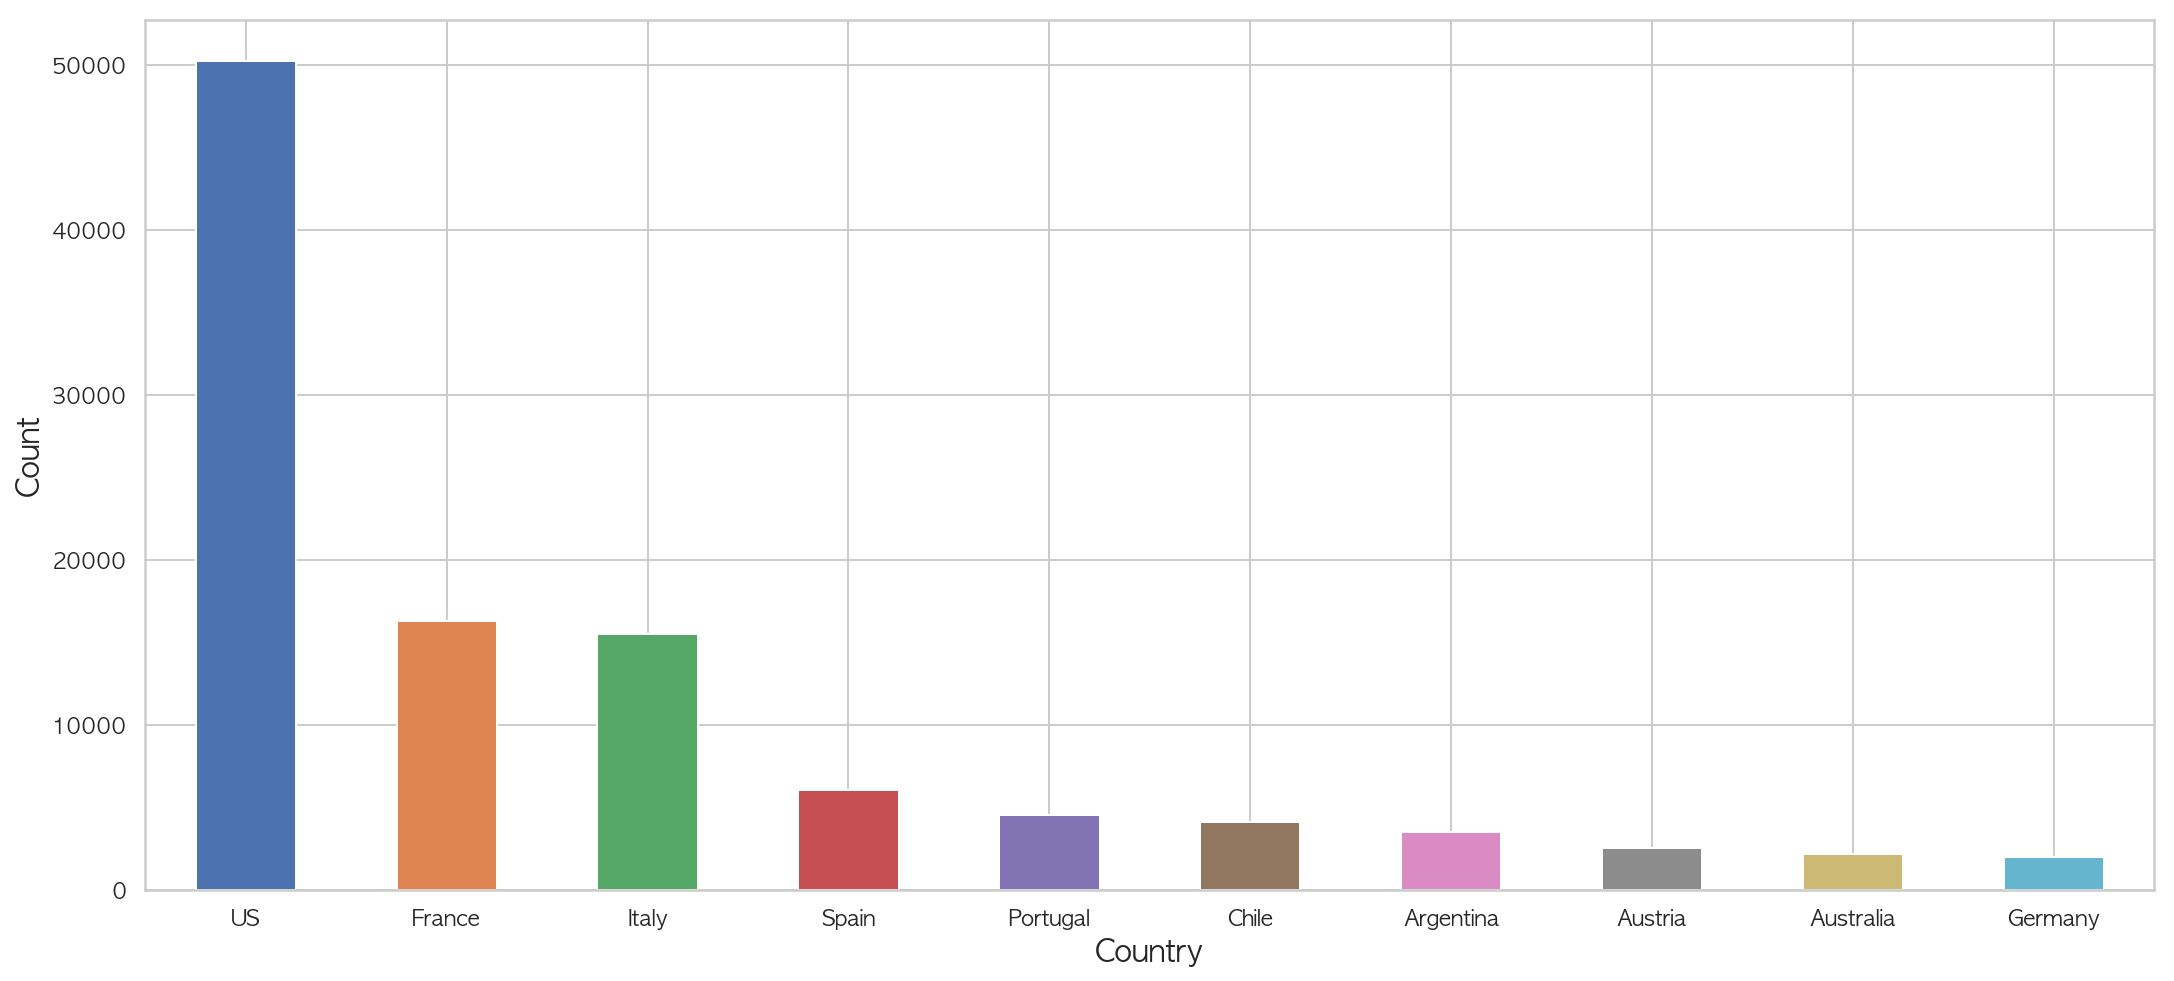

In [26]:
countries[:10].plot(kind='bar', figsize=(18, 8), rot=0)
plt.xlabel('Country', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

아래의 파이차트는 OIV(International Organisation of Vine and Wine)라는 와인의 국제기구에서 조사한 세계 각 국가의 와인 생산량입니다. 아래의 자료와 다르게 위 데이터셋은 미국(`US`)의 비율이 상당히 높습니다. 즉 실제 세계의 분포와 다소 거리감이 있는 미국에 편향되어 있는 데이터 입니다.

![wine_production_rate](./data/Top-15-wine-producing-countries-2018-est.png)

##### 출처: https://italianwinecentral.com/top-fifteen-wine-producing-countries/

가장 많이 관측된 국가 top10의 가격 분포를 확인하겠습니다.

##### US, France, Italy, Spain, Portugal

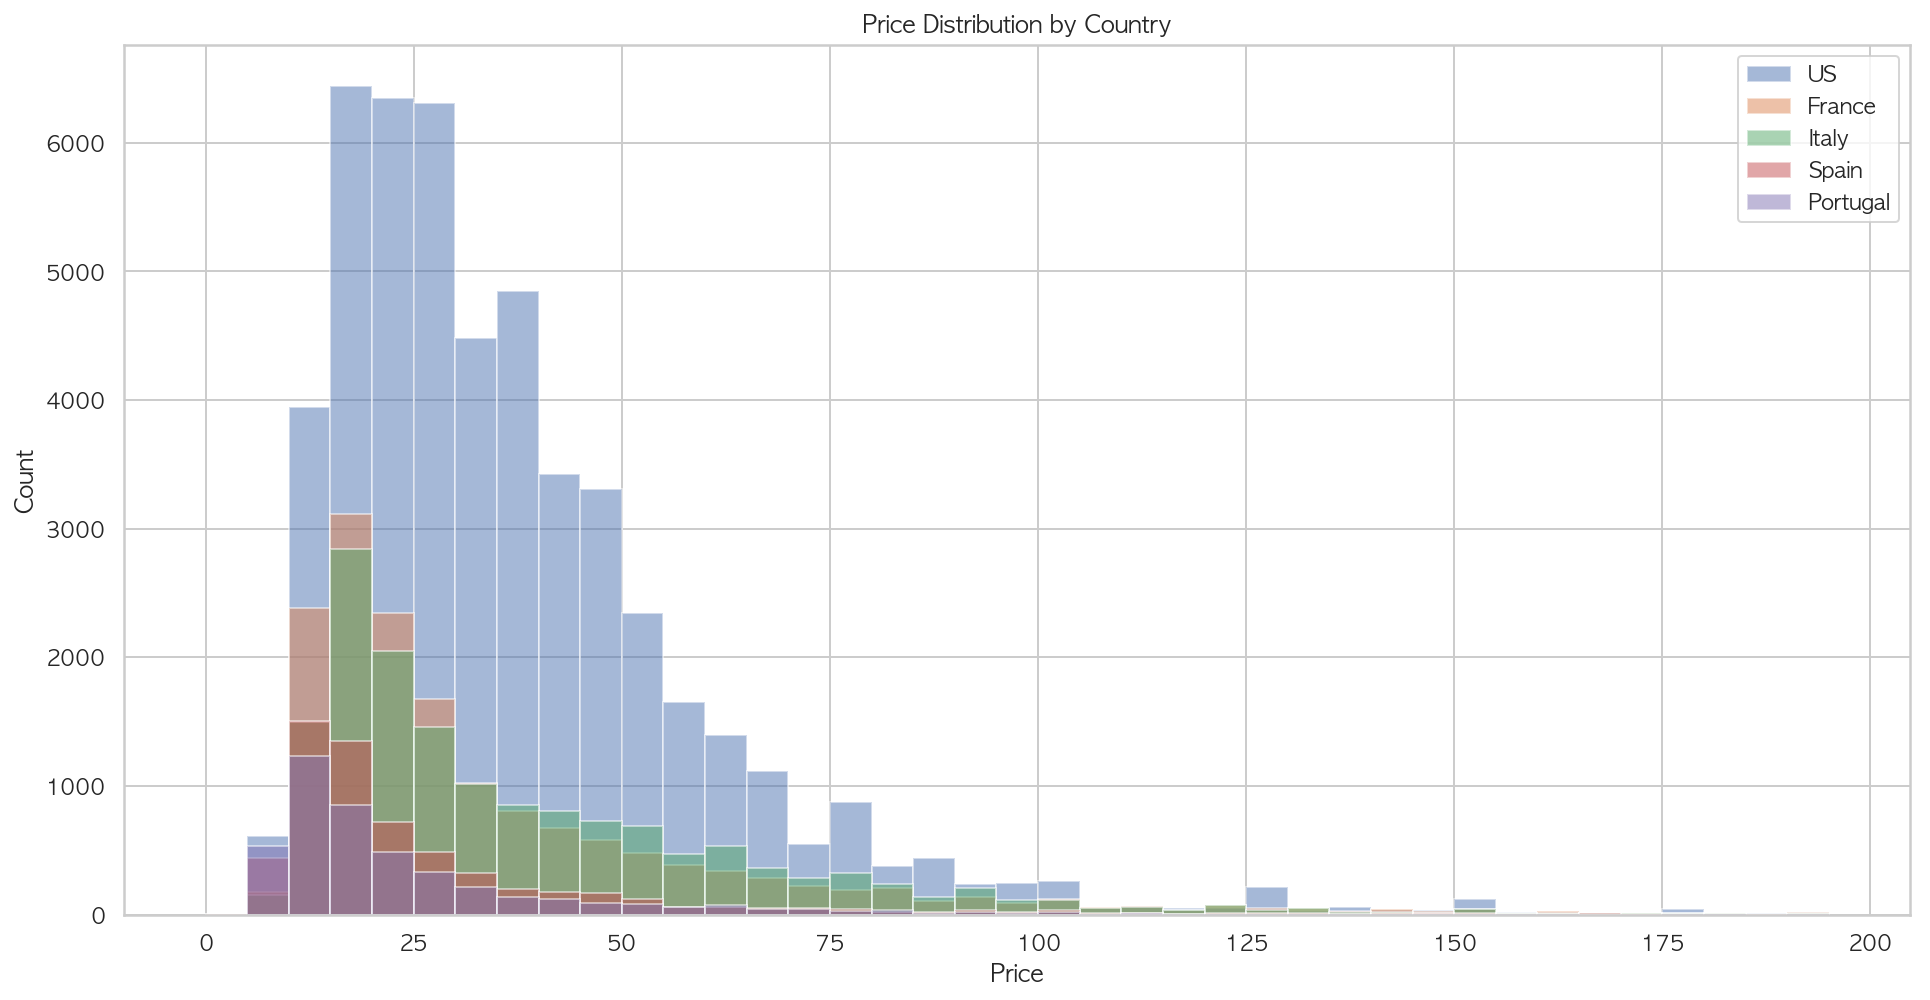

In [27]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in countries.index[:5]:
    plt.hist(train_df.loc[train_df['country'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by Country')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

##### Chile, Argentina, Austria, Australia, Germany

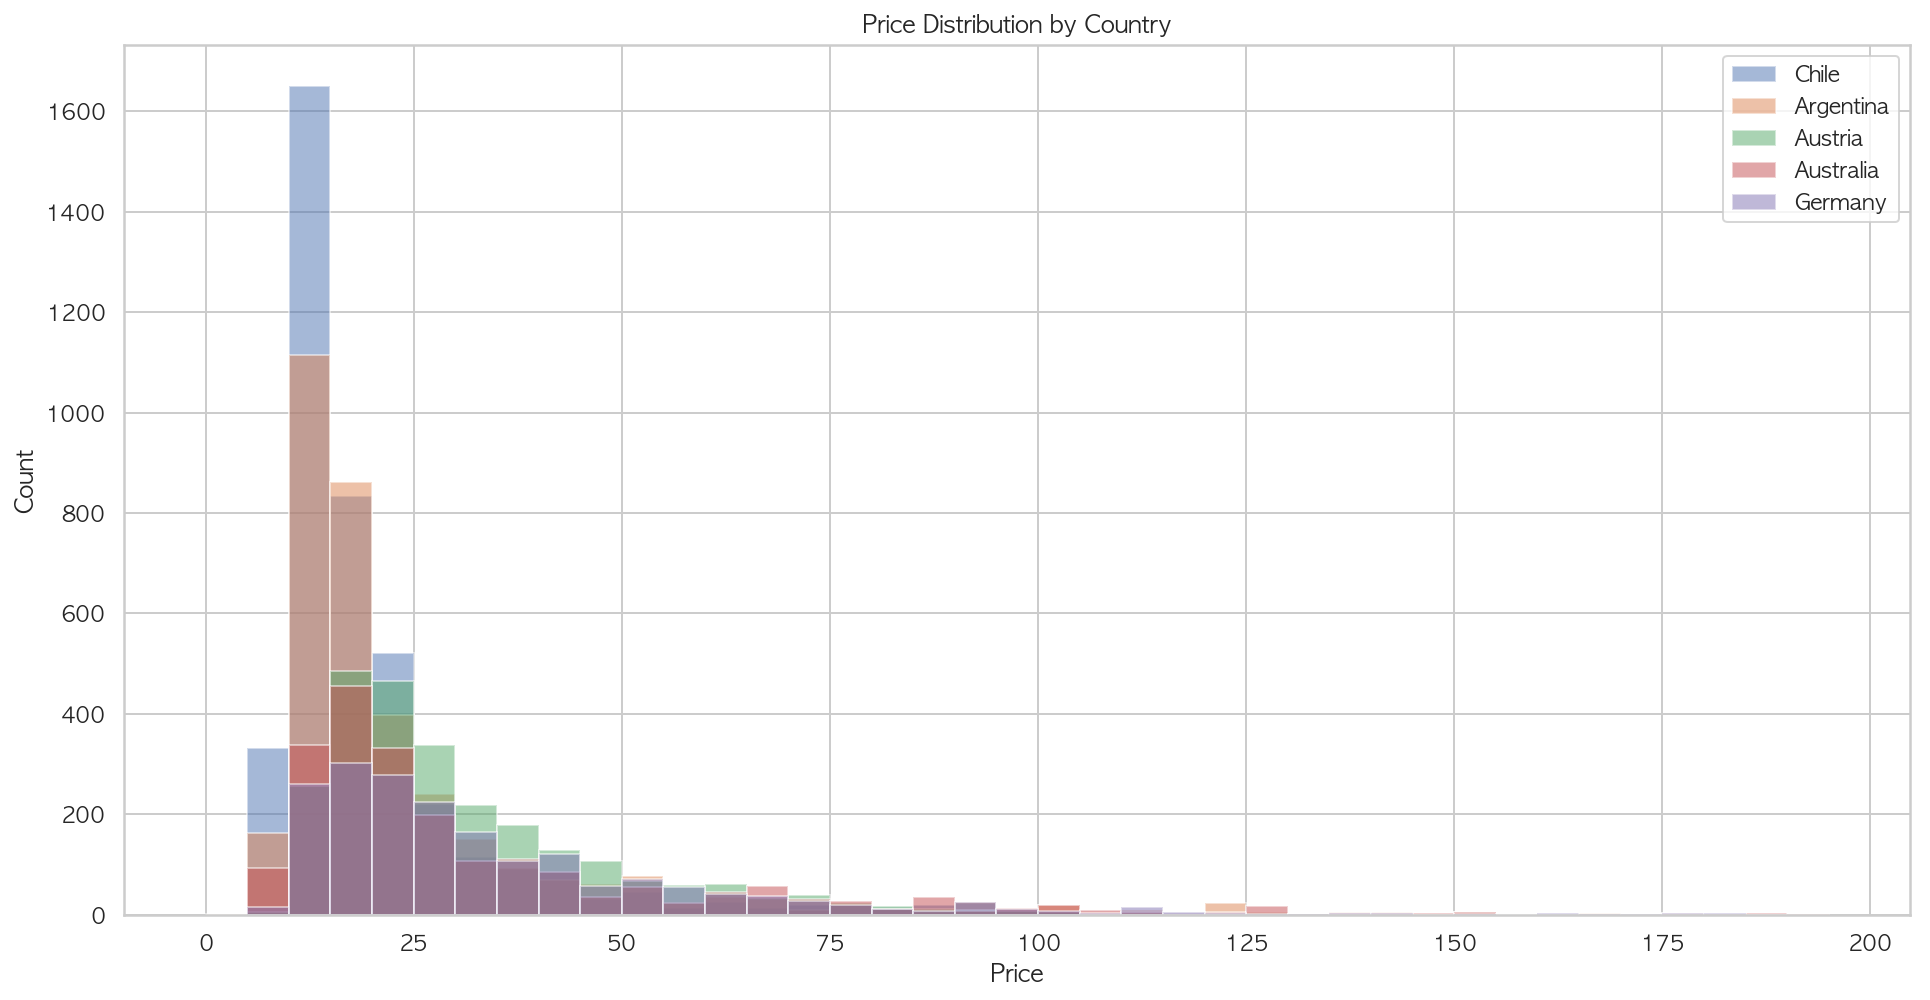

In [28]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in countries.index[5:10]:
    plt.hist(train_df.loc[train_df['country'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by Country')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Box plot

In [29]:
top10_countries = countries.index[:10]

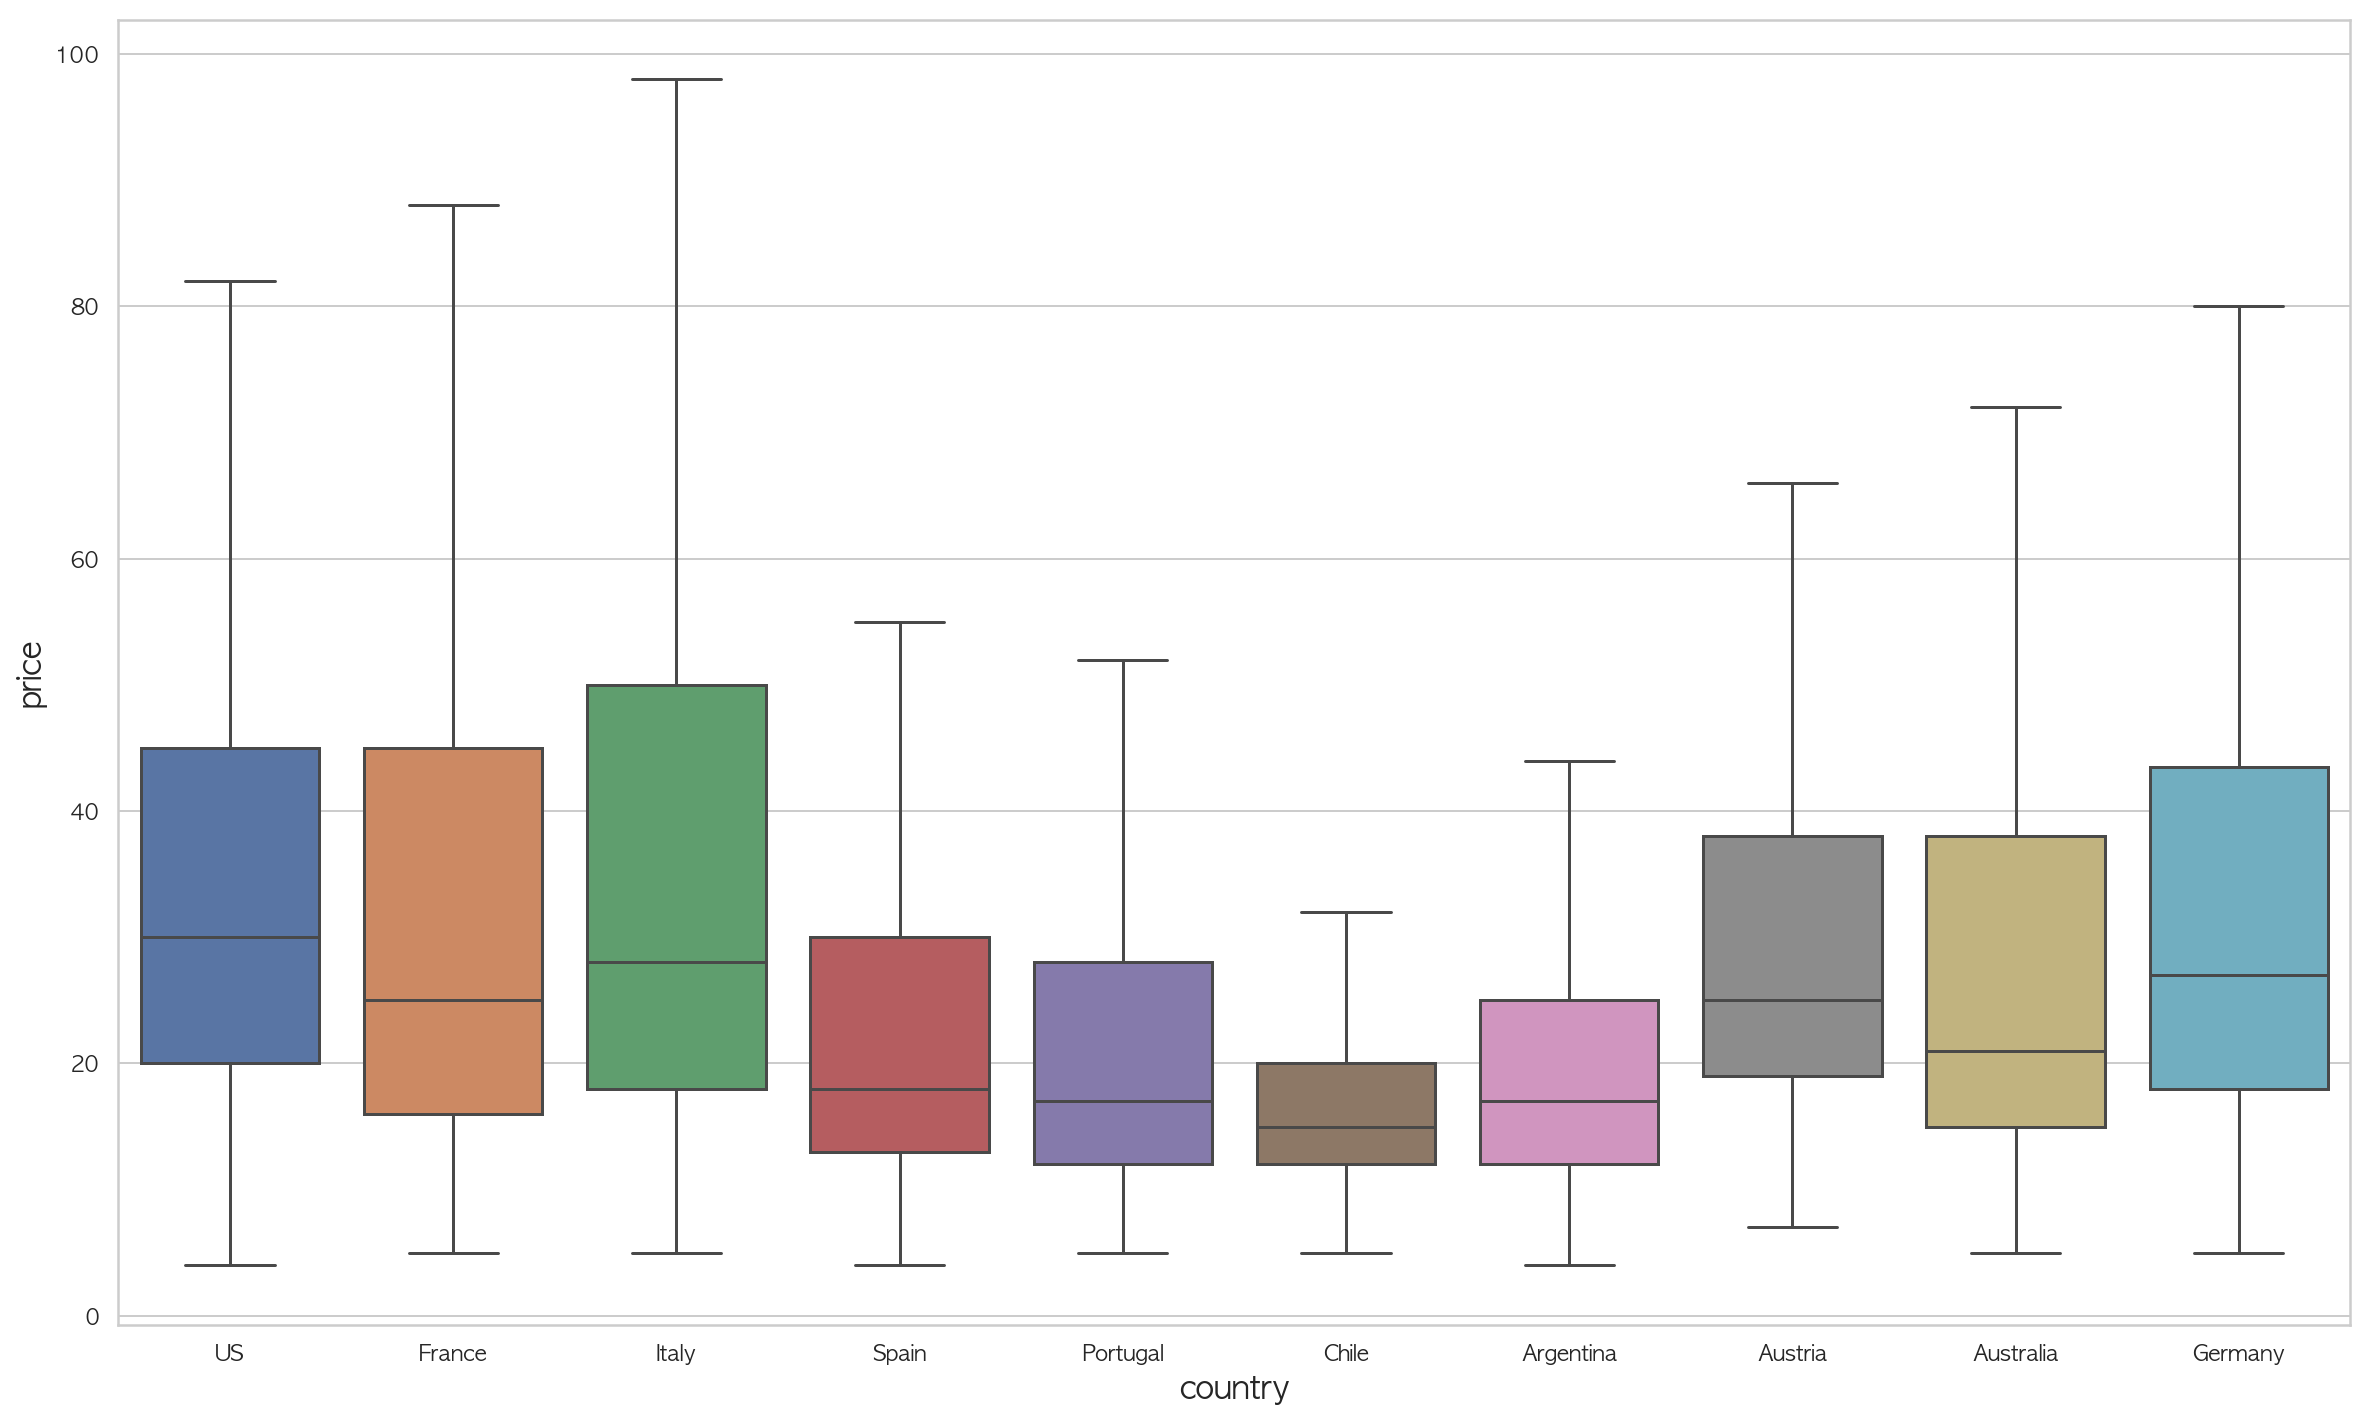

In [30]:
plt.figure(figsize=(20, 12))
sns.boxplot(x='country', y='price',
            data=train_df[train_df['country'].isin(top10_countries)], 
            showfliers=False, 
            order=top10_countries)
plt.xlabel('country', fontsize=16)
plt.ylabel('price', fontsize=16)

plt.show()

#### Missing value

In [31]:
missing_value(train_df, 'country')

Shape of Dataset: (111593, 13)
Missing value of country
NaN count	 55
NaN rate	 0.05%


- feature의 특성 상 `country`가 결측값이더라도 `province`값이 존재한다면 `country` 값을 추측하는 것이 가능합니다.
- 그러나 `country`가 결측된 경우는 전부 `province`를 포함하여 `region_1`, `region_2`까지 모든 지리적 특성이 NaN값 이었습니다.
- 이 데이터들은 전체 데이터에서 차지하는 비중도 굉장히 낮으며(0.04%) 지리적 특성이 전부 누락되어있기 때문에 회귀분석을 위한 데이터셋에서 제외하였습니다.

In [32]:
no_country = train_df[['country', 'province', 'region_1', 'region_2']]
print(no_country[no_country['country'].isnull()].info())

del no_country

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 913 to 129900
Data columns (total 4 columns):
country     0 non-null object
province    0 non-null object
region_1    0 non-null object
region_2    0 non-null object
dtypes: object(4)
memory usage: 2.1+ KB
None


In [33]:
drop_idx_country = train_df[train_df.isnull()['country']].index
train_df = train_df.drop(index=drop_idx_country)

---

### `province`

#### Distribution

총 422개의 지방으로 나뉘어 있습니다.

In [34]:
train_df['province'].nunique()

422

42개의 국가 중 가장 많은 비중을 차지하는 10개의 국가를 확인하겠습니다.

In [35]:
province = train_df['province'].value_counts()

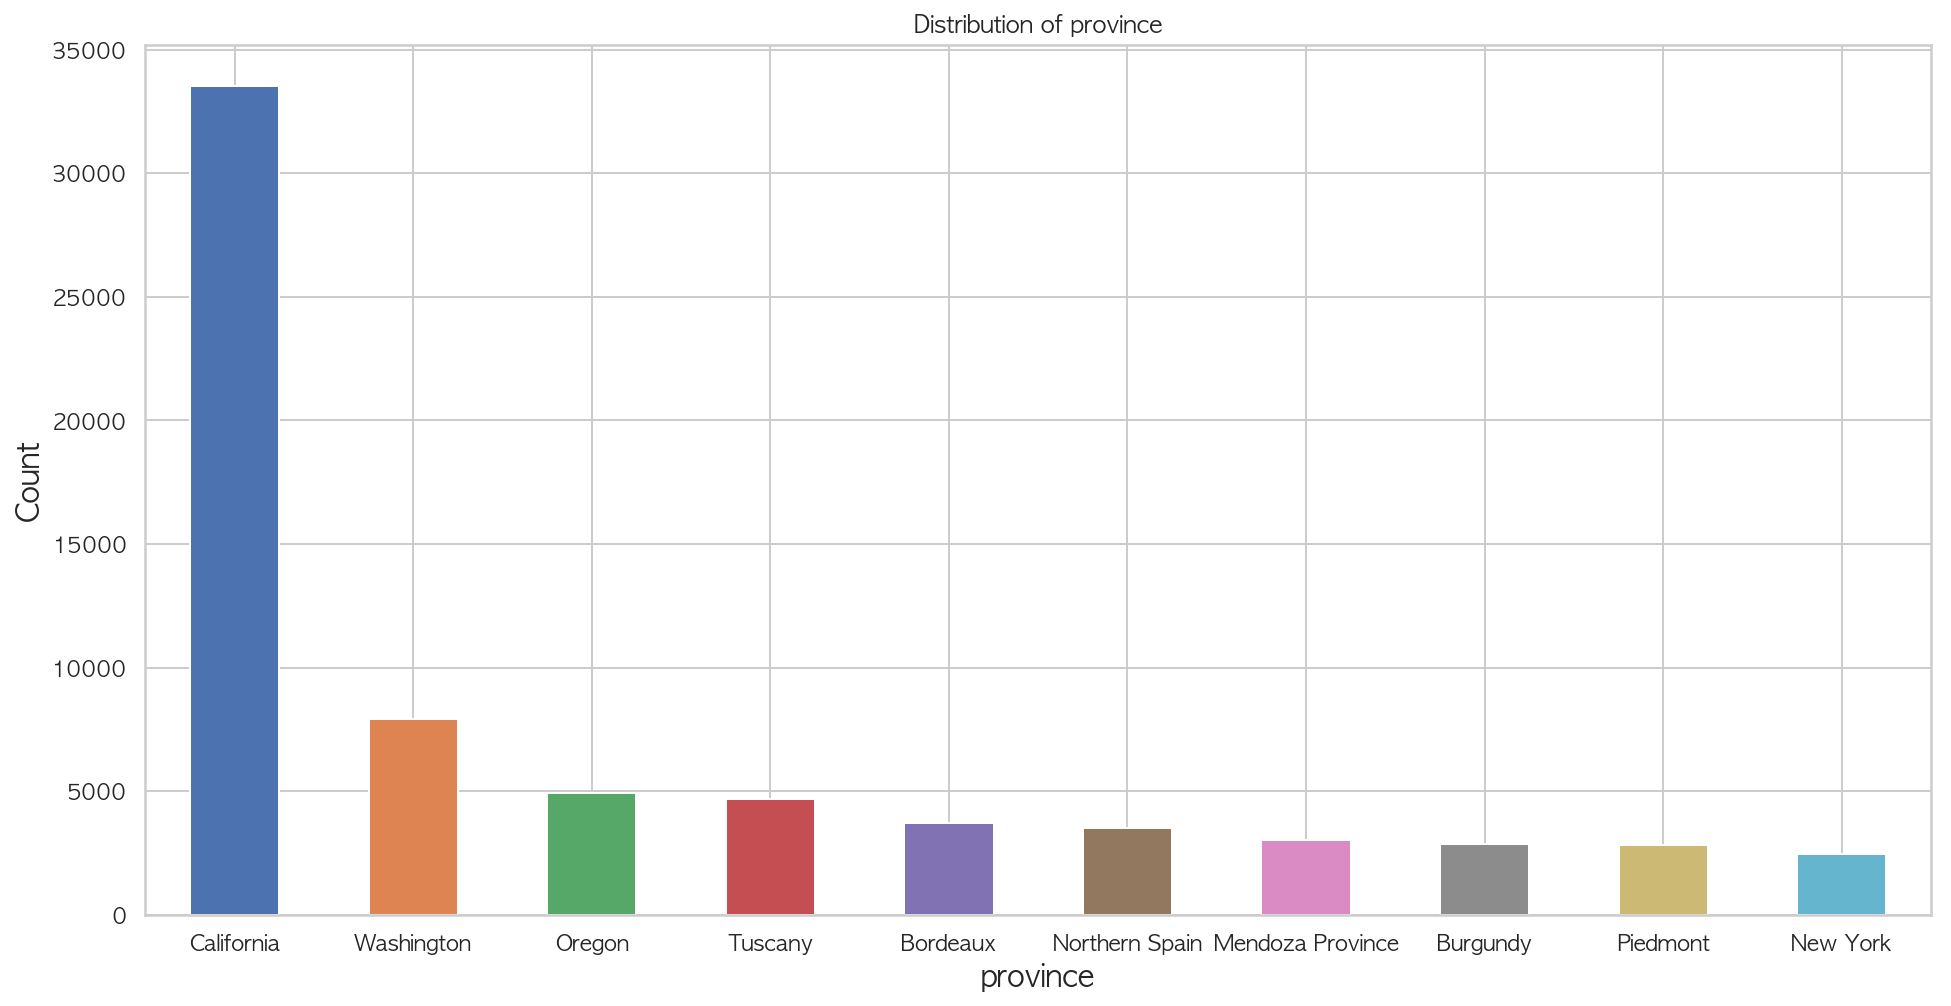

In [36]:
province[:10].plot(kind='bar', figsize=(16, 8), rot=0)
plt.title('Distribution of province')
plt.xlabel('province', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

위의 `country`에서 확인할 수 있었듯이 국가의 분포가 미국으로 다소 편향되어 있었는데, 미국 안에서도 California 지방의 와인으로 크게 편향되어 있는 모습이 보입니다.

가장 많이 관측된 지방의 top10의 가격 분포를 확인하겠습니다.

##### California, Washington, Oregon, Tuscany, Bordeaux

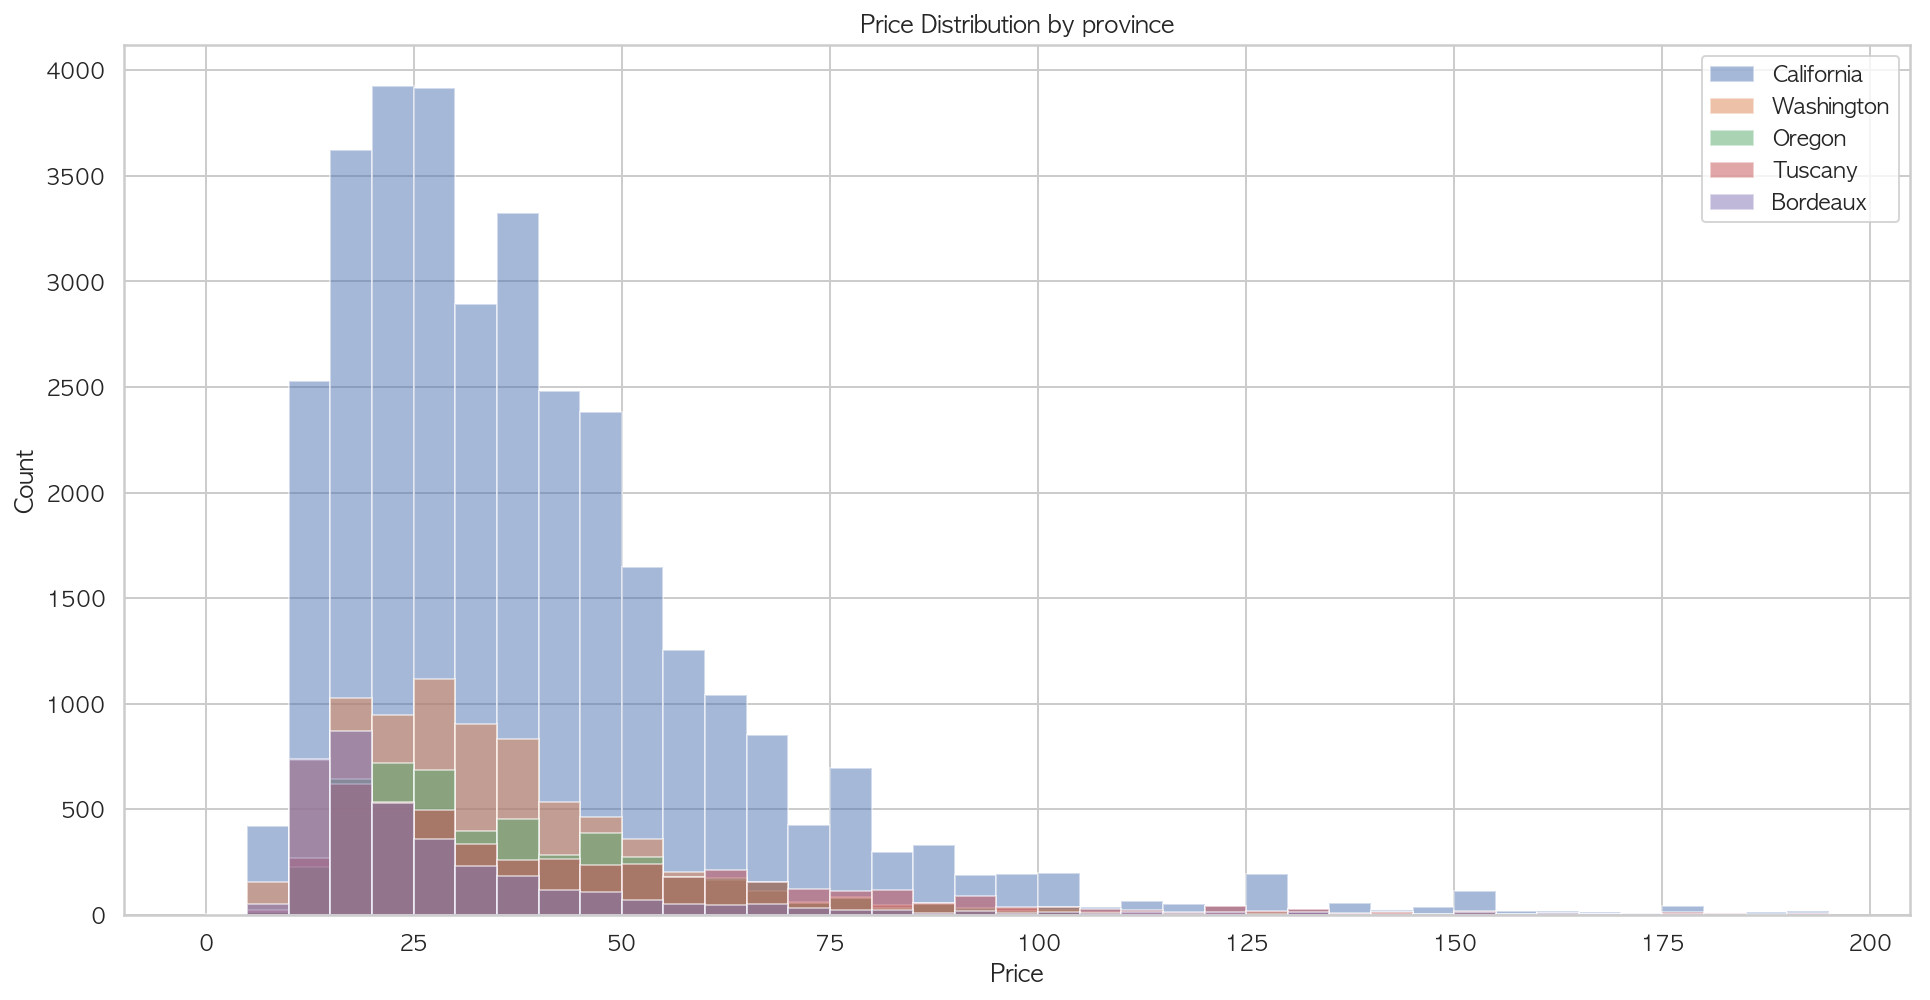

In [37]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in province.index[:5]:
    plt.hist(train_df.loc[train_df['province'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by province')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

##### Northern Spain, Mendoza Province, Burgundy, Piedmont, New York

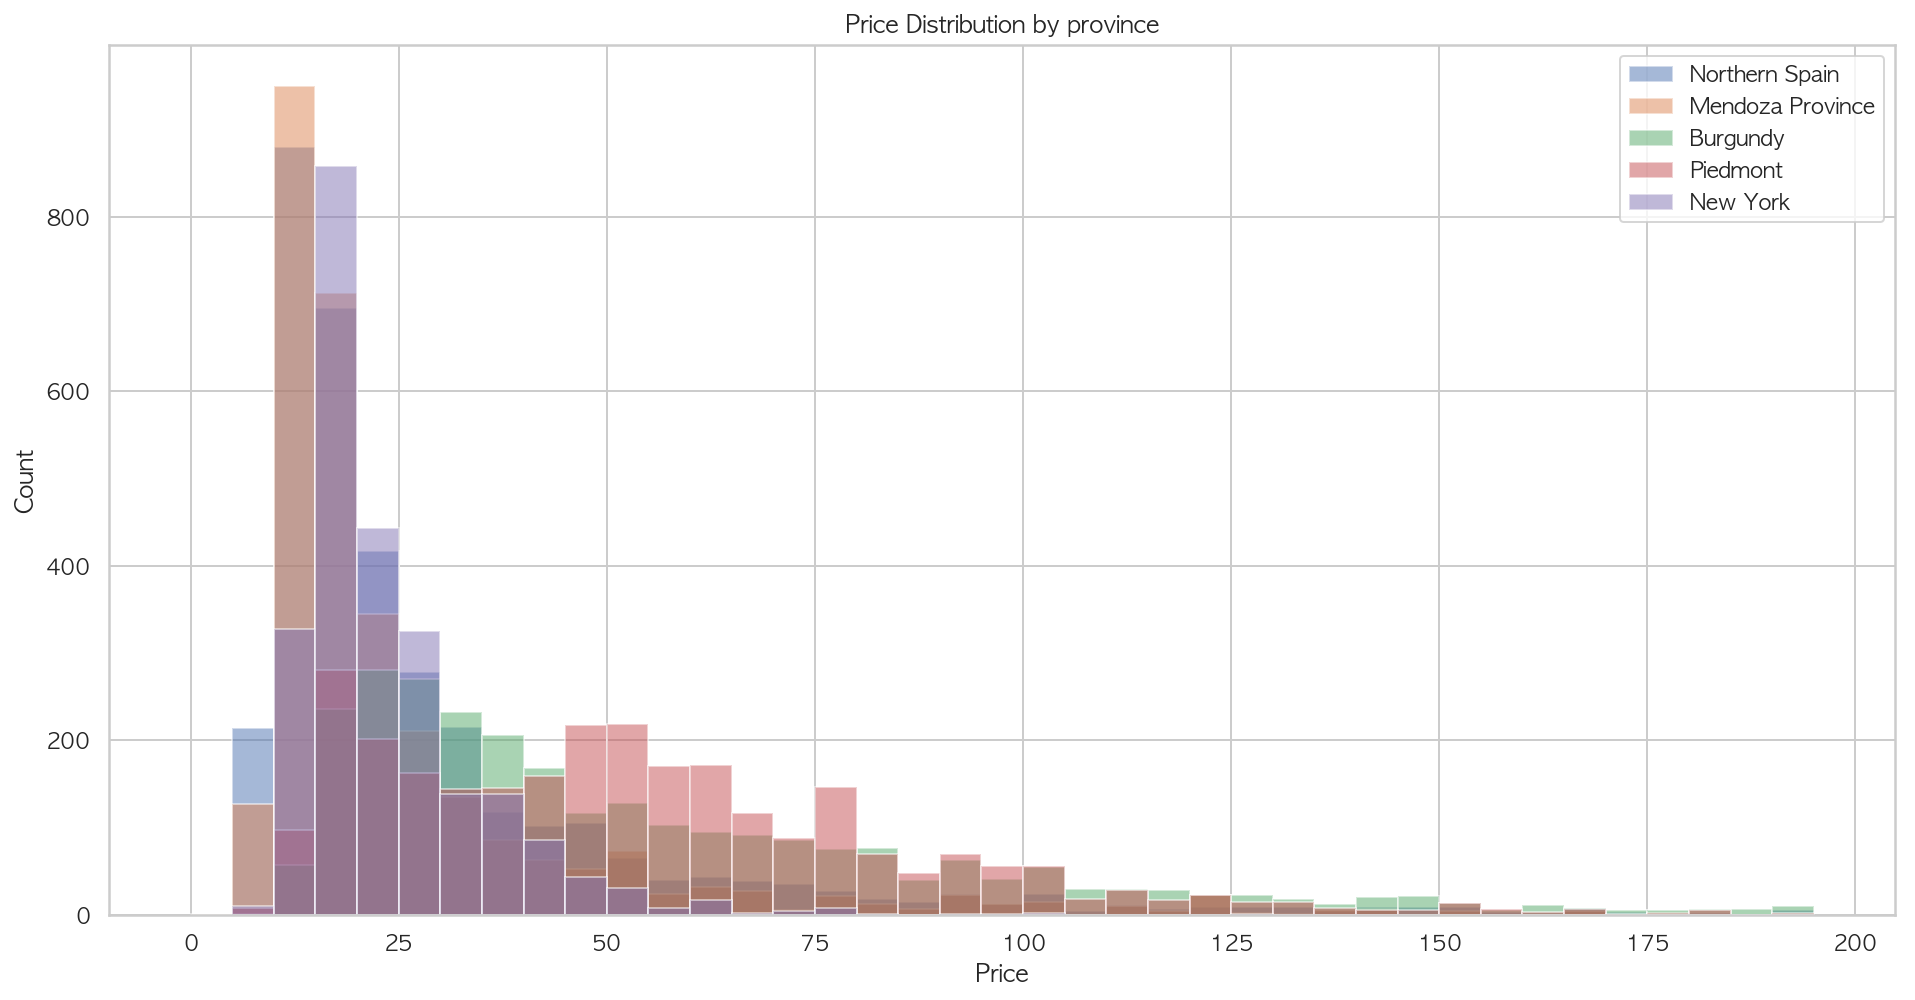

In [38]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in province.index[5:10]:
    plt.hist(train_df.loc[train_df['province'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by province')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Box plot

In [39]:
top10_province = province.index[:10]

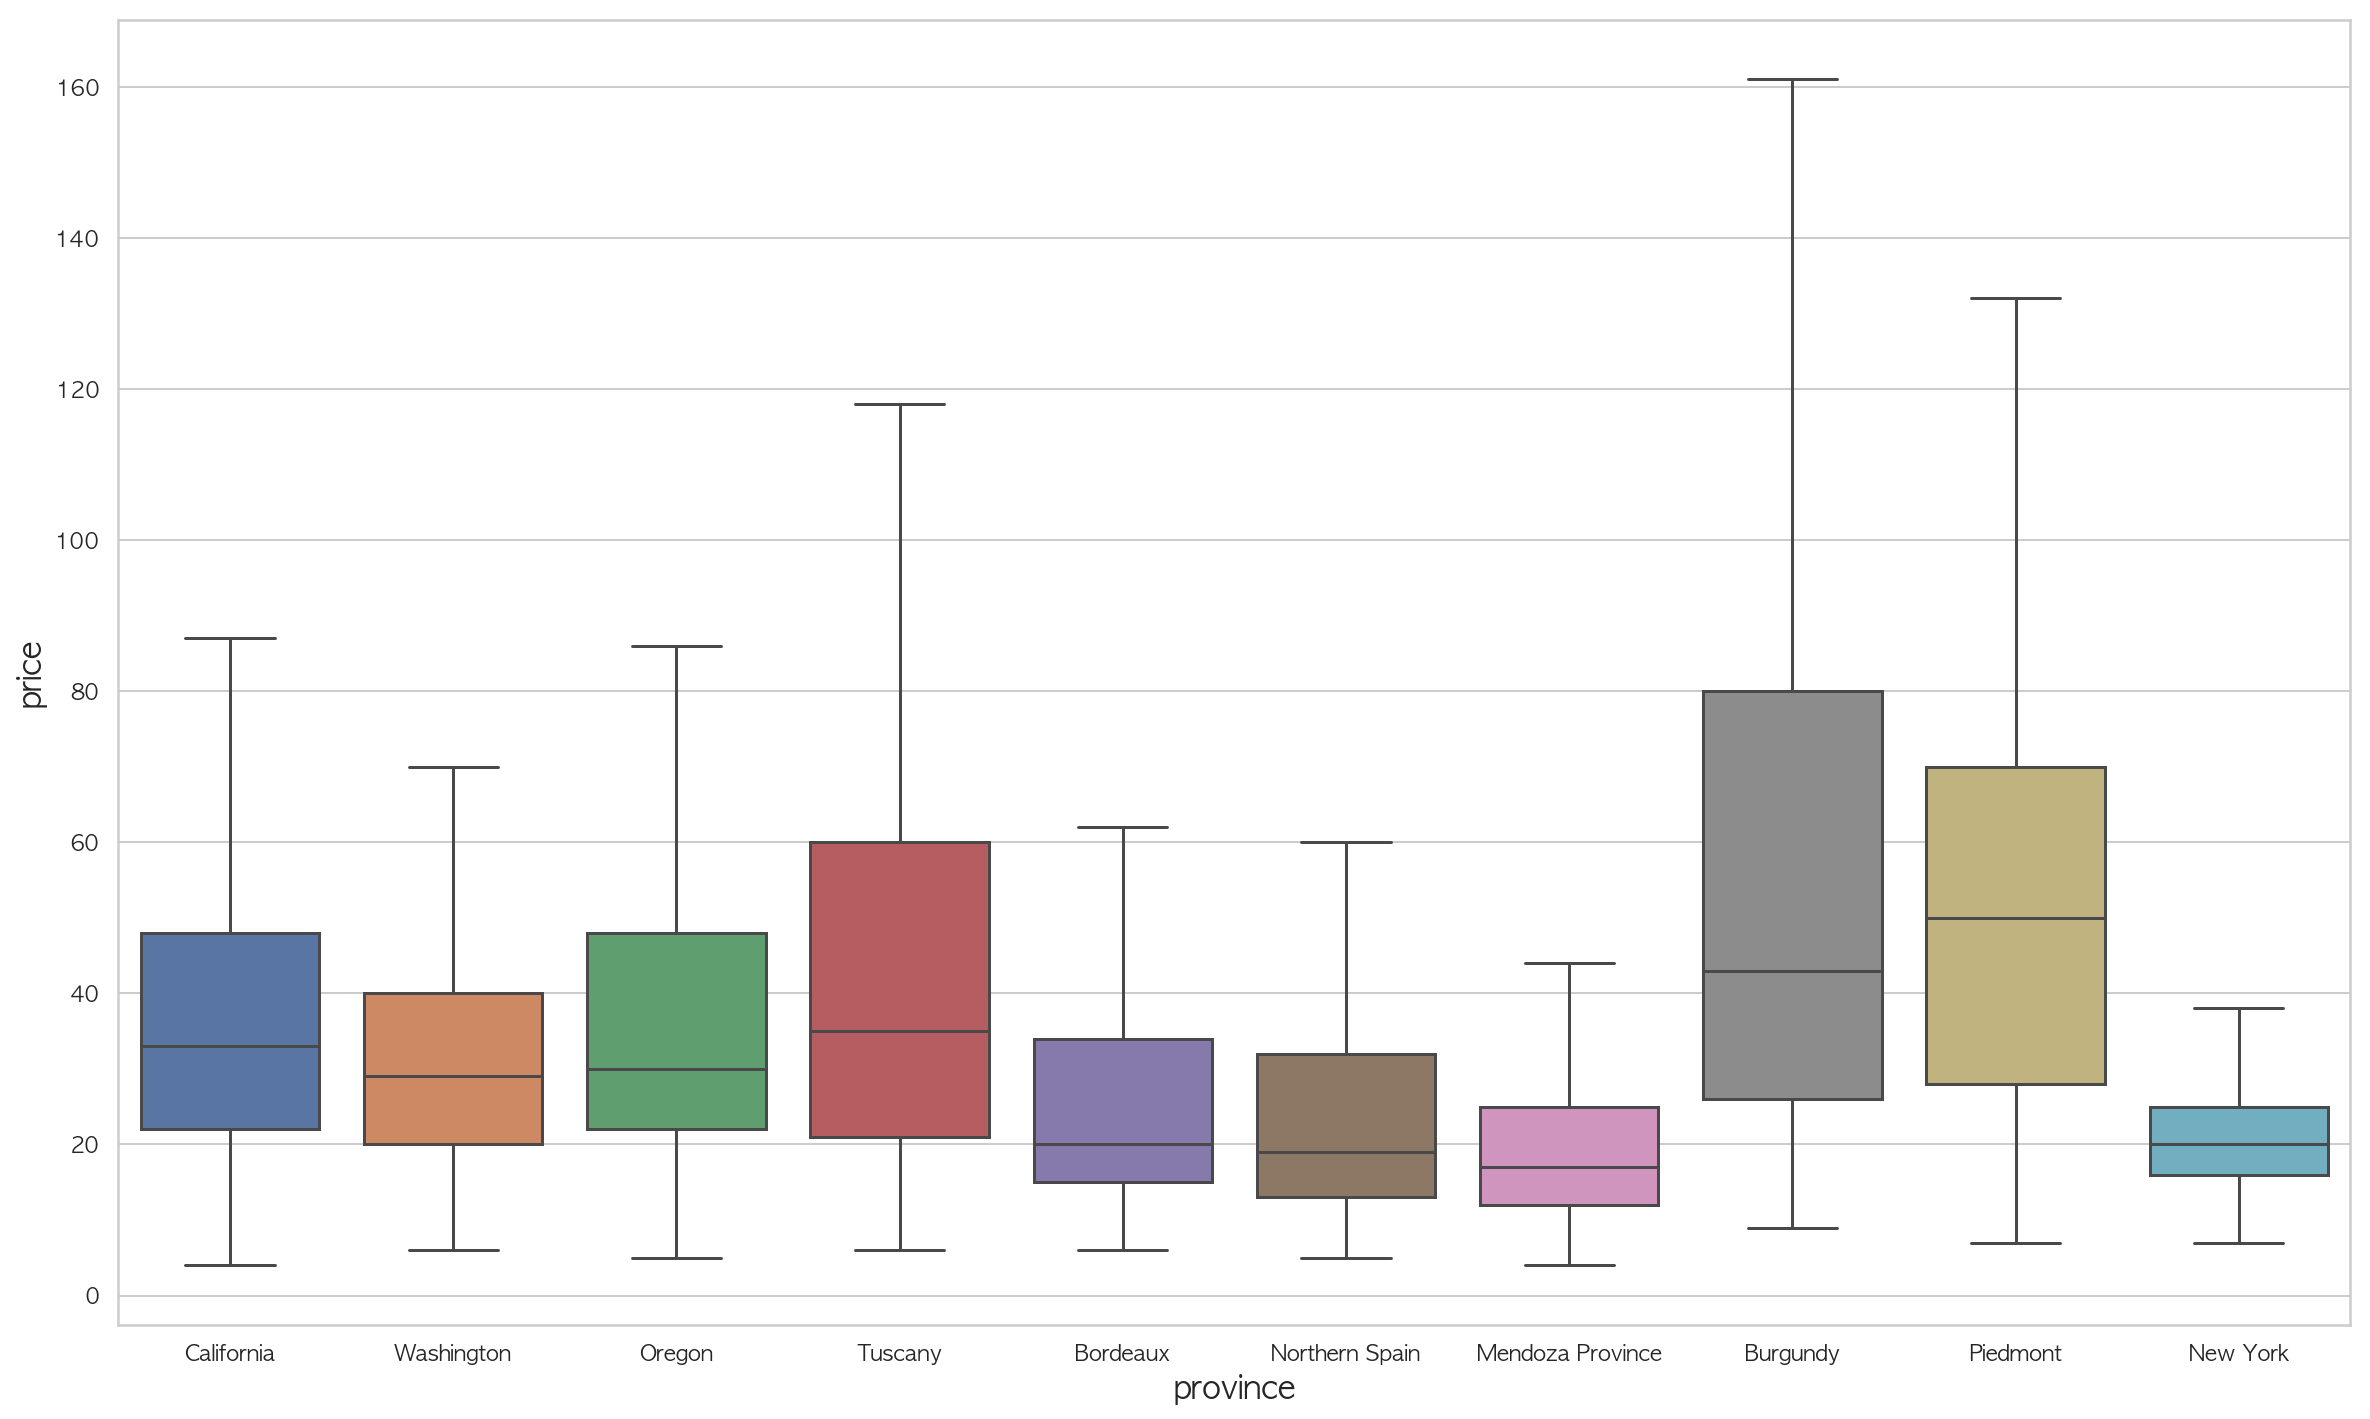

In [40]:
plt.figure(figsize=(20, 12))
sns.boxplot(x='province', y='price',
            data=train_df[train_df['province'].isin(top10_province)], 
            showfliers=False, 
            order=top10_province)
plt.xlabel('province', fontsize=16)
plt.ylabel('price', fontsize=16)

plt.show()

#### Missing value

In [41]:
missing_value(train_df, 'province')

Shape of Dataset: (111538, 13)
Missing value of province
NaN count	 0
NaN rate	 0.0%


---

### `region_1`

#### Distribution

In [42]:
train_df['region_1'].nunique()

1204

`province`를 작은 단위로 나누는 지역 분류 feature로 수많은 1,204개의 카테고리가 있습니다.

In [43]:
region_1 = train_df['region_1'].value_counts()

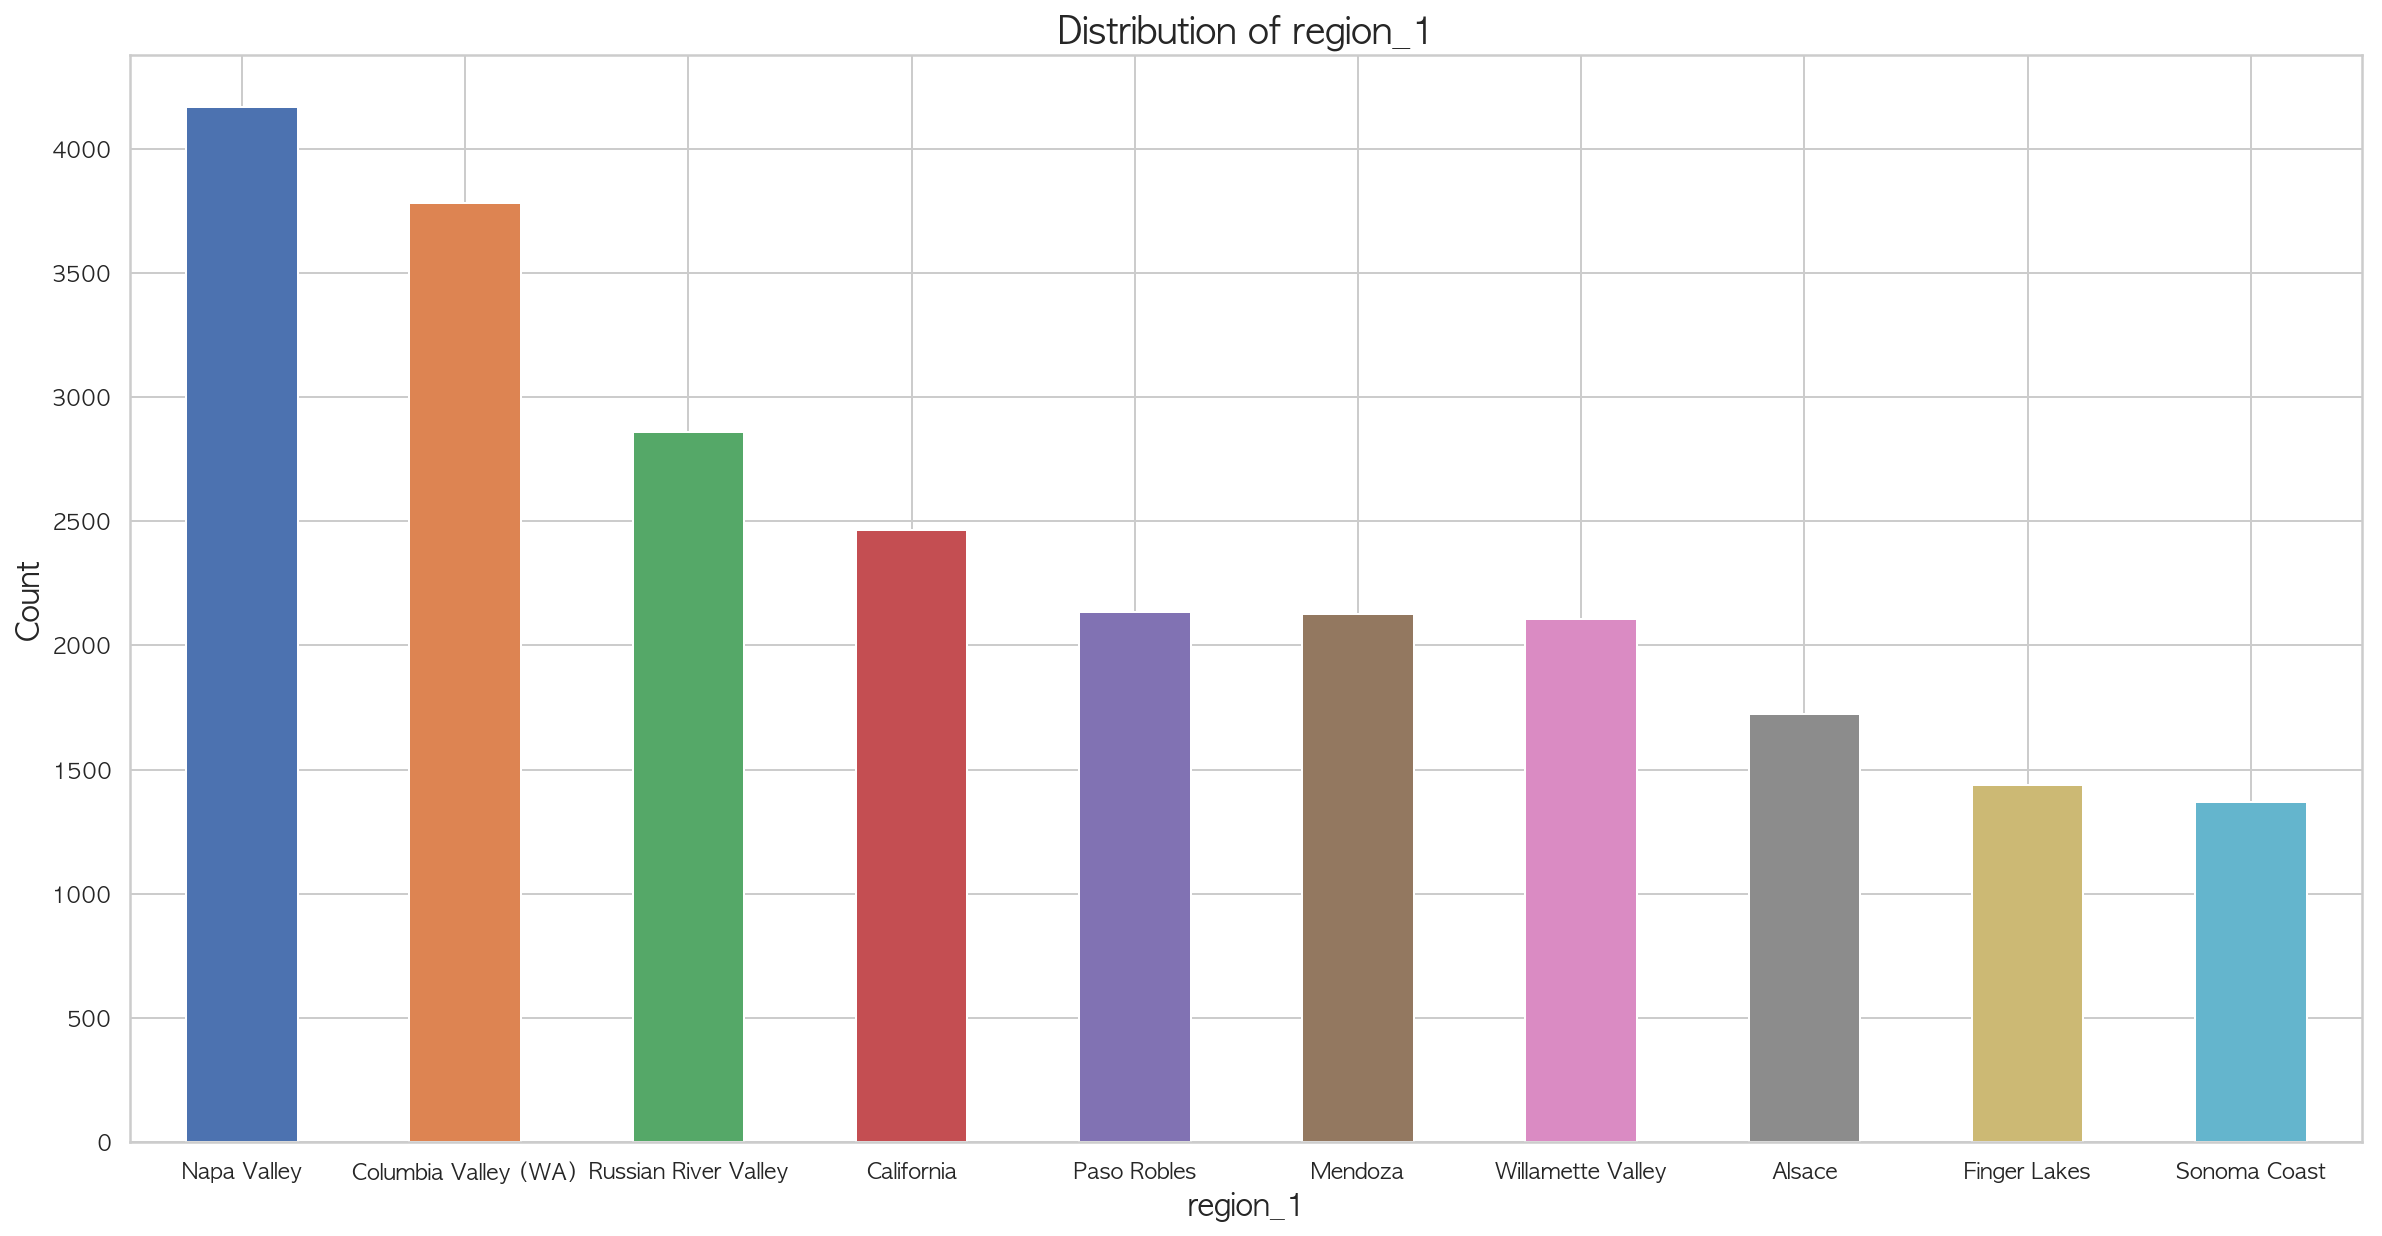

In [44]:
region_1[:10].plot(kind='bar', figsize=(20, 10), rot=0)
plt.title('Distribution of region_1', fontsize=18)
plt.xlabel('region_1', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

##### Napa Valley, Columbia Valley (WA), Russian River Valley, California, Paso Robles

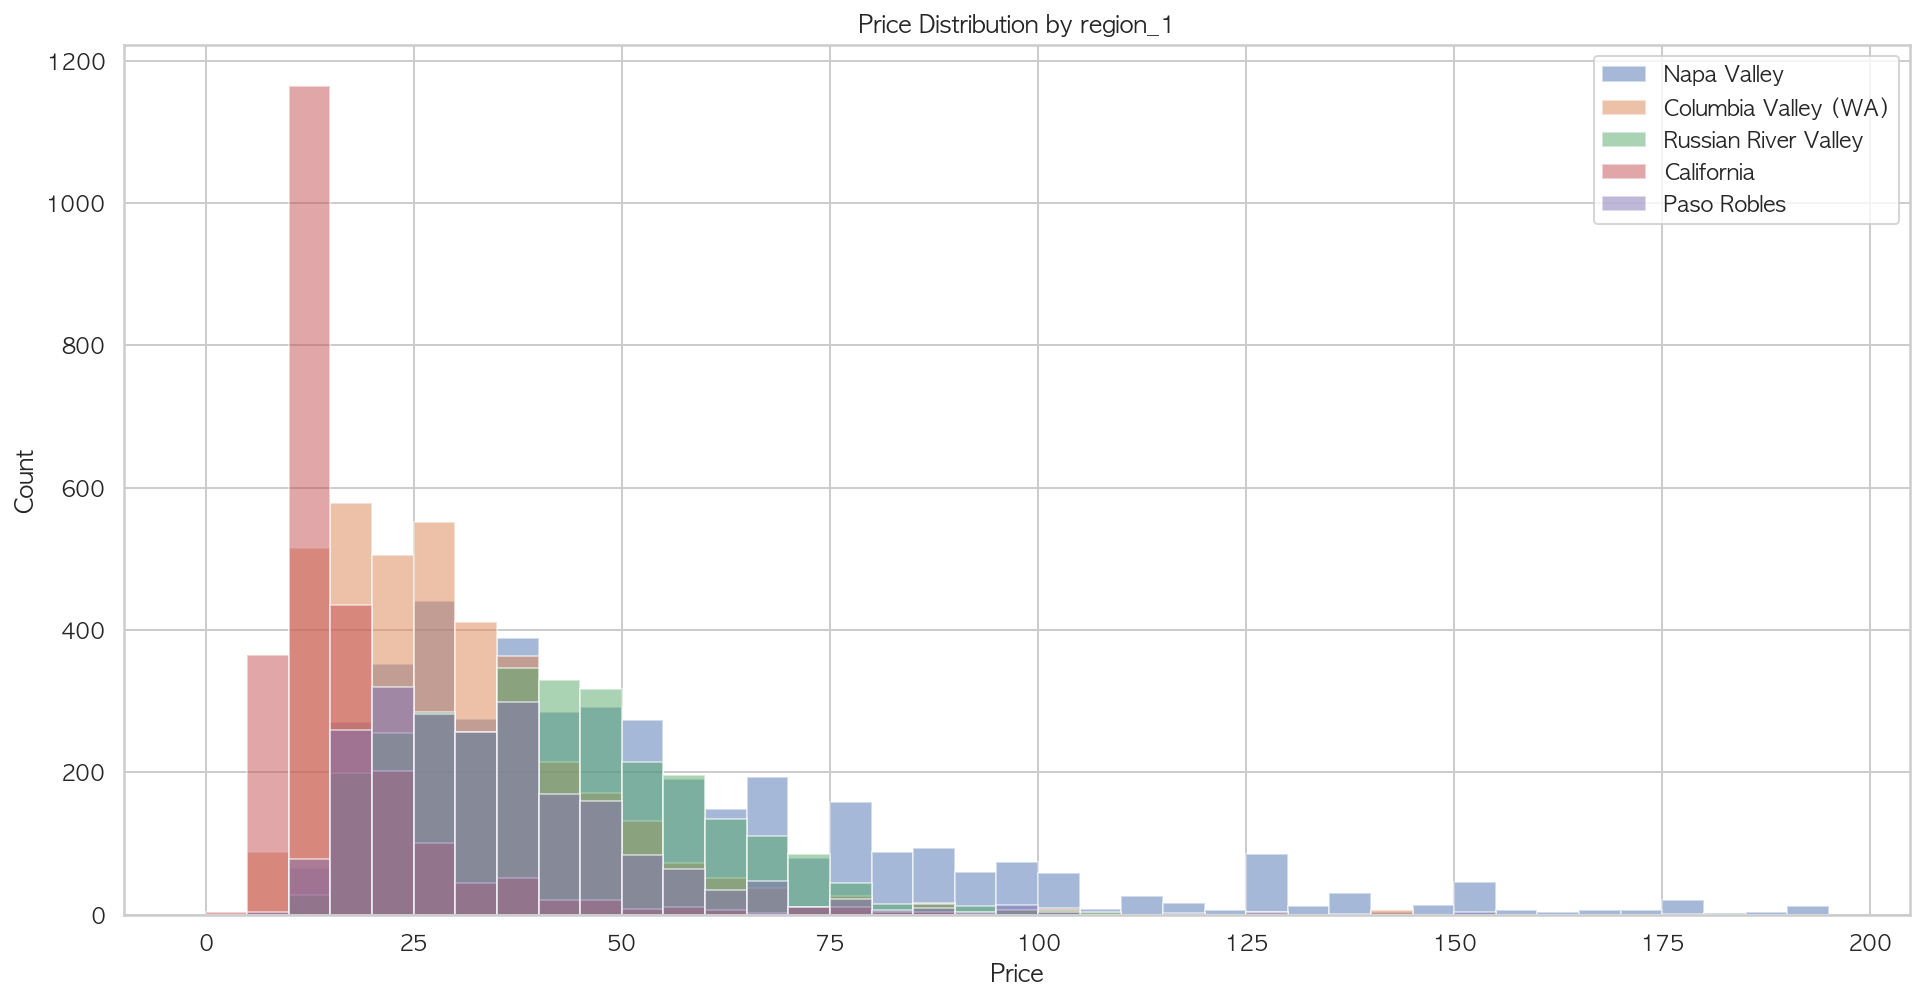

In [45]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in region_1.index[:5]:
    plt.hist(train_df.loc[train_df['region_1'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by region_1')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

##### Mendoza, Willamette Valley, Alsace, Finger Lakes, Sonoma Coast

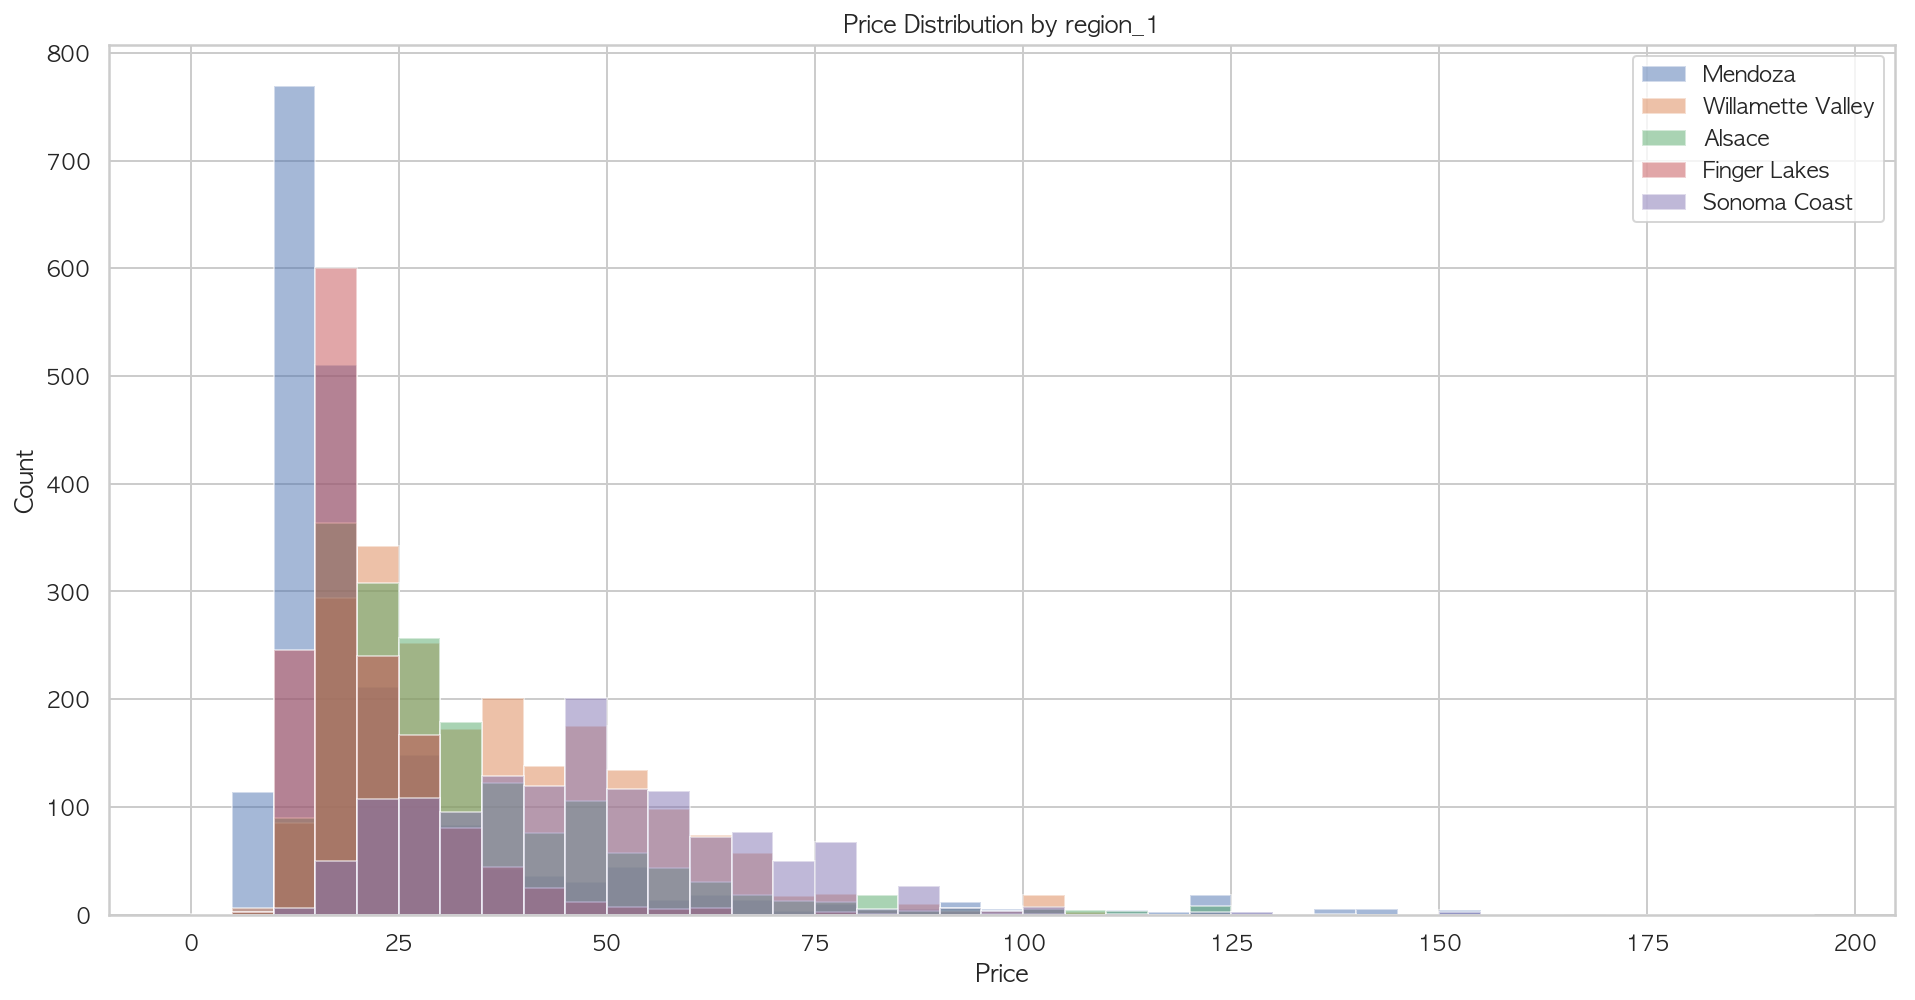

In [46]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in region_1.index[5:10]:
    plt.hist(train_df.loc[train_df['region_1'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by region_1')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Box plot

In [47]:
top10_region_1 = region_1.index[:10]
top10_region_1

Index(['Napa Valley', 'Columbia Valley (WA)', 'Russian River Valley',
       'California', 'Paso Robles', 'Mendoza', 'Willamette Valley', 'Alsace',
       'Finger Lakes', 'Sonoma Coast'],
      dtype='object')

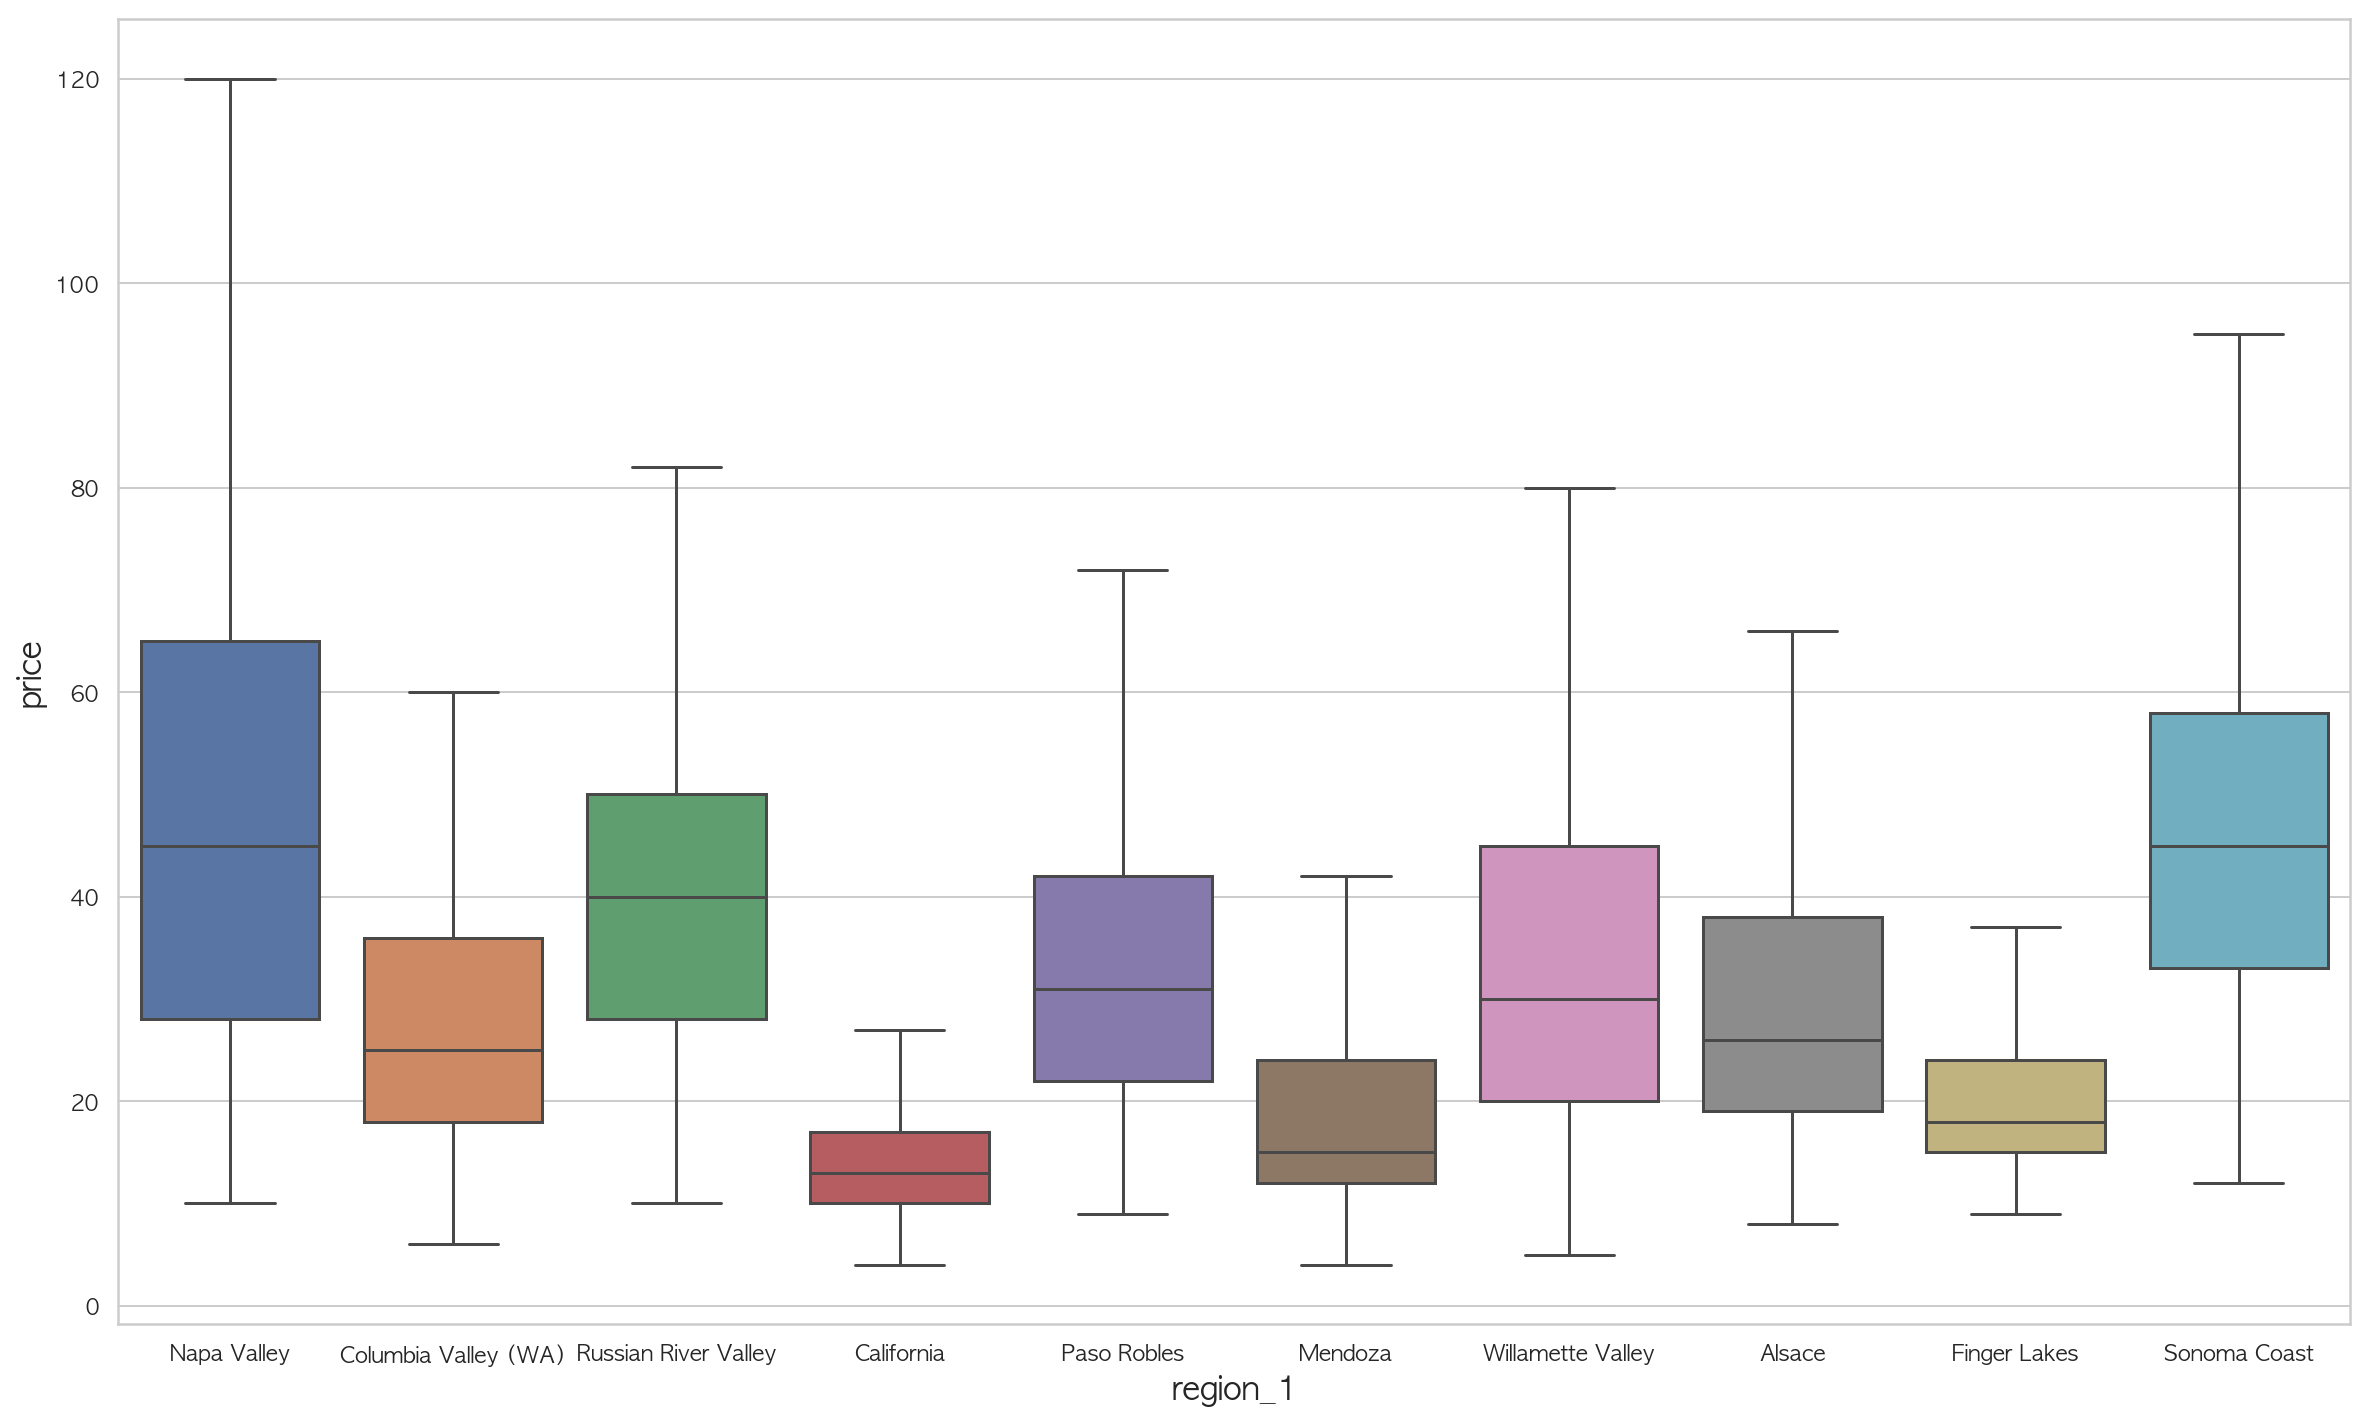

In [48]:
plt.figure(figsize=(20, 12))
sns.boxplot(x='region_1', y='price',
            data=train_df[train_df['region_1'].isin(top10_region_1)], 
            showfliers=False, 
            order=top10_region_1
            )
plt.xlabel('region_1', fontsize=16)
plt.ylabel('price', fontsize=16)

plt.show()

#### Missing value

In [49]:
missing_value(train_df, 'region_1')

Shape of Dataset: (111538, 13)
Missing value of region_1
NaN count	 17958
NaN rate	 16.1%


In [50]:
train_df['region_1'].fillna('unknown', inplace=True)

---

### `region_2` : DROP
- `region_2`는 누락 데이터가 상당히 많으면서도(약 58%) `region_1`과 중복되는 데이터가 많은 feature 입니다.
- 데이터가 중복될 경우 `multicolinearity` 문제로 인해 훈련에 부정적인 영향을 미칠 수 있습니다.
- 또한 `region_1` 만으로도 소분류의 지역 단위 분포를 반영할 수 있을 것으로 판단하여 `region_2`는 train set에서 제외하기로 결정했습니다.

In [51]:
region_2 = train_df['region_2'].value_counts()

In [52]:
missing_value(train_df, 'region_2')

Shape of Dataset: (111538, 13)
Missing value of region_2
NaN count	 64970
NaN rate	 58.25%


대부분 `region_1`에도 포함되어 있는 지역군입니다.

In [53]:
region_2 = train_df['region_2'].value_counts()
duplicated_region = [r for r in region_2.index if r in region_1.index]
print('region_2와 region_1의 중복되는 지역:', duplicated_region)

region_2와 region_1의 중복되는 지역: ['Central Coast', 'Sonoma', 'Columbia Valley', 'Napa', 'Willamette Valley', 'California Other', 'Finger Lakes', 'Sierra Foothills', 'Napa-Sonoma', 'Central Valley', 'Southern Oregon', 'Oregon Other', 'Long Island', 'North Coast', 'South Coast']


region_2의 카테고리 값의 88%가 region_1에도 존재합니다.

In [54]:
duplicated_rate = len(duplicated_region) / len(region_2.index) * 100
print("region_2와 region_1의 중복 비율:", str(round(duplicated_rate, 2)) + '%')

region_2와 region_1의 중복 비율: 88.24%


완전히 중복되지 않는 값도 단순히 `region_1` 값에 'Other'이 추가된 값으로 확인되었습니다.

In [55]:
for i in region_2.index:
    if i not in region_1.index:
        print(i)

Washington Other
New York Other


In [56]:
train_df = train_df.drop(columns=['region_2'])

---

### `Designation`
- The vineyard within the winery where the grapes that made the wine are from
- 와이너리에서 와인을 만드는데 사용된 포도가 재배된 포도원(Vineyard)

#### Distribution

각 지역에서 포도가 재배된 포도원(농장) 입니다. 지역에 관한 feature 중 가장 작은 단위로, 전체 데이터 수의 1/3 수준에 미칠 정도로 상당히 많은 카테고리 수가 존재합니다.

In [57]:
train_df['designation'].nunique()

35753

In [58]:
designation = train_df['designation'].value_counts()
designation.index[:30]

Index(['Reserve', 'Estate', 'Reserva', 'Estate Grown', 'Riserva', 'Brut',
       'Dry', 'Estate Bottled', 'Crianza', 'Vieilles Vignes', 'Gran Reserva',
       'Brut Rosé', 'Old Vine', 'Tradition', 'Extra Dry', 'Rosé of', 'Rosé',
       'Réserve', 'Single Vineyard', 'Estate Reserve', 'Bien Nacido Vineyard',
       'Late Harvest', 'Unoaked', 'Barrel Select', 'Classic', 'Old Vines',
       'Estate Vineyard', 'Vintage', 'Barrel Fermented', 'Grand Reserve'],
      dtype='object')

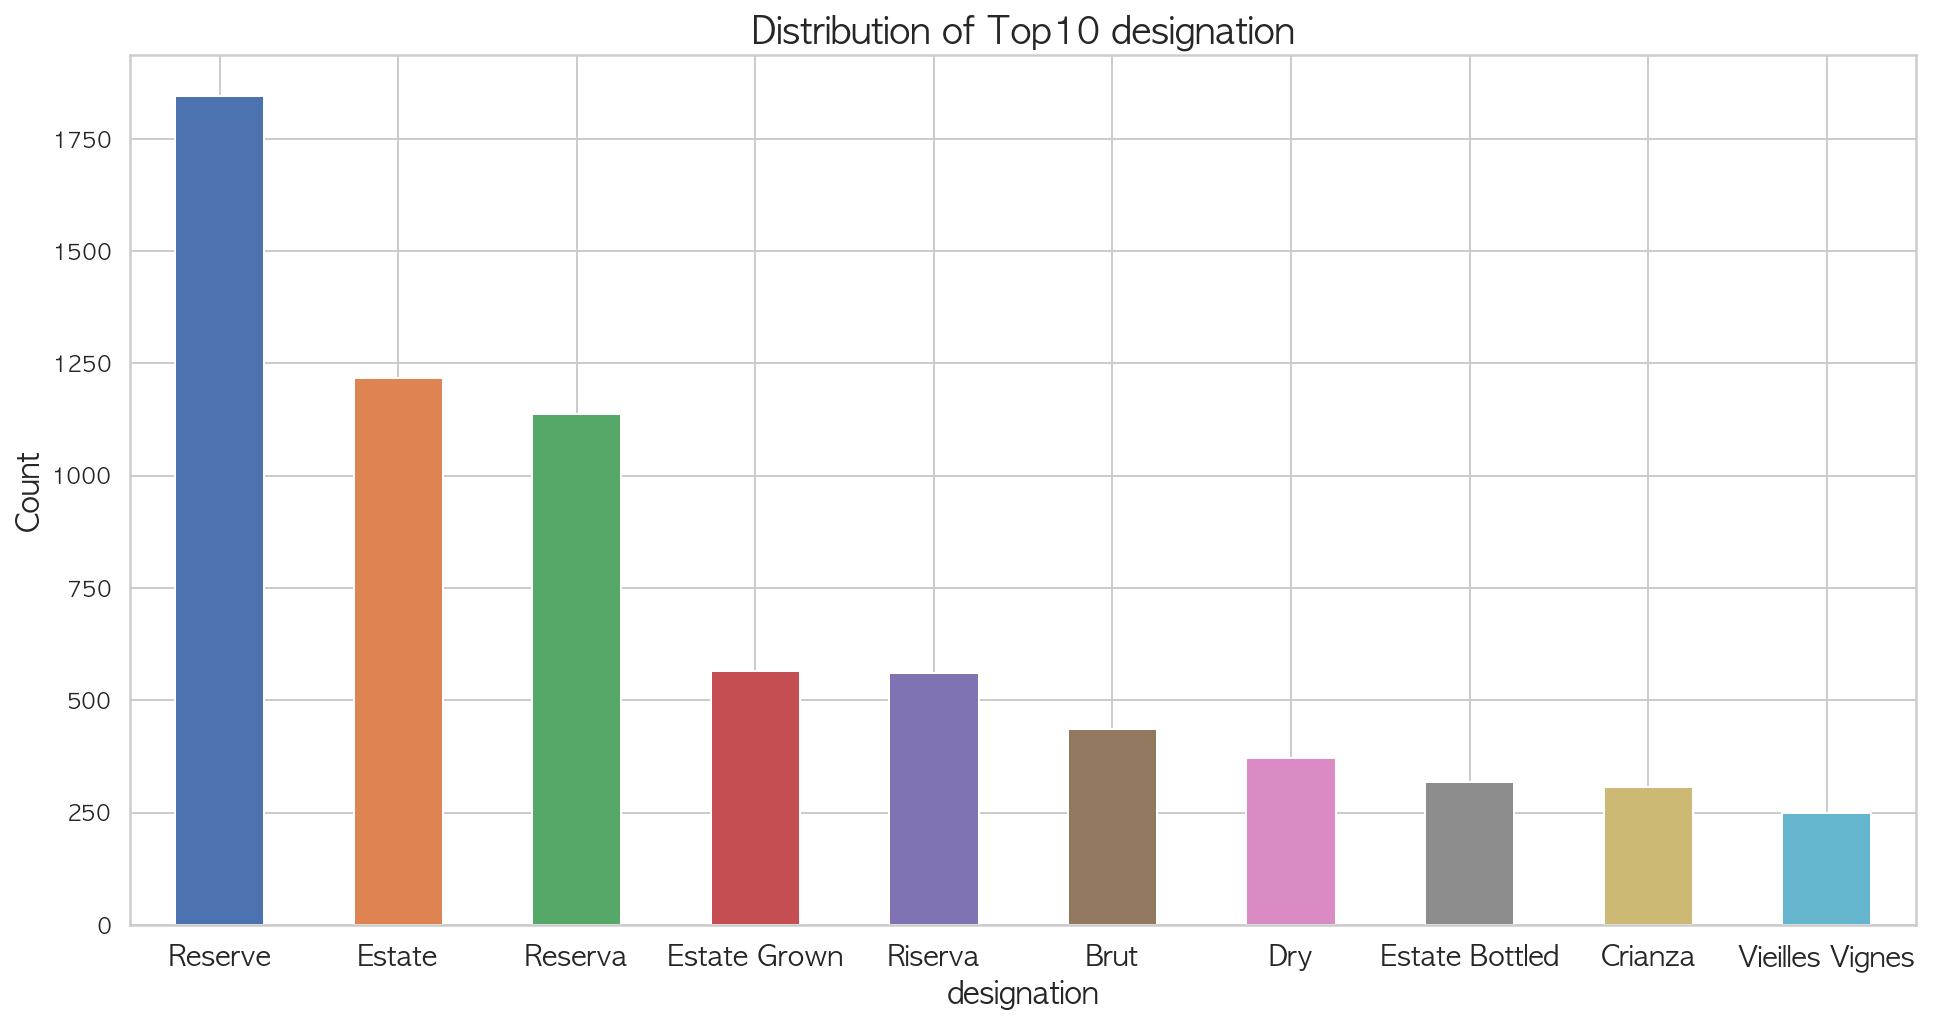

In [59]:
designation[:10].plot(kind='bar', figsize=(16, 8), rot=0)
plt.title('Distribution of Top10 designation', fontsize=18)
plt.xticks(fontsize=14)
plt.xlabel('designation', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

##### Reserve, Estate, Reserva, Estate Grown, Riserva

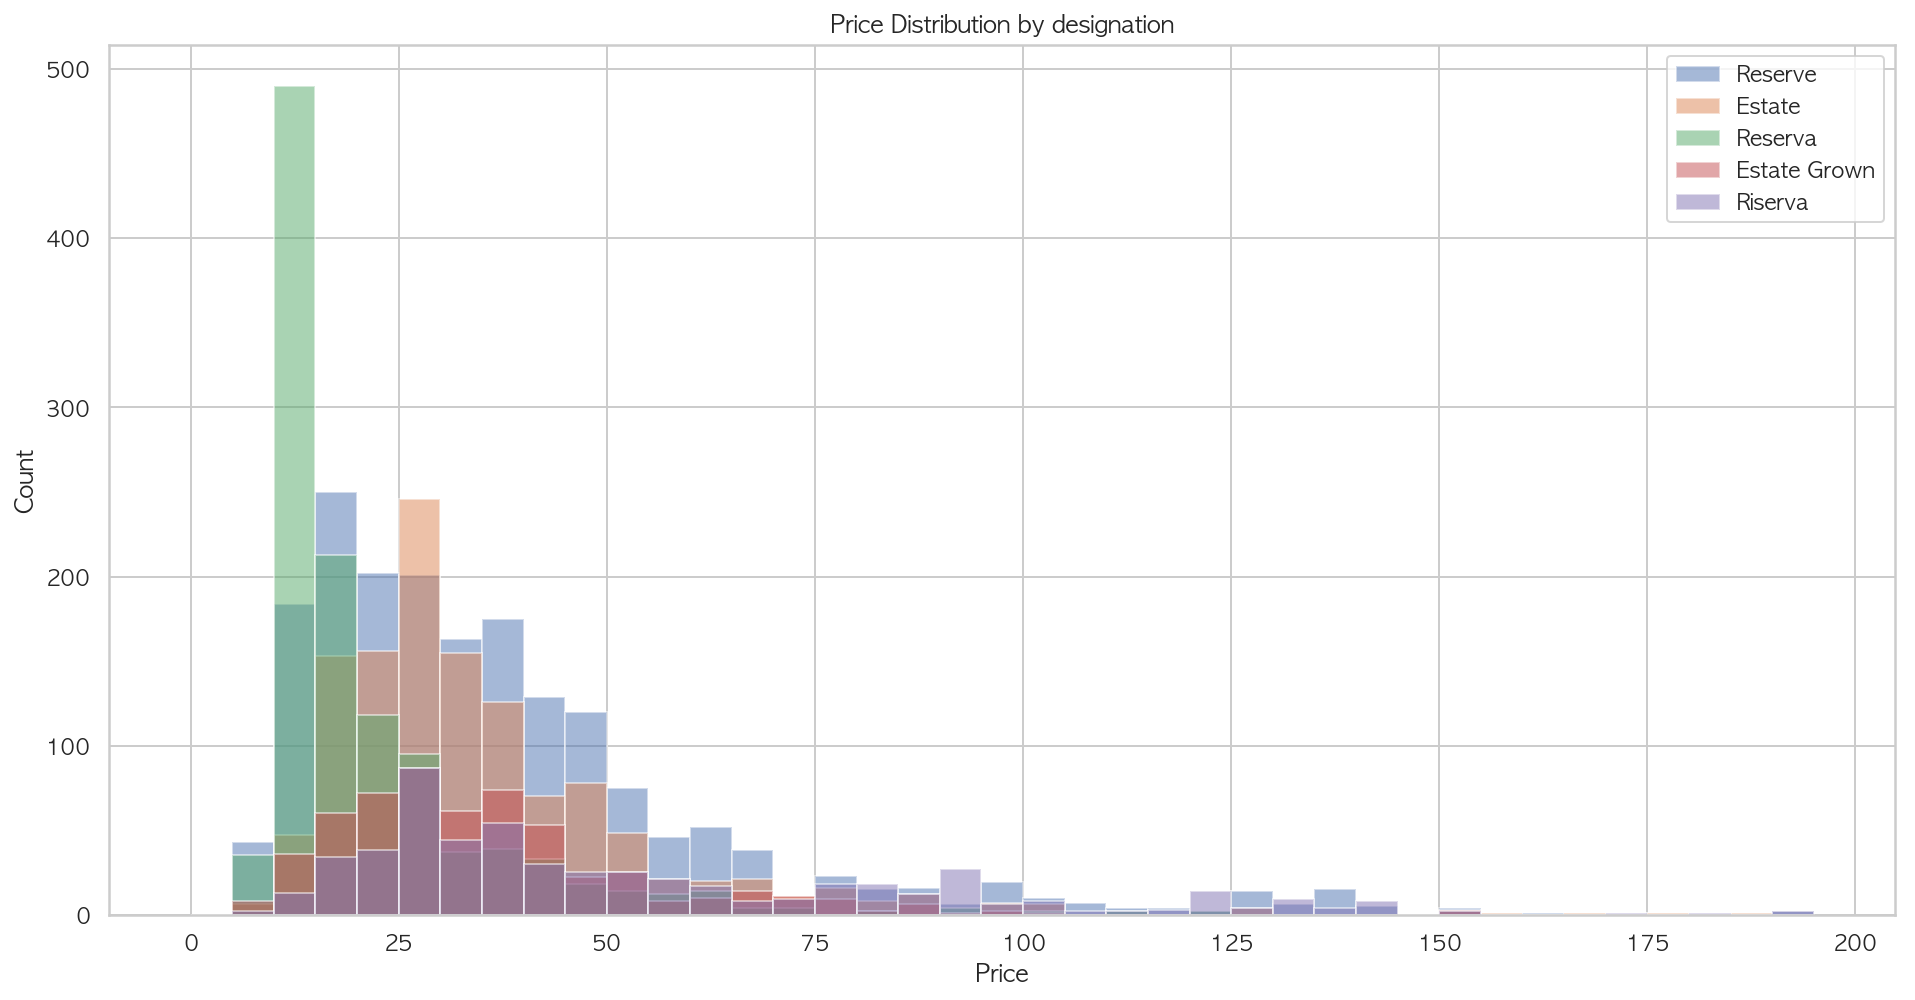

In [60]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in designation.index[:5]:
    plt.hist(train_df.loc[train_df['designation'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by designation')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

##### 'Brut', 'Dry', 'Estate Bottled', 'Crianza', 'Vieilles Vignes'

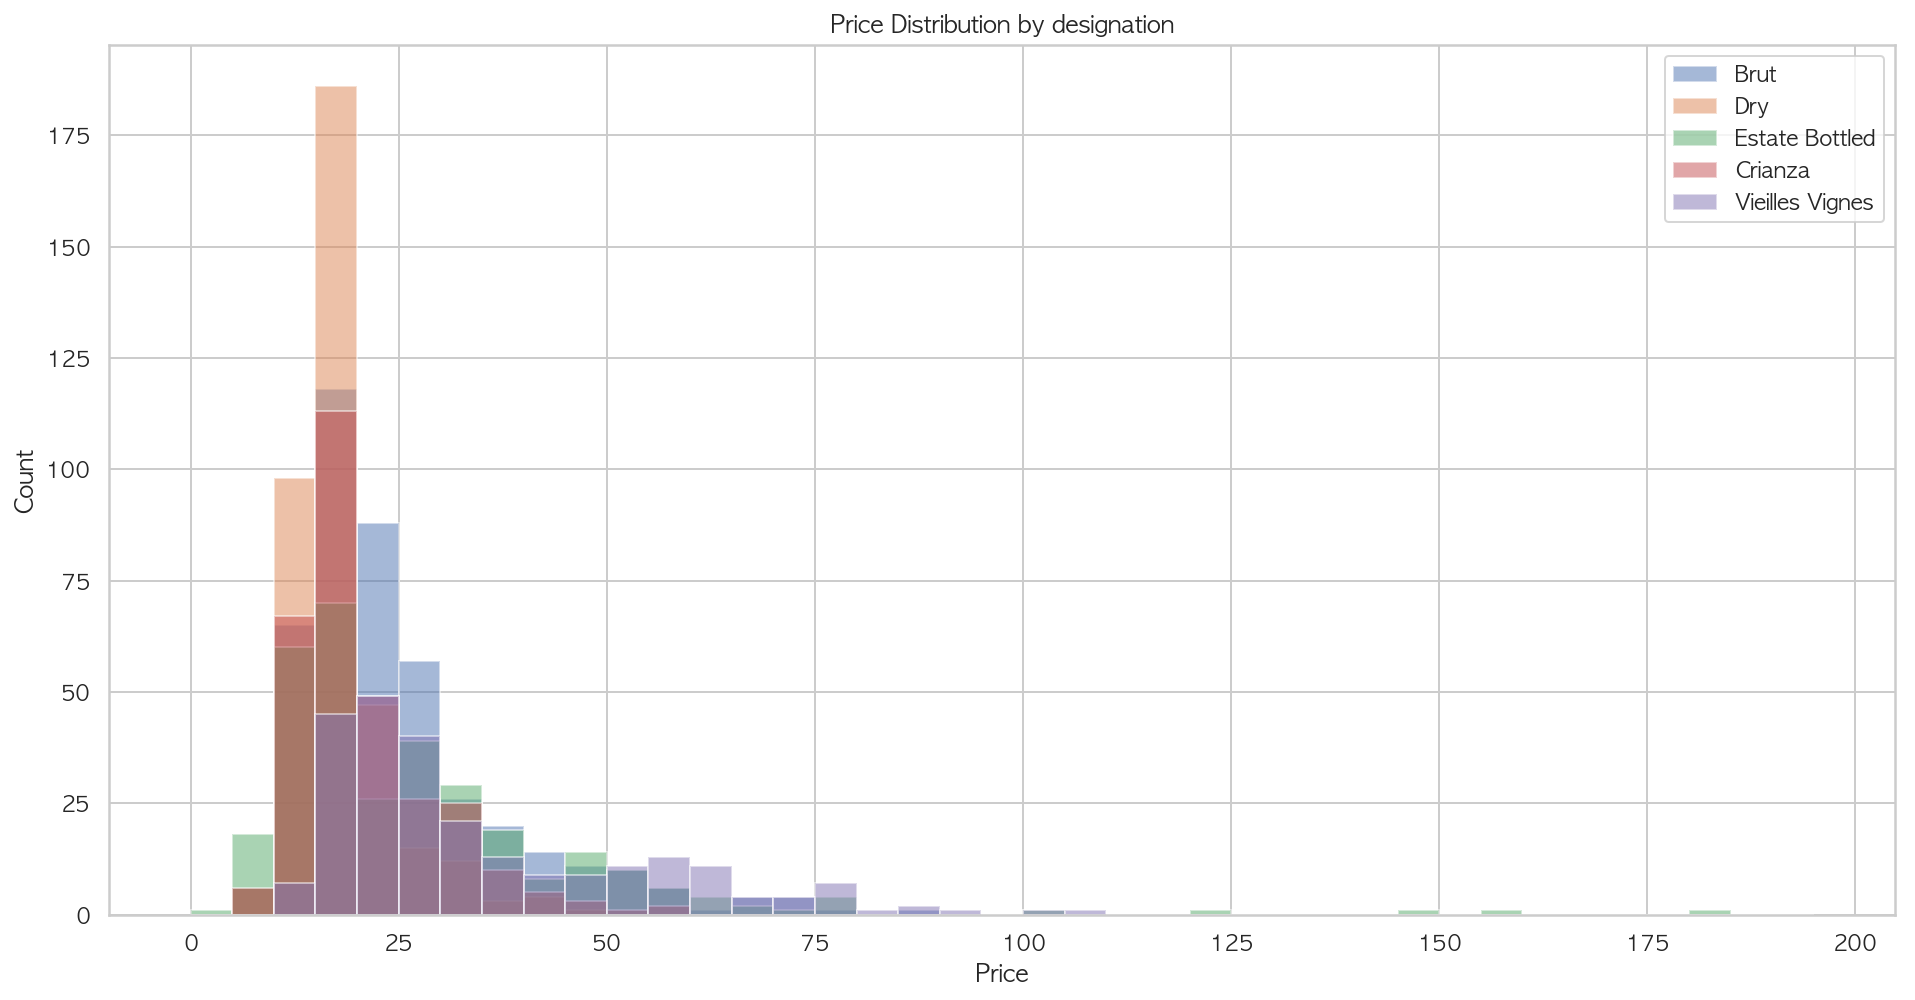

In [61]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in designation.index[5:10]:
    plt.hist(train_df.loc[train_df['designation'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by designation')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

### Issue of `designation` Feature engineering
`designation`에 높은 빈도로 등장하는 값들은 특정한 포도원을 지칭하는 것이 아닌 **포도의 유통 및 관리 방식**을 의미하고 있습니다.
>Reserve(Reserva, Riserva), Estate, Dry, Brut, Crianza ...

- Column의 값들을 확인해보면 위의 단어가 단독적인 카테고리로 존재하기도 하고, 여러가지의 다른 포도원 이름에 포함되어있는 경우가 많습니다.
- 위의 각 개념들은 서로 배타적인 성질을 지니지 않기 때문에 `Estate Reserve`와 같은 형태의 개념도 존재합니다.
- 그리고 위의 개념을 의미하는 단어가 포도원의 이름에 포함되는 경우도 있습니다. ex. 'Estate Riverbend Vineyard'

In [62]:
designation_list = train_df['designation'].fillna('unknown_designation')
designation_list[designation_list.str.contains('Estate')].loc[128624]

'Estate Riverbend Vineyard'

`designation`은 이처럼 개념적인 의미의 카테고리와 특정한 실제의 포도원 이름이 뒤섞여 혼재되어 있는 불순한 상태의 feature입니다.

In [63]:
train_df['designation'].fillna('unknown', inplace=True)

---

### `winery`

#### Distribution

In [64]:
train_df['winery'].nunique()

15843

In [65]:
winery = train_df['winery'].value_counts()

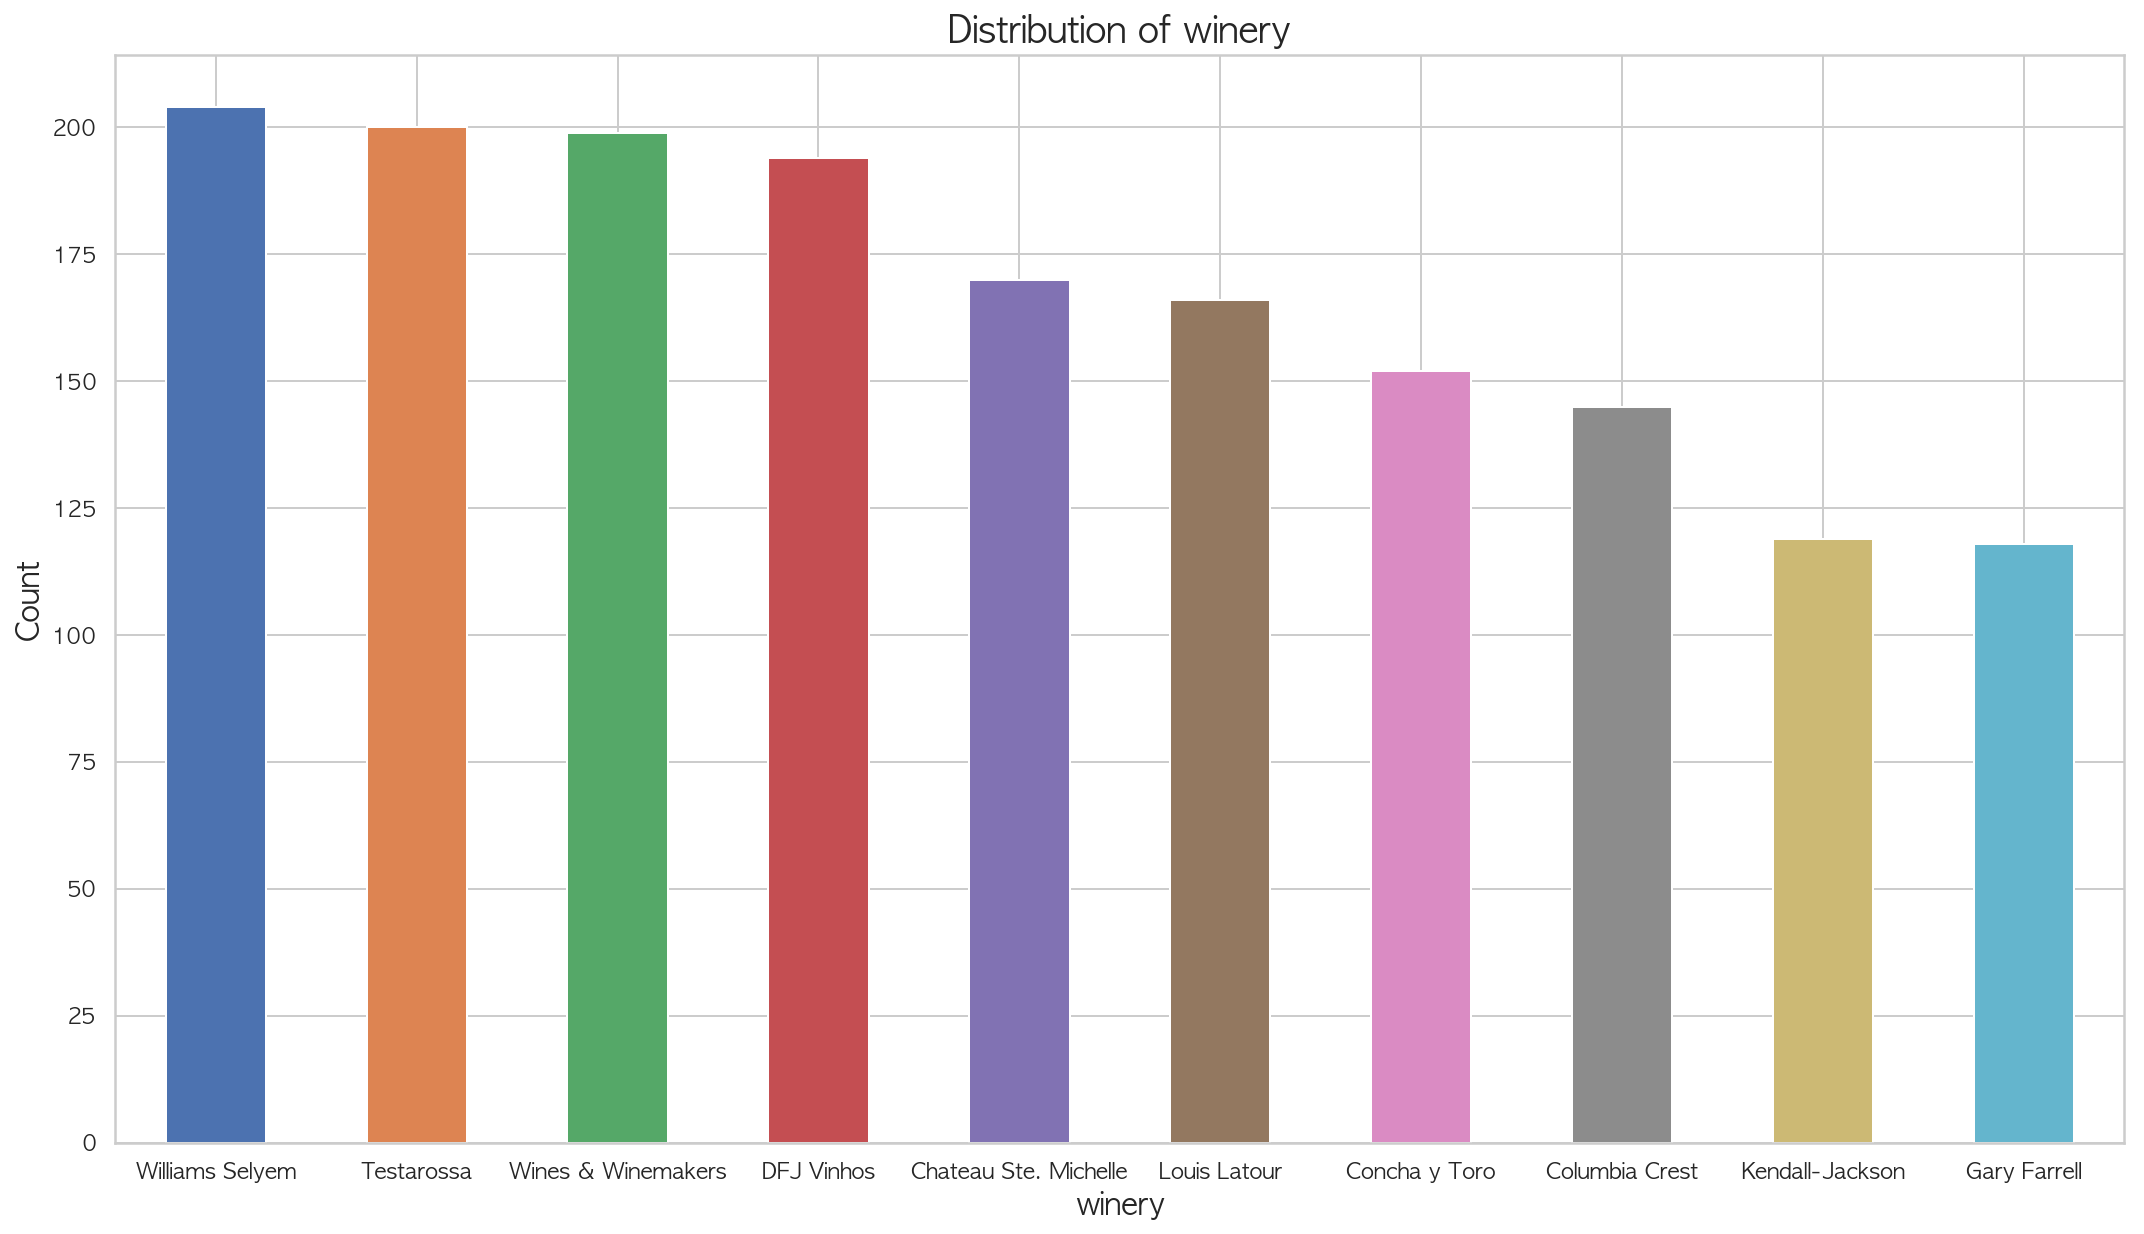

In [66]:
winery[:10].plot(kind='bar', figsize=(18, 10), rot=0)
plt.title('Distribution of winery', fontsize=18)
plt.xlabel('winery', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

##### Williams Selyem, Testarossa, Wines & Winemakers, DFJ Vinhos, Chateau Ste. Michelle

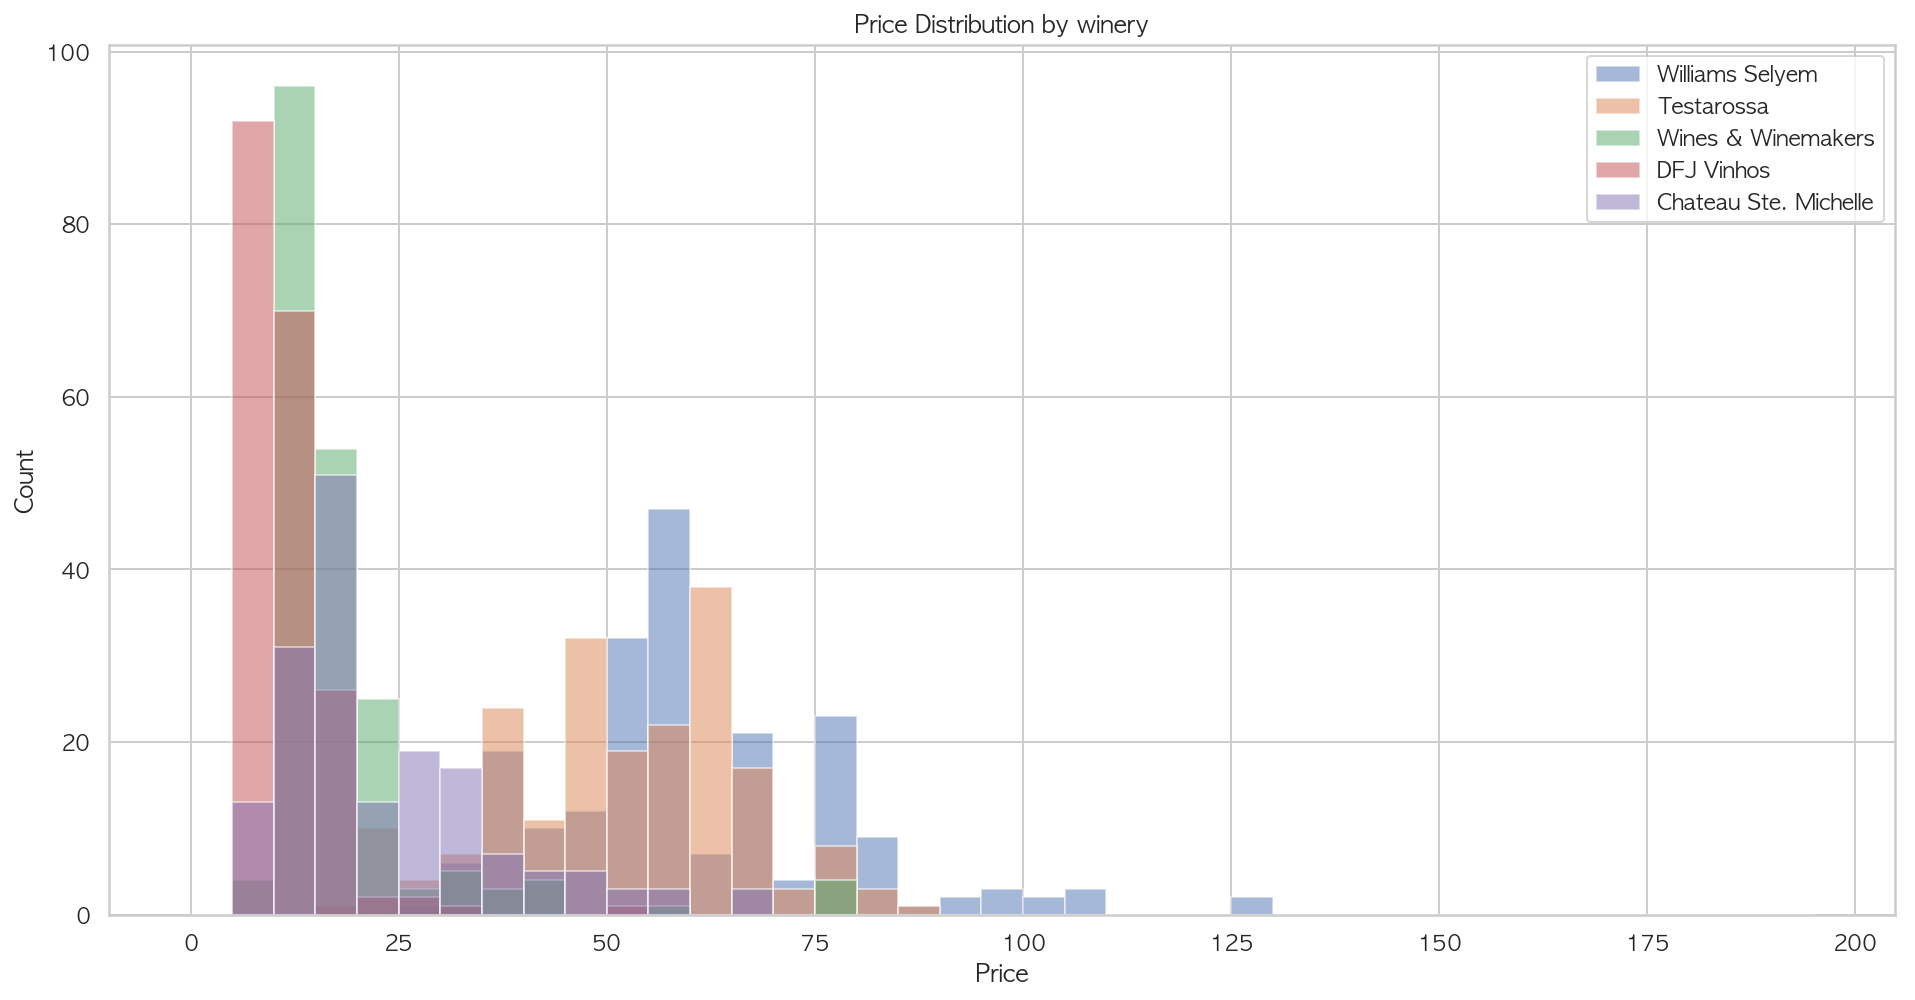

In [67]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in winery.index[:5]:
    plt.hist(train_df.loc[train_df['winery'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by winery')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

##### Louis Latour, Concha y Toro, Columbia Crest, Kendall-Jackson, Gary Farrell

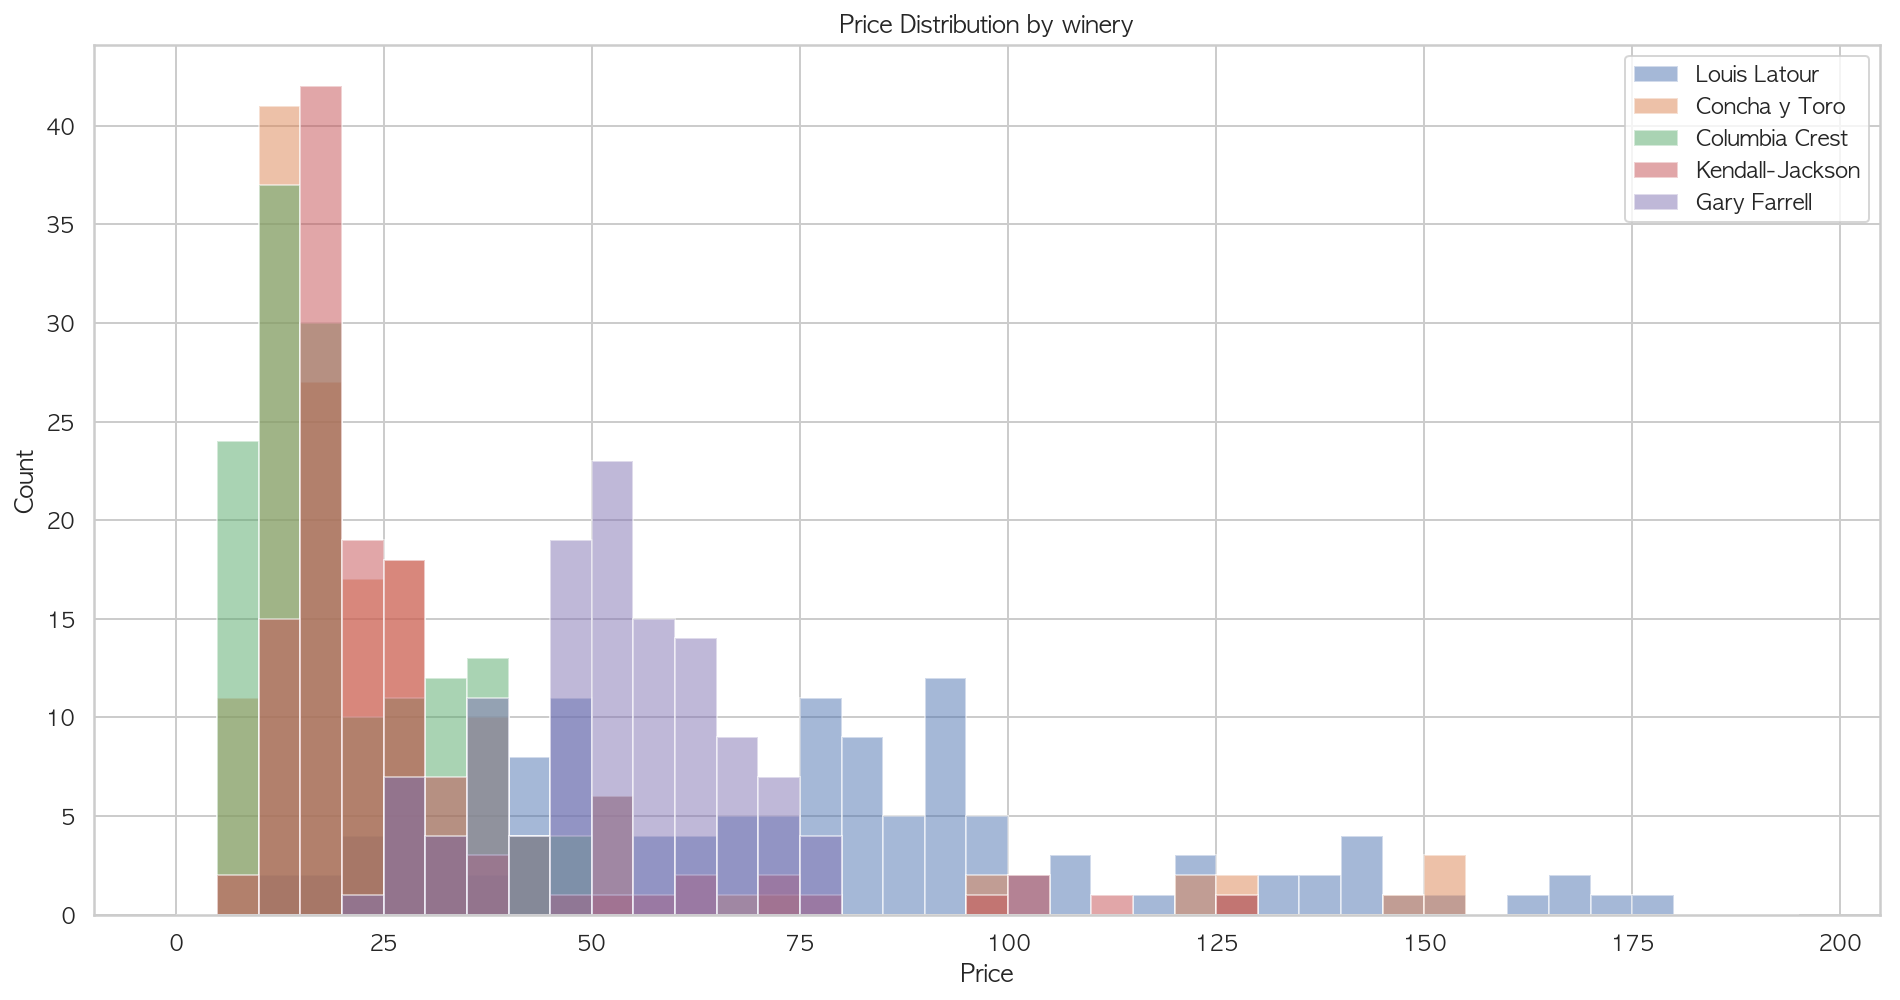

In [68]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in winery.index[5:10]:
    plt.hist(train_df.loc[train_df['winery'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by winery')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Box plot

In [69]:
top10_winery = winery.index[:10]

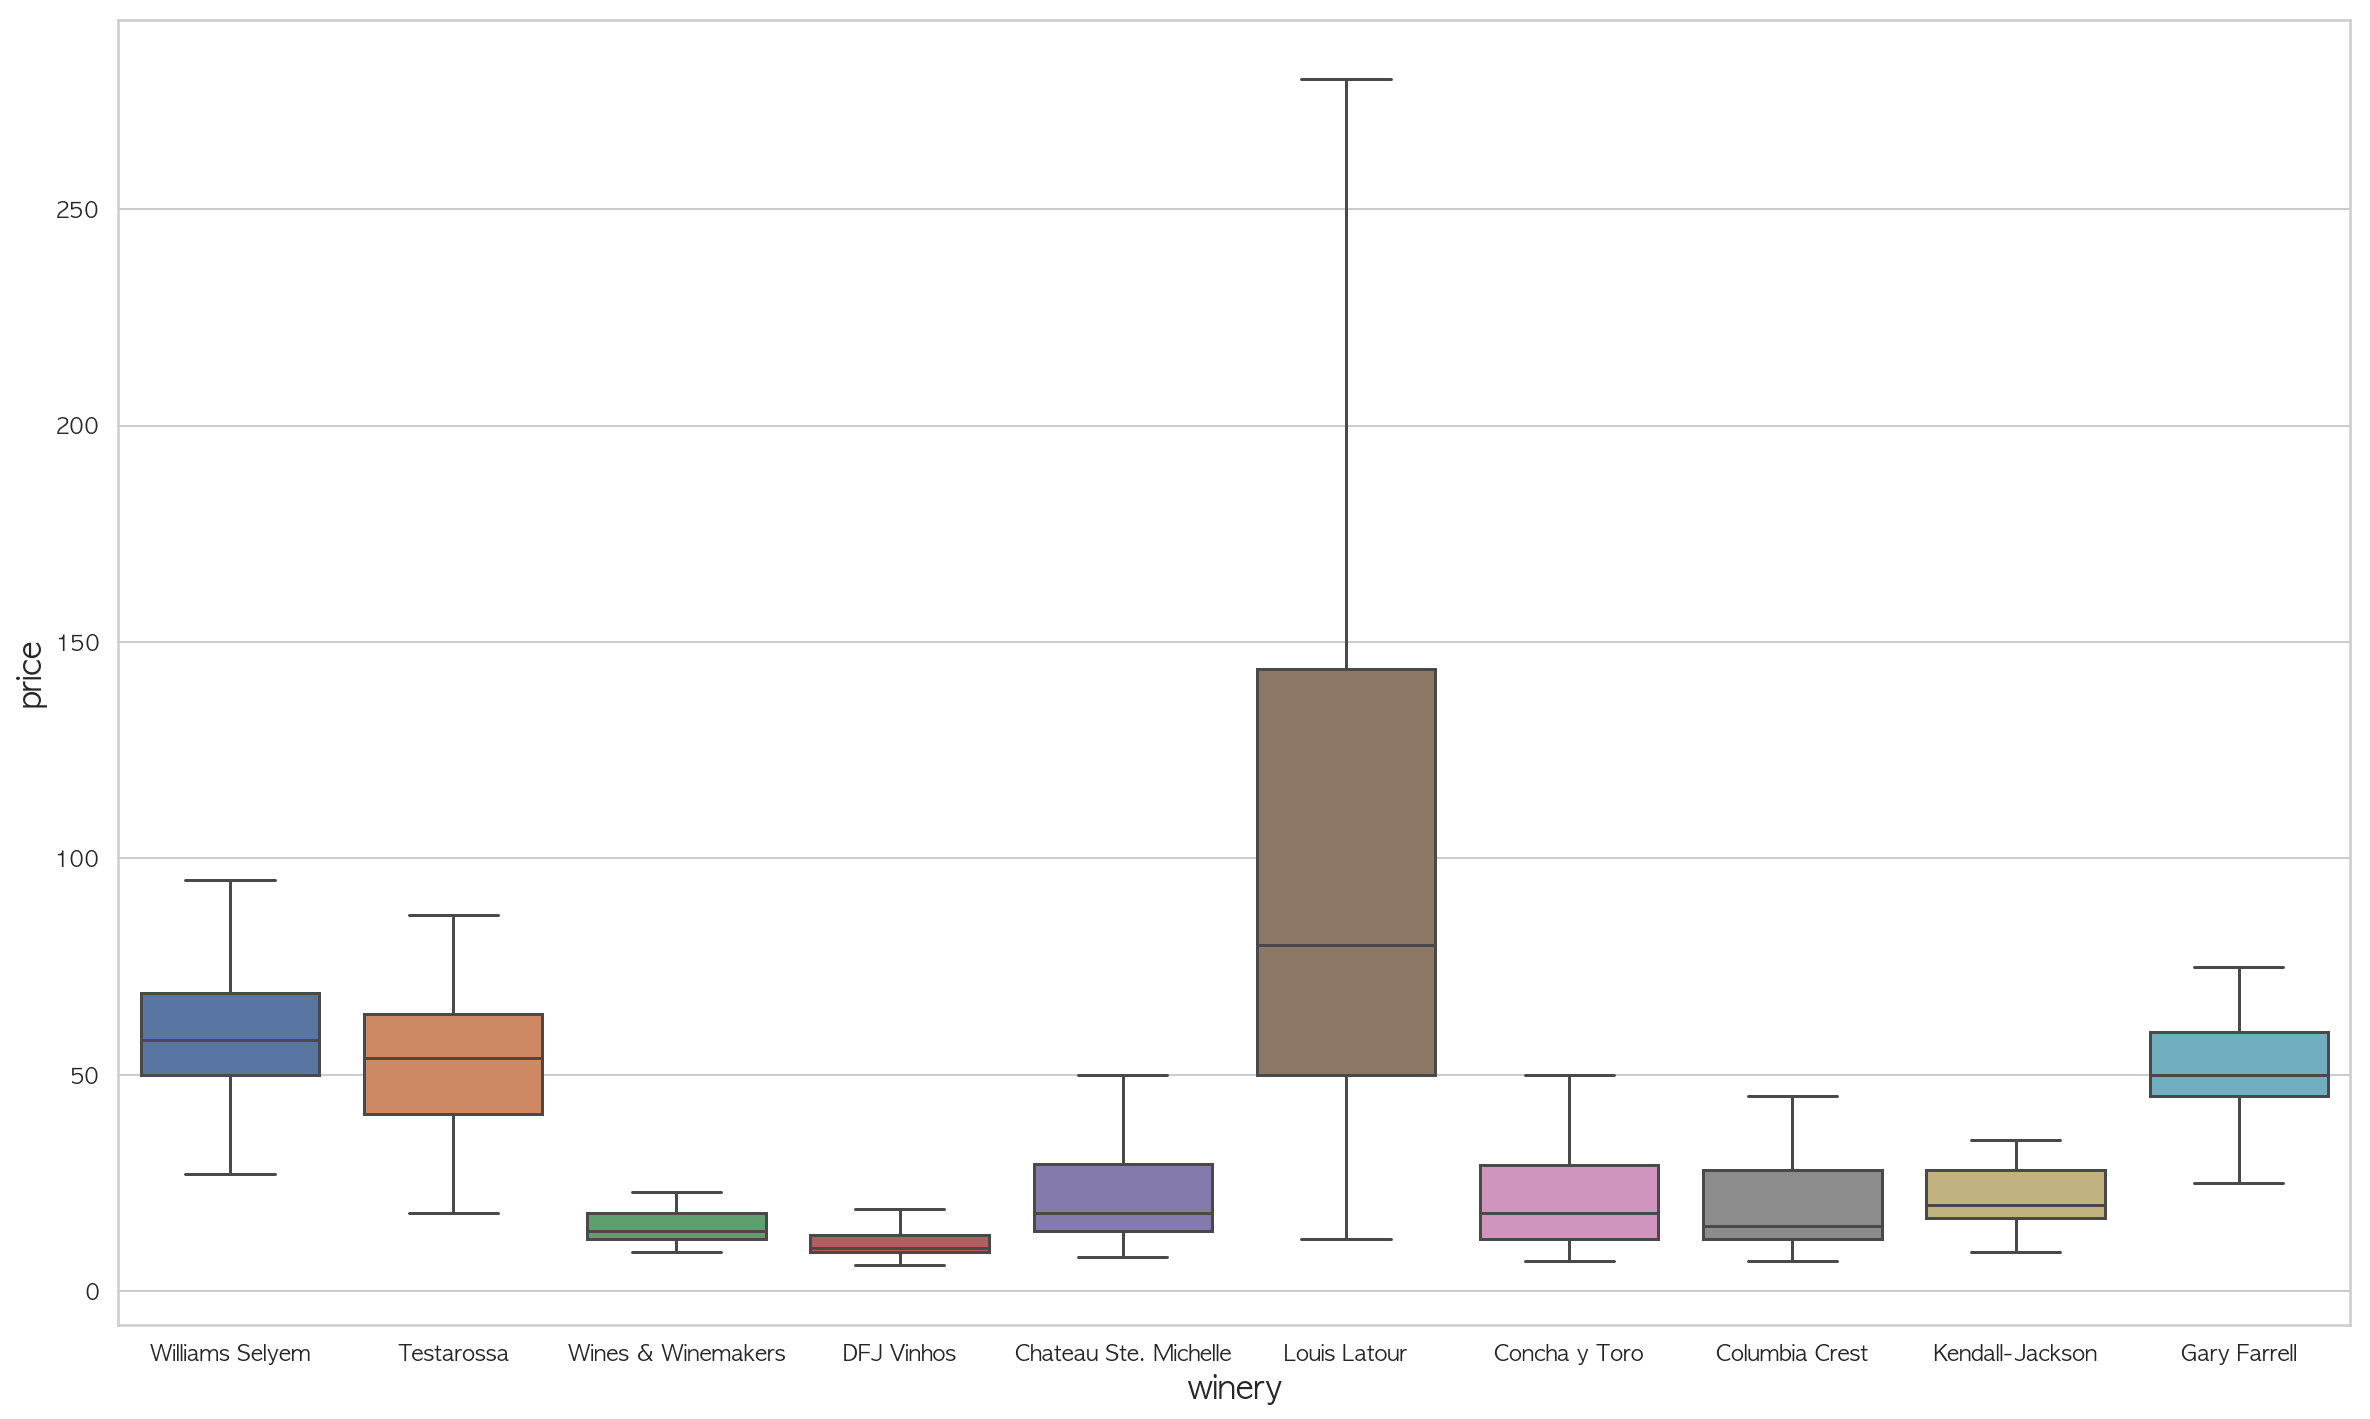

In [70]:
plt.figure(figsize=(20, 12))
sns.boxplot(x='winery', y='price',
            data=train_df[train_df['winery'].isin(top10_winery)], 
            showfliers=False, 
            order=top10_winery)
plt.xlabel('winery', fontsize=16)
plt.ylabel('price', fontsize=16)

plt.show()

>`winery`의 카테고리 값들은 다른 categorical feature들에 비해서 `price`에 대해 random한 분포를 보입니다.

#### Missing value

In [71]:
missing_value(train_df, 'winery')

Shape of Dataset: (111538, 12)
Missing value of winery
NaN count	 0
NaN rate	 0.0%


---

### `variety`

#### Distribution

In [72]:
train_df['variety'].nunique()

691

In [73]:
variety = train_df['variety'].value_counts()

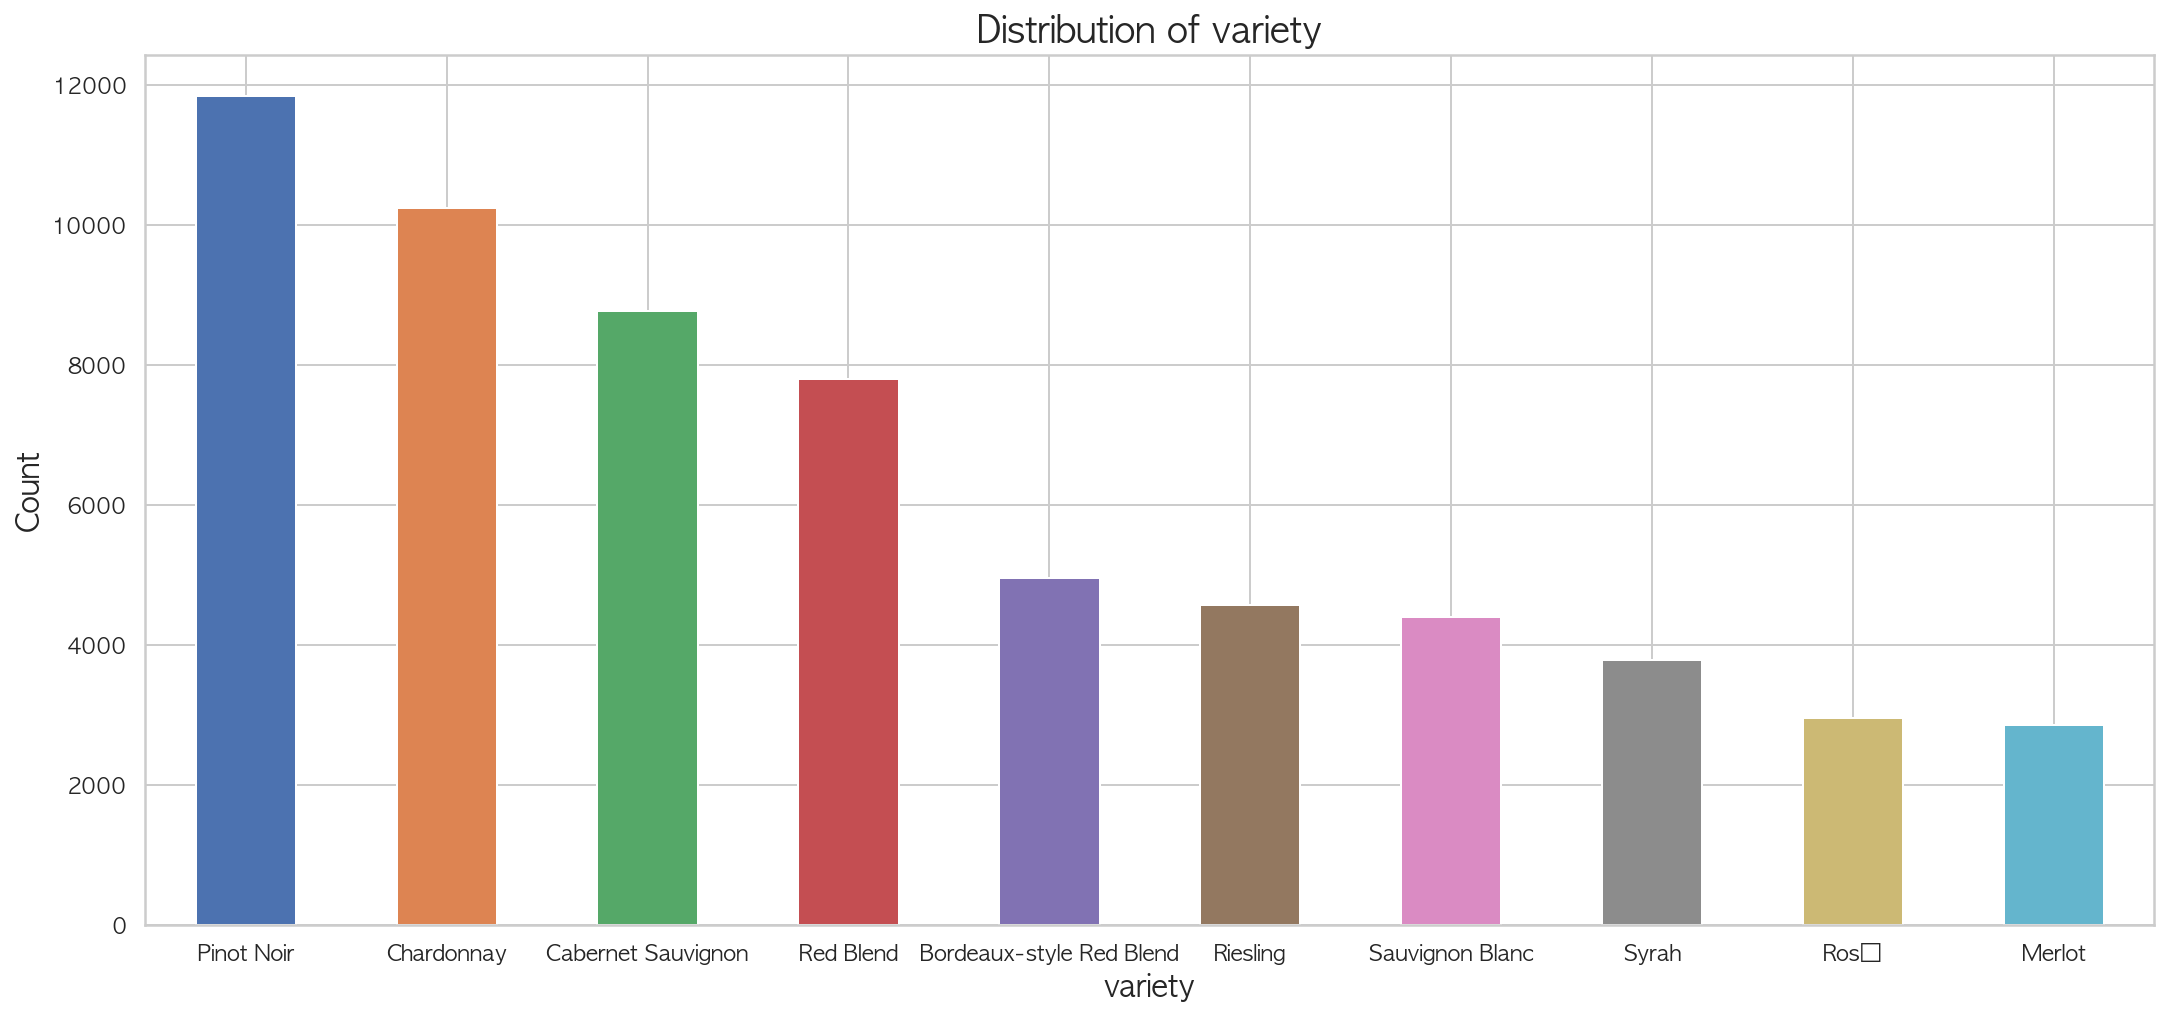

In [74]:
variety[:10].plot(kind='bar', figsize=(18, 8), rot=0)
plt.title('Distribution of variety', fontsize=18)
plt.xlabel('variety', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

##### Pinot Noir, Chardonnay, Cabernet Sauvignon, Red Blend, Bordeaux-style Red Blend|

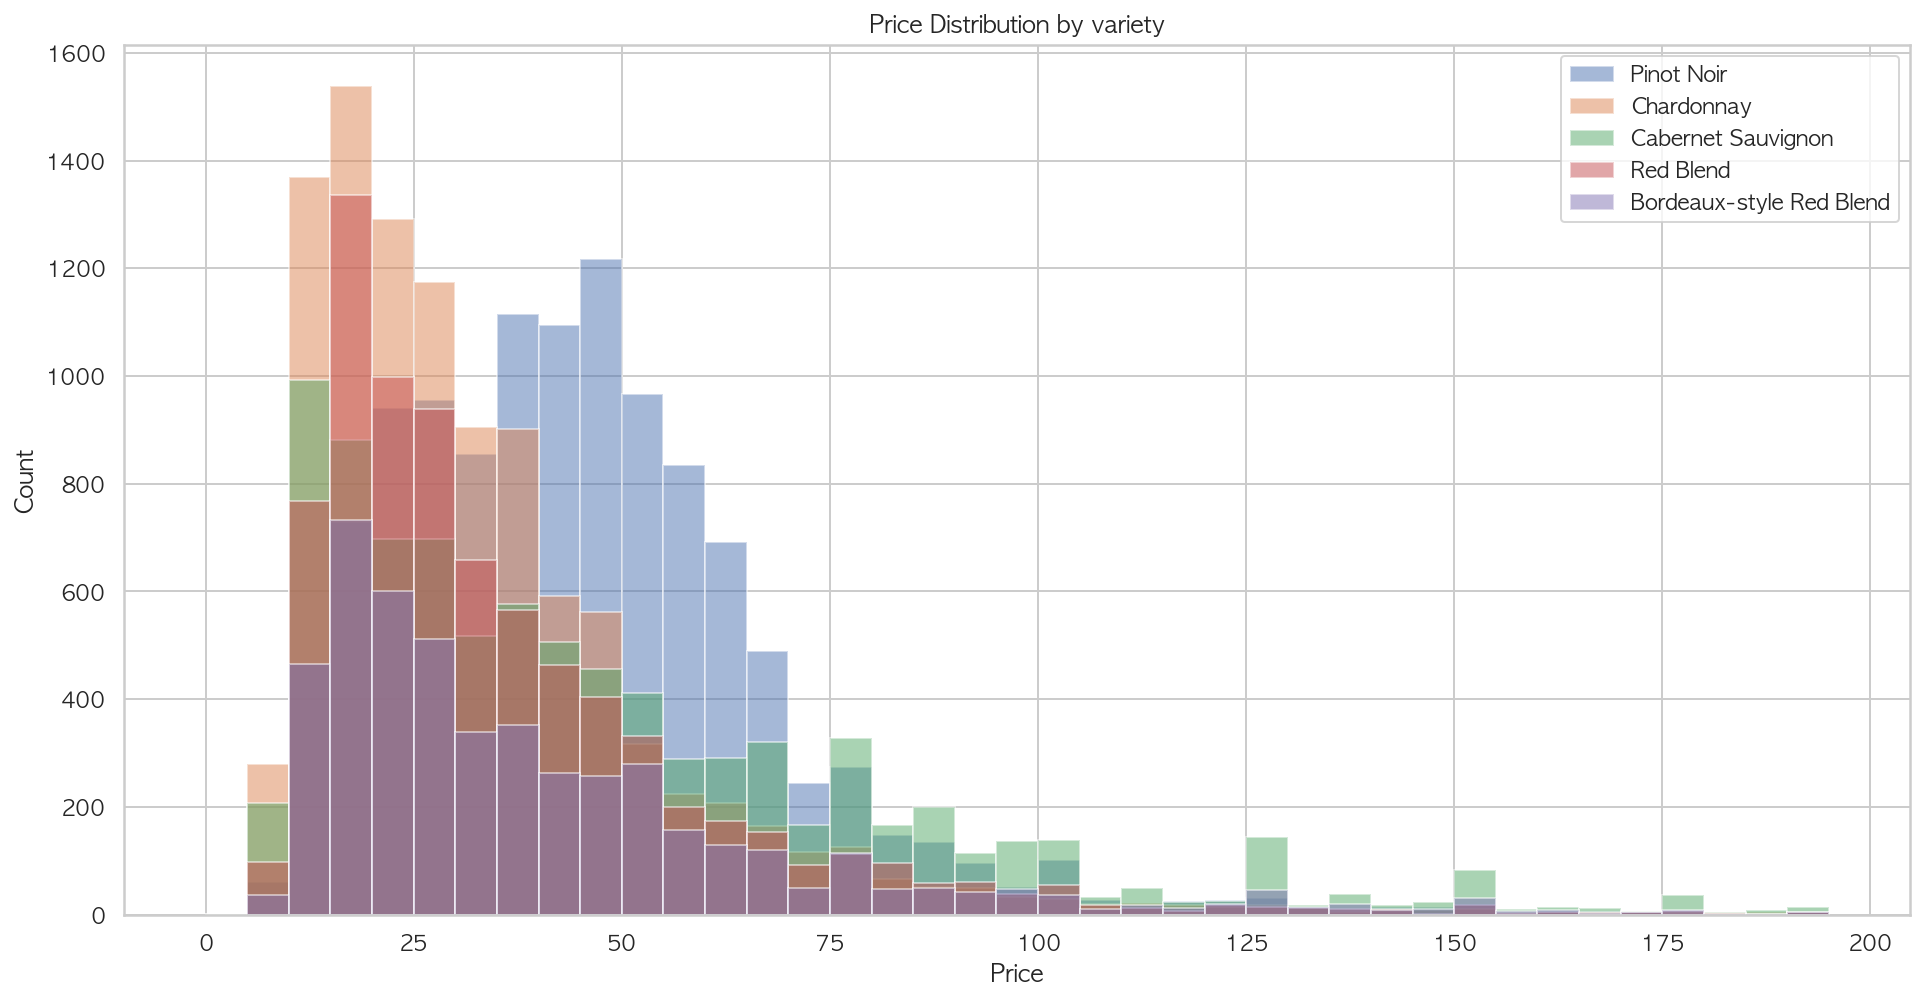

In [75]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in variety.index[:5]:
    plt.hist(train_df.loc[train_df['variety'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by variety')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

##### Riesling, Sauvignon Blanc, Syrah, Rosé, Merlot

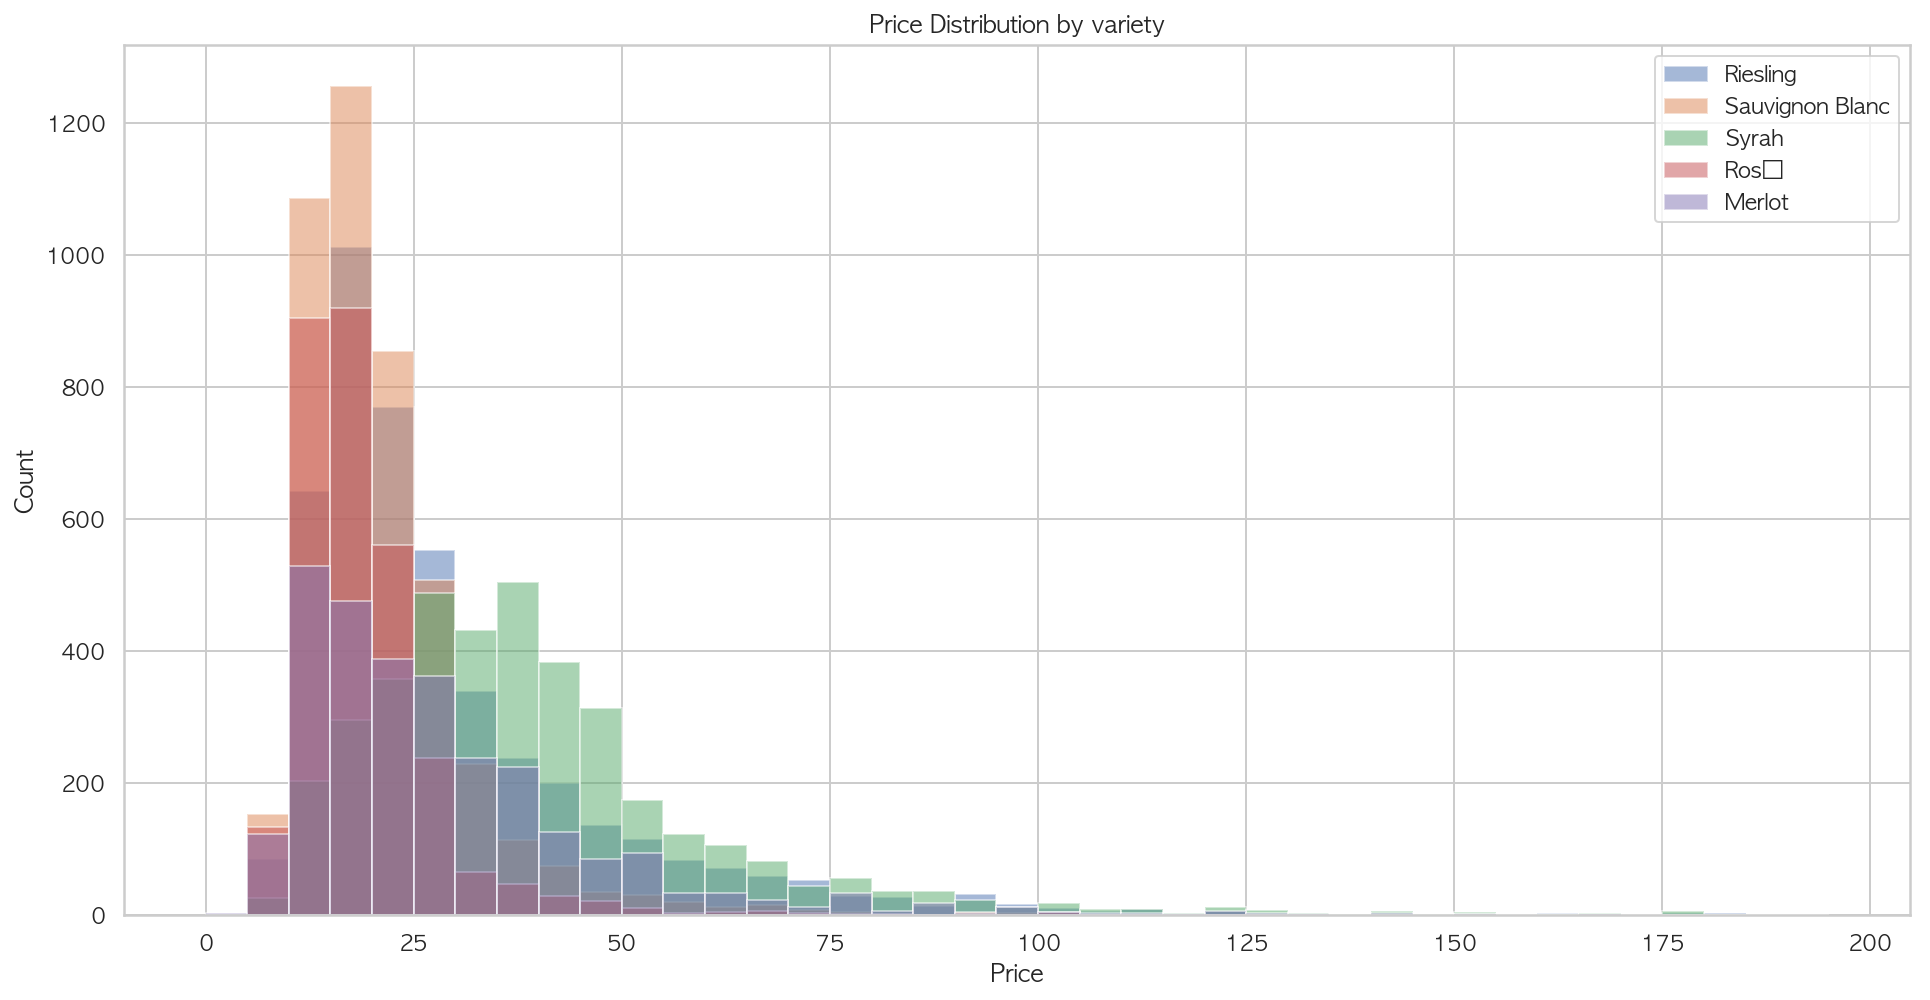

In [76]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in variety.index[5:10]:
    plt.hist(train_df.loc[train_df['variety'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by variety')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Box plot

In [77]:
top10_variety = variety.index[:10]

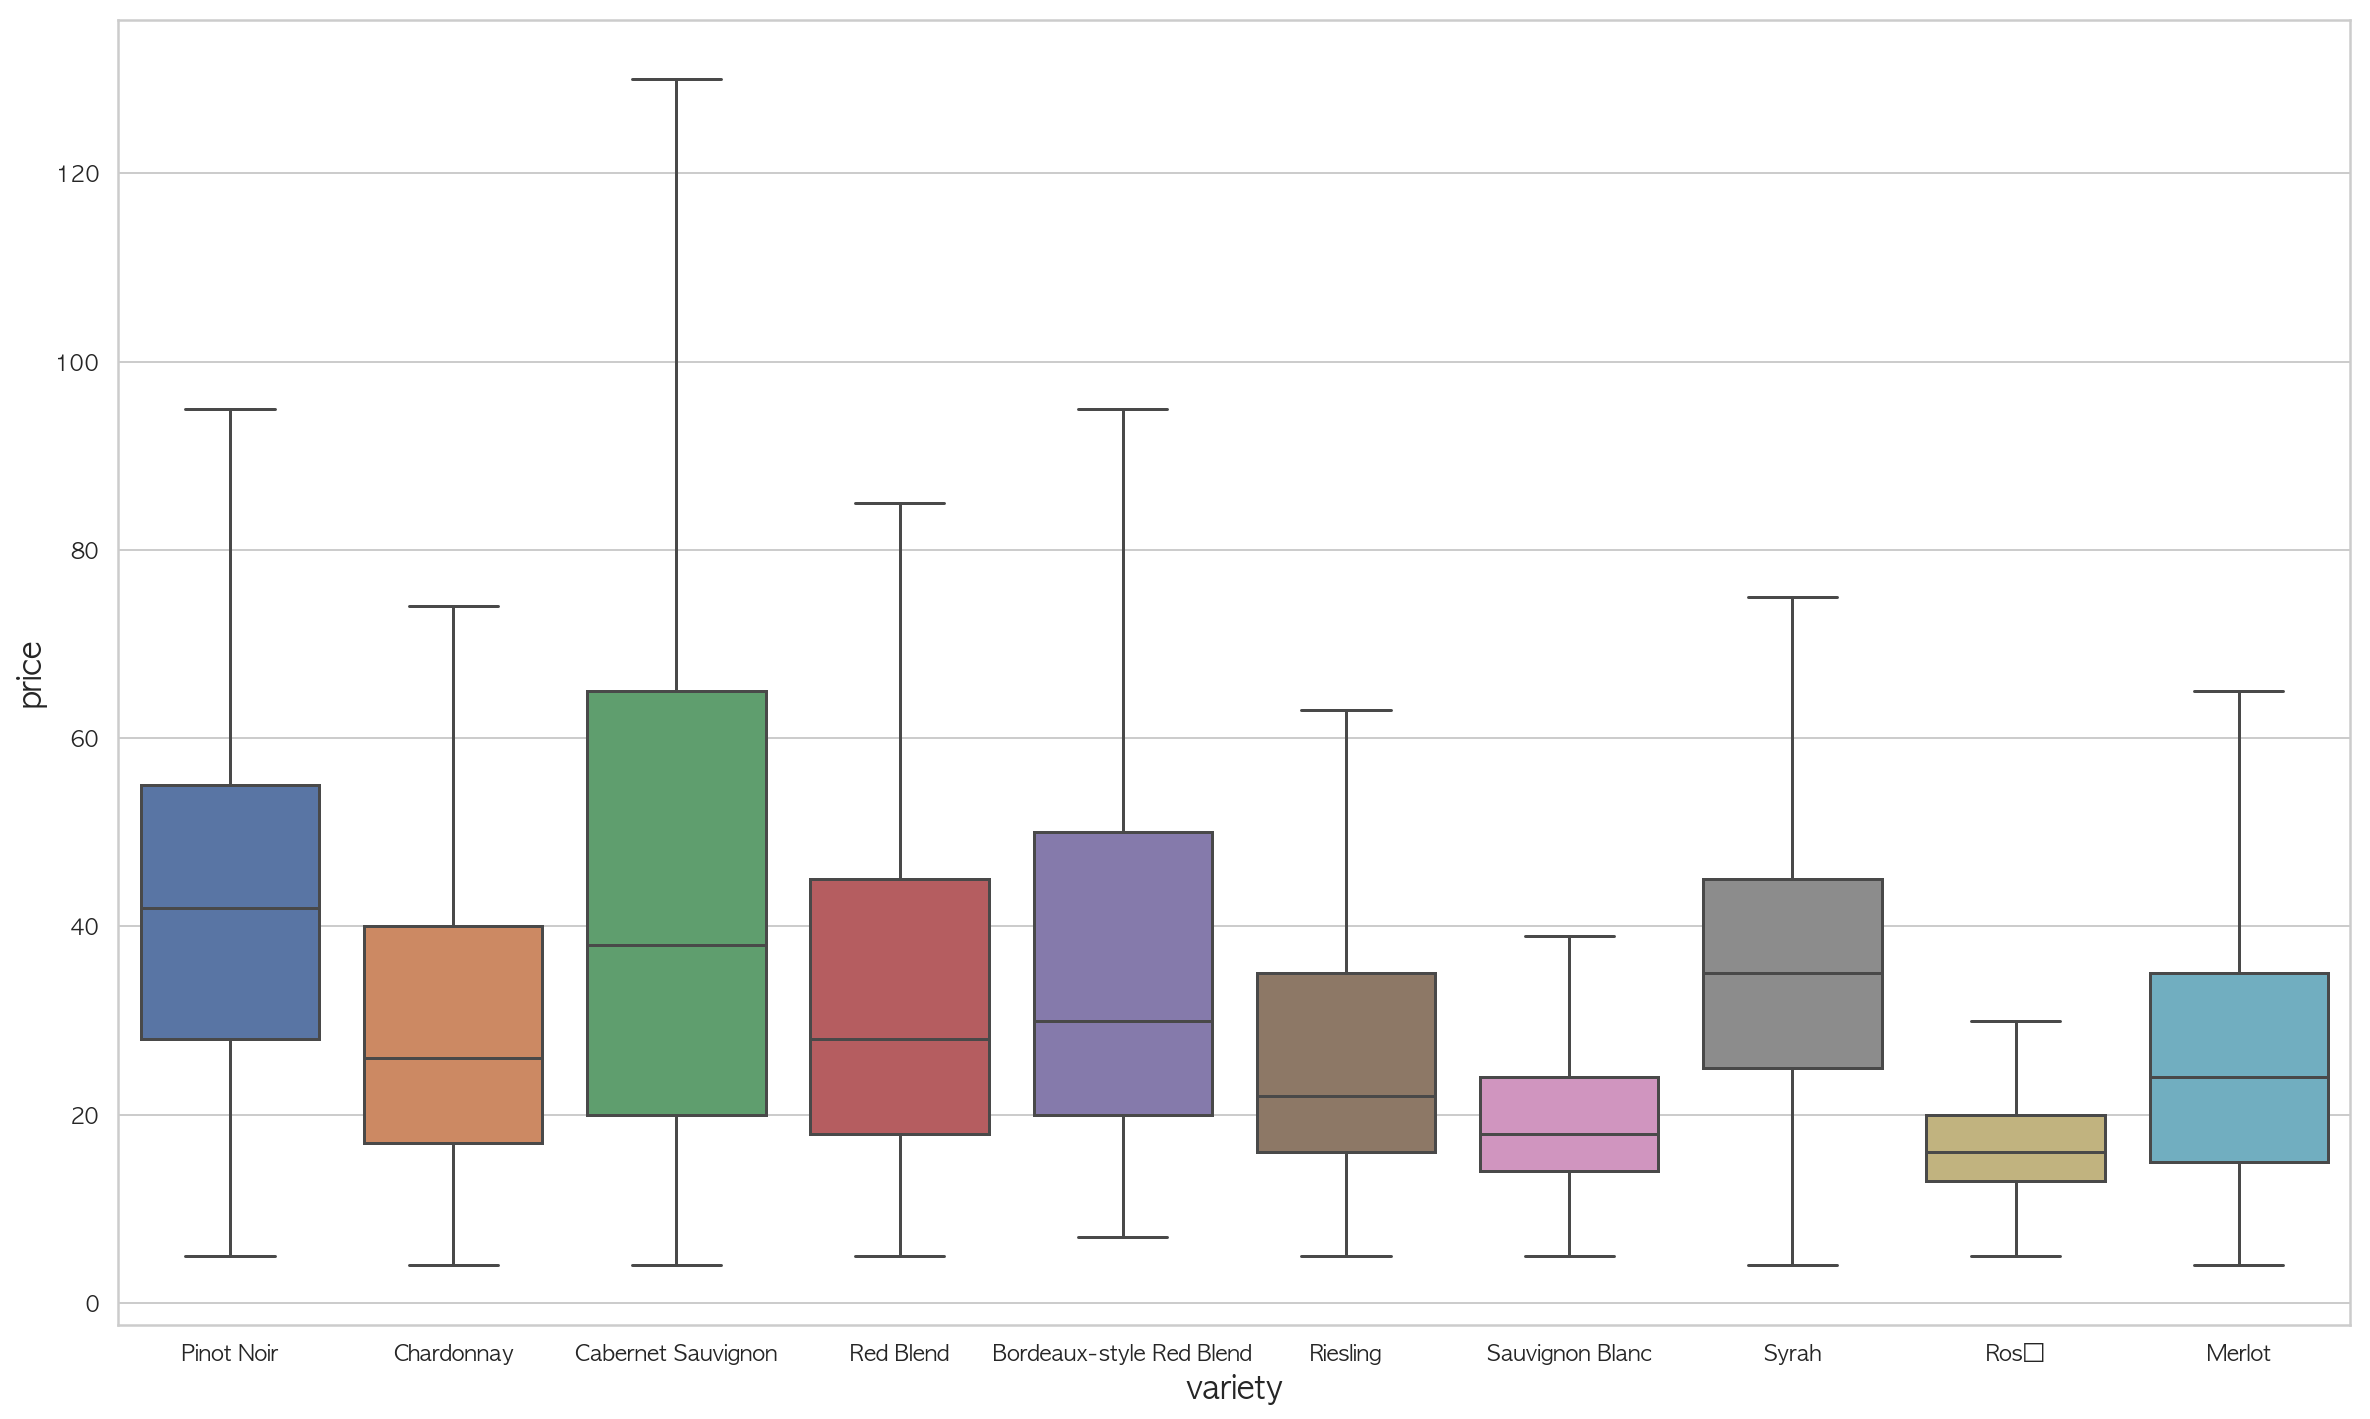

In [78]:
plt.figure(figsize=(20, 12))
sns.boxplot(x='variety', y='price',
            data=train_df[train_df['variety'].isin(top10_variety)], 
            showfliers=False, 
            order=top10_variety)
plt.xlabel('variety', fontsize=16)
plt.ylabel('price', fontsize=16)

plt.show()

#### Missing value

In [79]:
missing_value(train_df, 'variety')

Shape of Dataset: (111538, 12)
Missing value of variety
NaN count	 1
NaN rate	 0.0%


In [80]:
drop_idx_variety = train_df[train_df.isnull()['variety']].index
train_df = train_df.drop(index=drop_idx_variety)

---

### `taster_name`
- 와인을 평가한 'Wine Enthusiast' 에디터이자 테이스터의 이름입니다.

#### Distribution

In [81]:
train_df['taster_name'].nunique()

19

In [82]:
taster_name = train_df['taster_name'].value_counts()

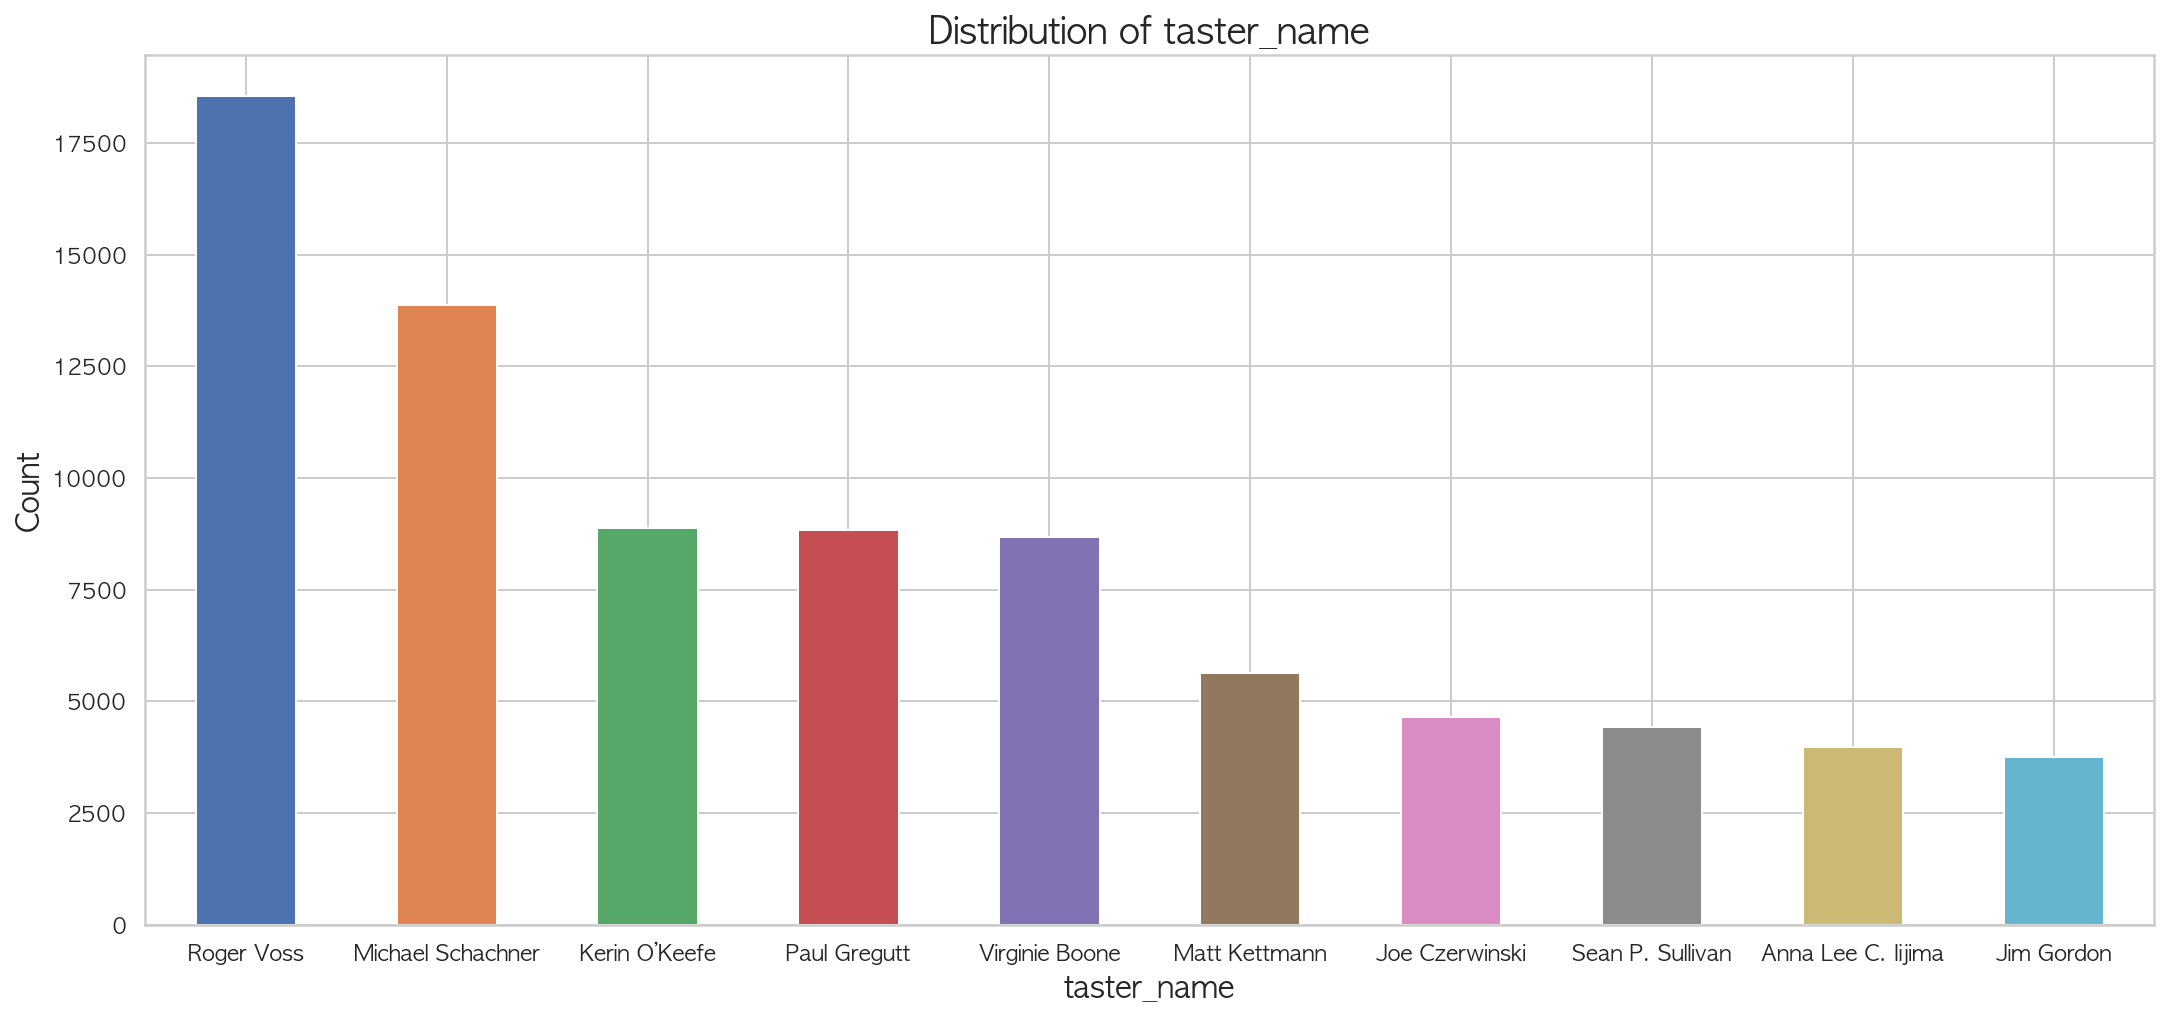

In [83]:
taster_name[:10].plot(kind='bar', figsize=(18, 8), rot=0)
plt.title('Distribution of taster_name', fontsize=18)
plt.xlabel('taster_name', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

##### Roger Voss, Michael Schachner, Kerin O’Keefe, Paul Gregutt, Virginie Boone

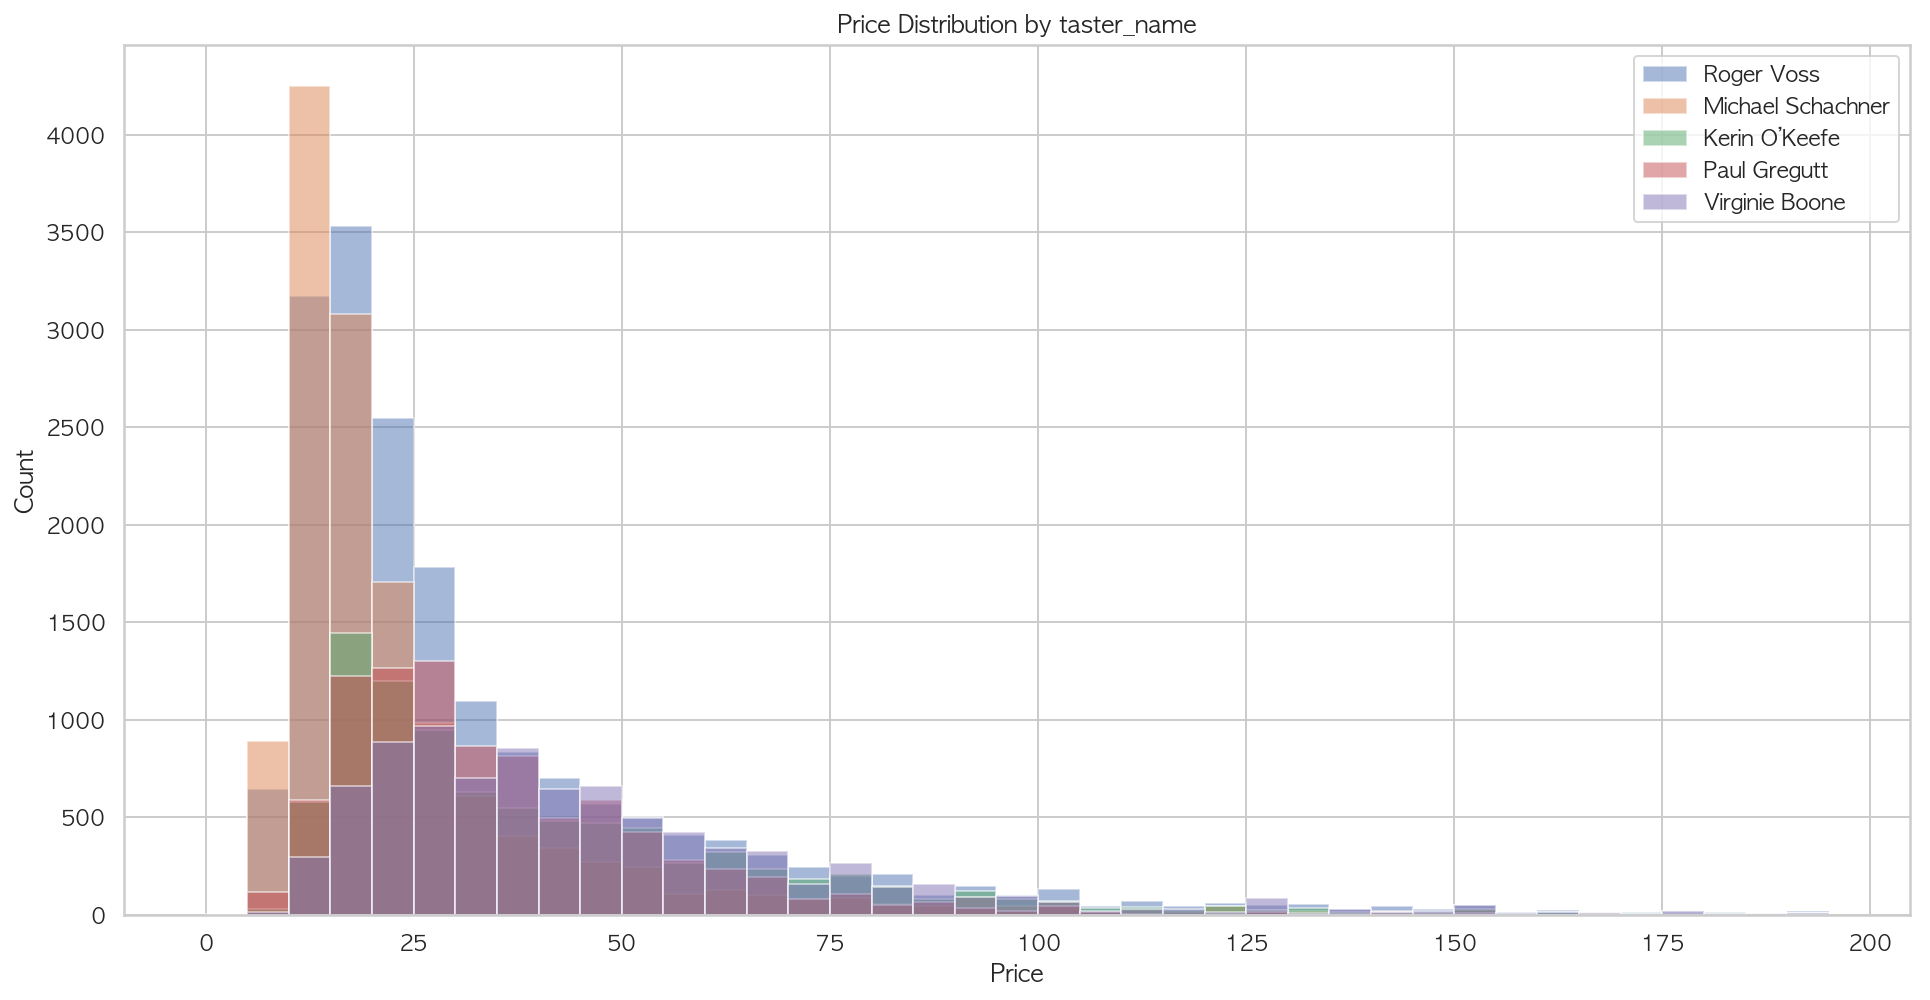

In [84]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in taster_name.index[:5]:
    plt.hist(train_df.loc[train_df['taster_name'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by taster_name')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

##### Matt Kettmann, Joe Czerwinski, Sean P. Sullivan,Anna Lee C. Iijima, Jim Gordon

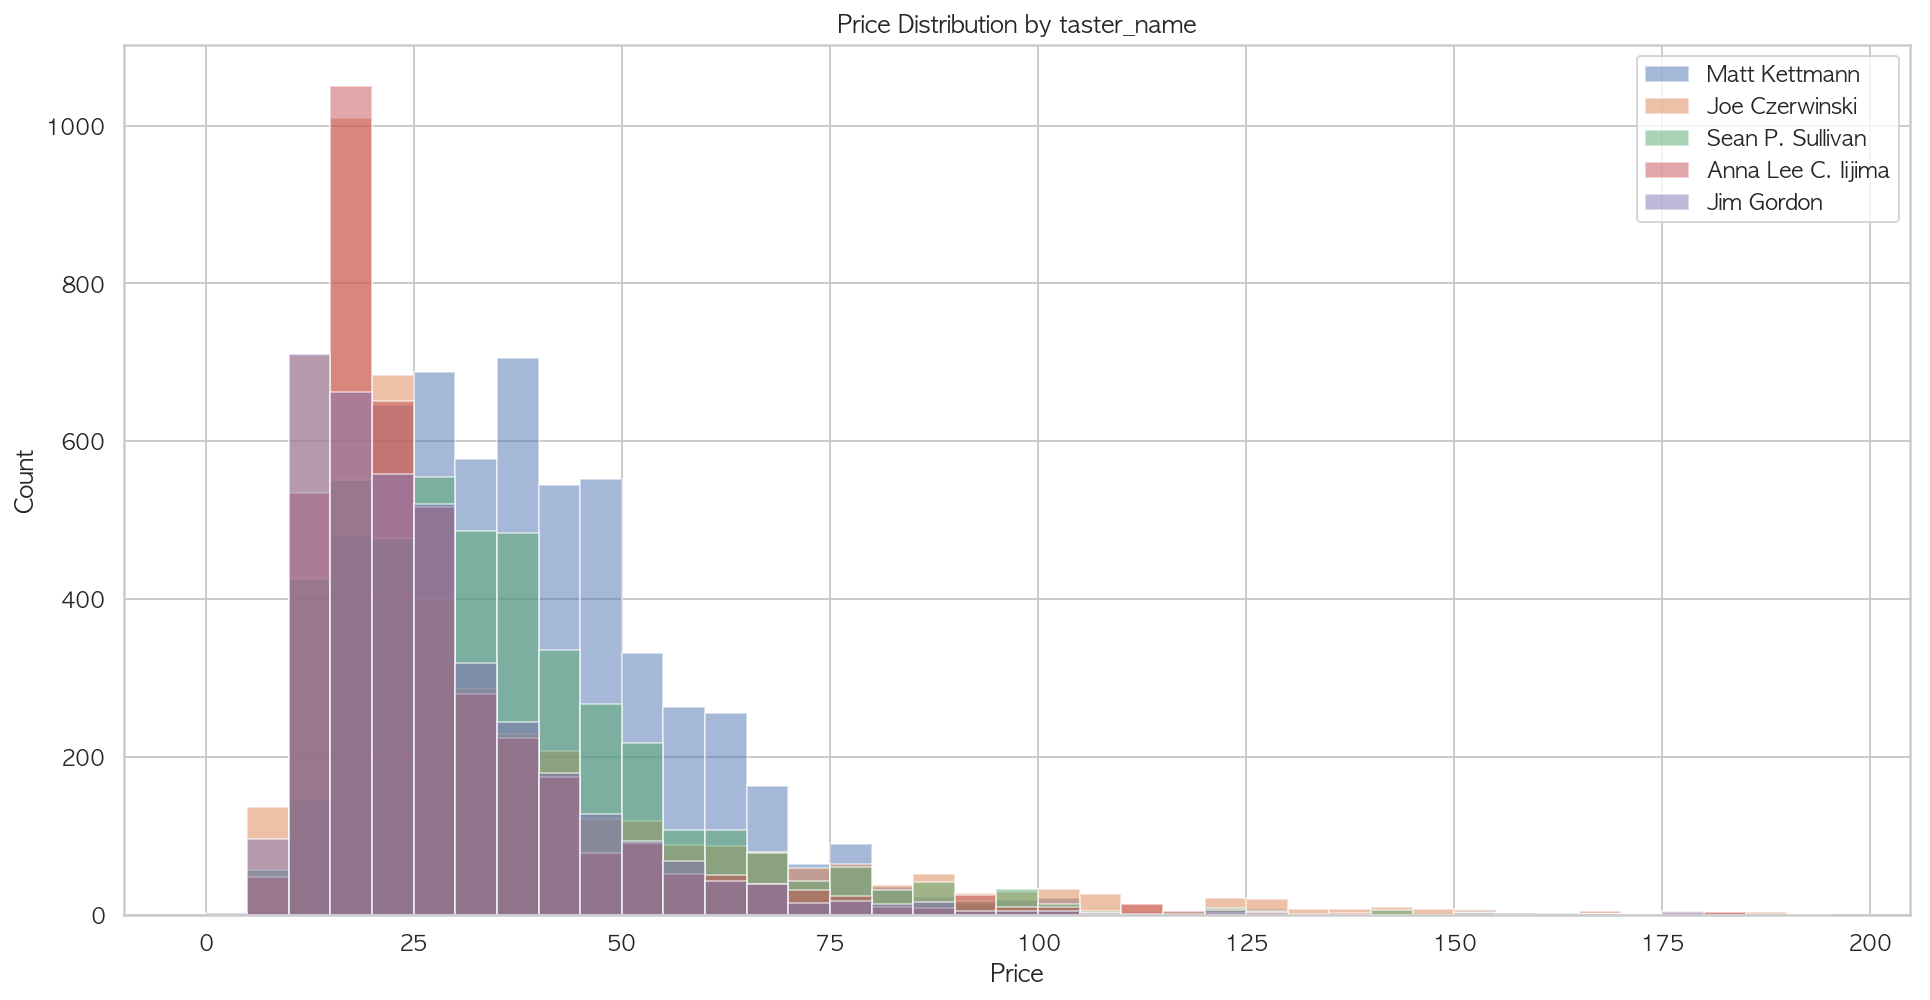

In [85]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in taster_name.index[5:10]:
    plt.hist(train_df.loc[train_df['taster_name'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by taster_name')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Box plot

In [86]:
top10_taster_name = taster_name.index[:10]

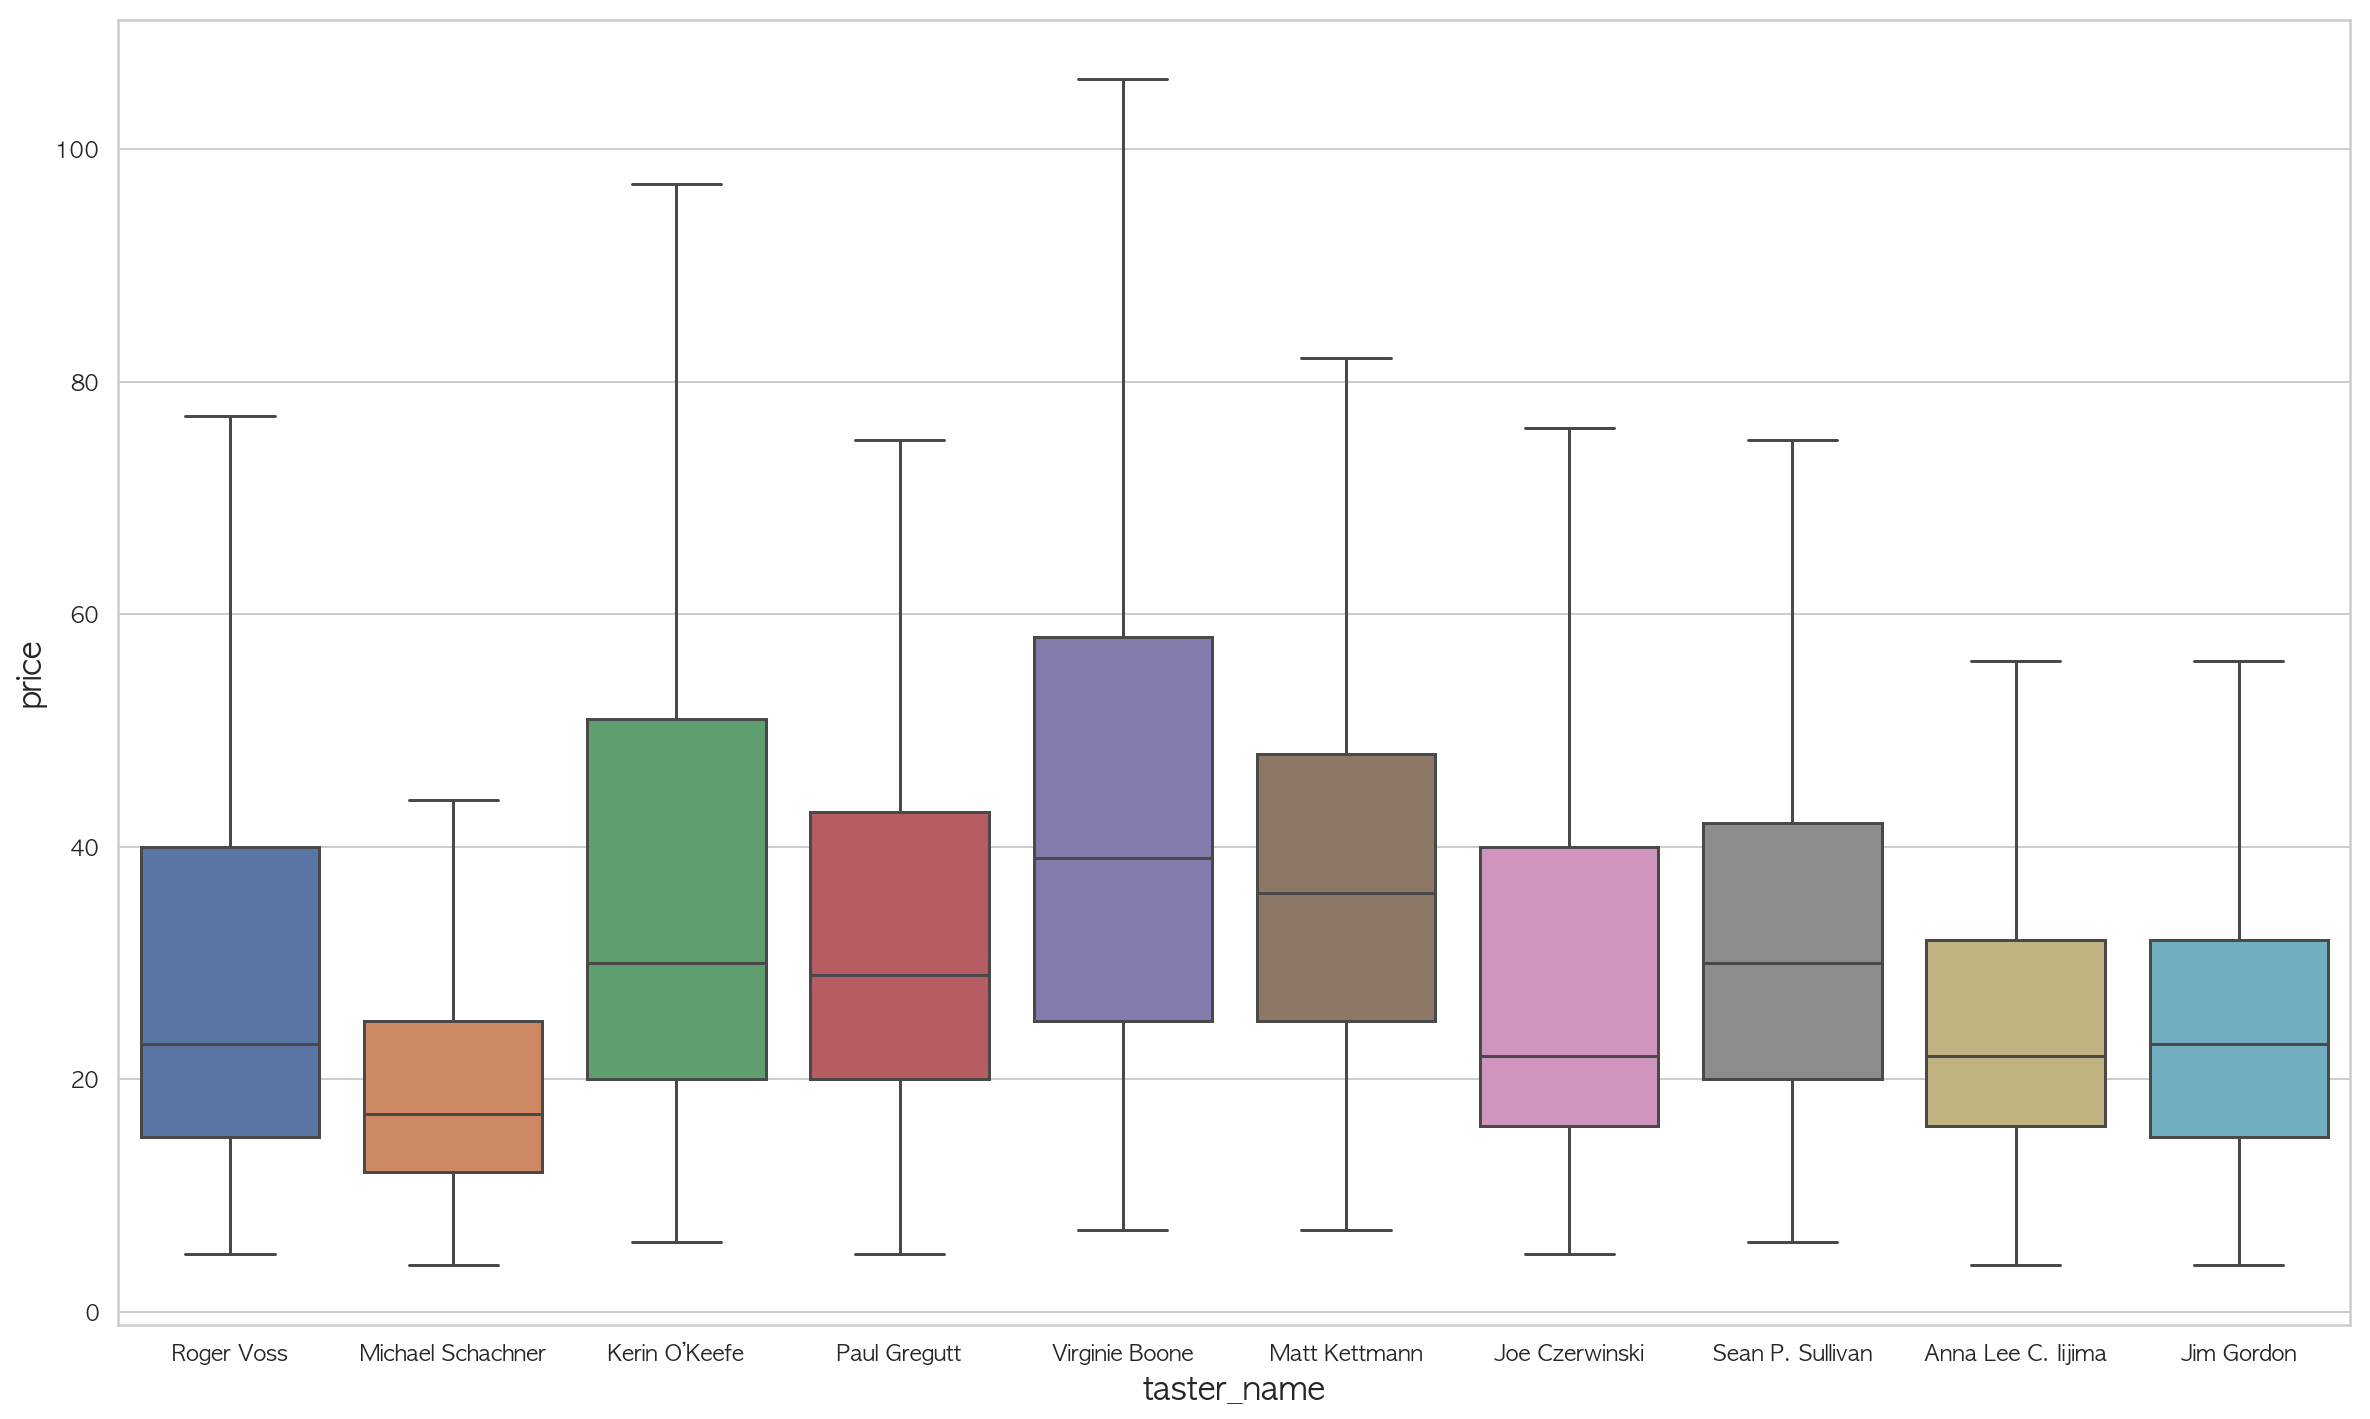

In [87]:
plt.figure(figsize=(20, 12))
sns.boxplot(x='taster_name', y='price',
            data=train_df[train_df['taster_name'].isin(top10_taster_name)], 
            showfliers=False, 
            order=top10_taster_name)
plt.xlabel('taster_name', fontsize=16)
plt.ylabel('price', fontsize=16)

plt.show()

#### Missing value & Feature engineering

In [88]:
missing_value(train_df, 'taster_name')

Shape of Dataset: (111537, 12)
Missing value of taster_name
NaN count	 23272
NaN rate	 20.86%


In [89]:
train_df['taster_name'].fillna('unknown', inplace=True)

---

### `taster_twitter_handle`

#### Feature engineering

In [90]:
train_df['taster_twitter_handle'].nunique()

15

In [91]:
missing_value(train_df, 'taster_twitter_handle')

Shape of Dataset: (111537, 12)
Missing value of taster_twitter_handle
NaN count	 27755
NaN rate	 24.88%


twitter id 텍스트 구조가 와인 가격에 실질적으로 영향을 미치지 않으므로, 단순히 taster의 twitter_id가 존재하는지 아닌지를 구분하는 binary feature로 만듭니다.

In [92]:
train_df['taster_twitter_handle'] = train_df['taster_twitter_handle'].apply(lambda x: 0 if x is np.nan else 1)
train_df['taster_twitter_handle'] = train_df['taster_twitter_handle'].astype(np.uint8)

---

### `title` -> `vintage`
- `title`은 리뷰된 와인의 이름으로 포도의 품종 및 생산지, winery 이름, 빈티지(vintage: 와인을 만들기 위해 포도를 수확한 해) 등의 정보가 복합적으로 담겨있습니다.
- 훈련을 위한 데이터셋에는 빈티지에 대한 정보만 추출하여 새로운 feature `vintage`로 가공하는 작업을 하겠습니다.

#### Missing value

In [93]:
missing_value(train_df, 'title')

Shape of Dataset: (111537, 12)
Missing value of title
NaN count	 0
NaN rate	 0.0%


### `title` -> `vintage`
>와인의 라벨을 텍스트 데이터로 만든 `title`에서는 `vintage` 정보를 추출하여 새로운 feature로 가공합니다.

`vintage`는 와인을 만드는데 사용된 포도를 수확한 해를 뜻합니다. 포도 농사는 그 해 기후에 따라 크게 좌우되는데, 일조량이 풍부하고 강우량이 비교적 적은 기후를 거치면 포도의 당도가 높고 신맛이 적으며 색깔은 진한 좋은 와인을 생산할 수 있는 포도가 됩니다. 따라서 같은 와인이어도 빈티지에 따라서 와인의 품질과 가격이 변화하기도 합니다. 

In [94]:
def extract_year(data):
    yearlist = list(np.arange(1950, 2018, 1))
    num = [int(w) for w in data.split() if w.isdigit()]
    if num is None:
        return np.nan
    else:
        for year in num:
            if year in yearlist:
                return year

In [95]:
train_df['vintage'] = train_df['title'].apply(extract_year).astype(str)

#### Distribution

In [96]:
vintage = train_df['vintage'].value_counts()
vintage.index = vintage.index.astype(str) # prevent index error

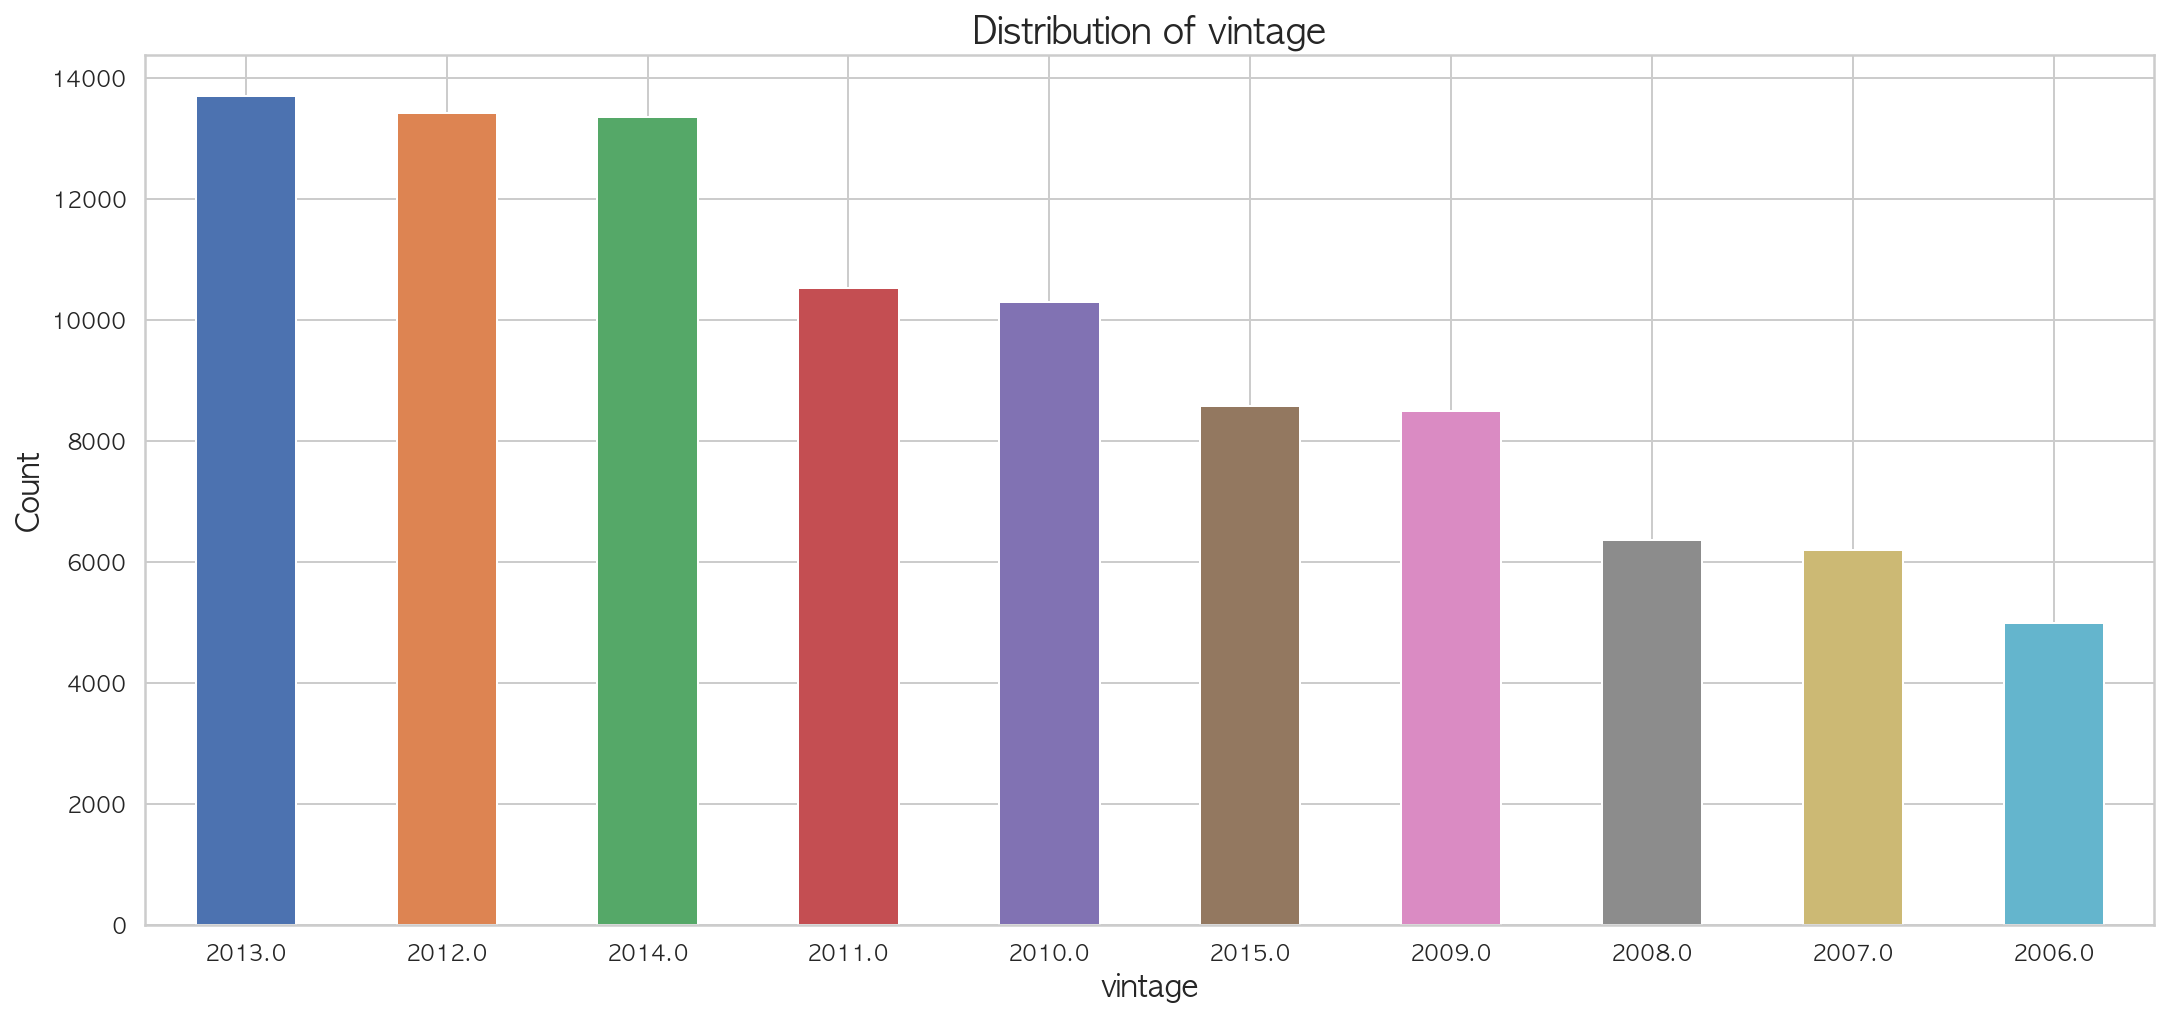

In [97]:
vintage[:10].plot(kind='bar', figsize=(18, 8), rot=0)
plt.title('Distribution of vintage', fontsize=18)
plt.xlabel('vintage', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.show()

##### 2013, 2012, 2014, 2011, 2010

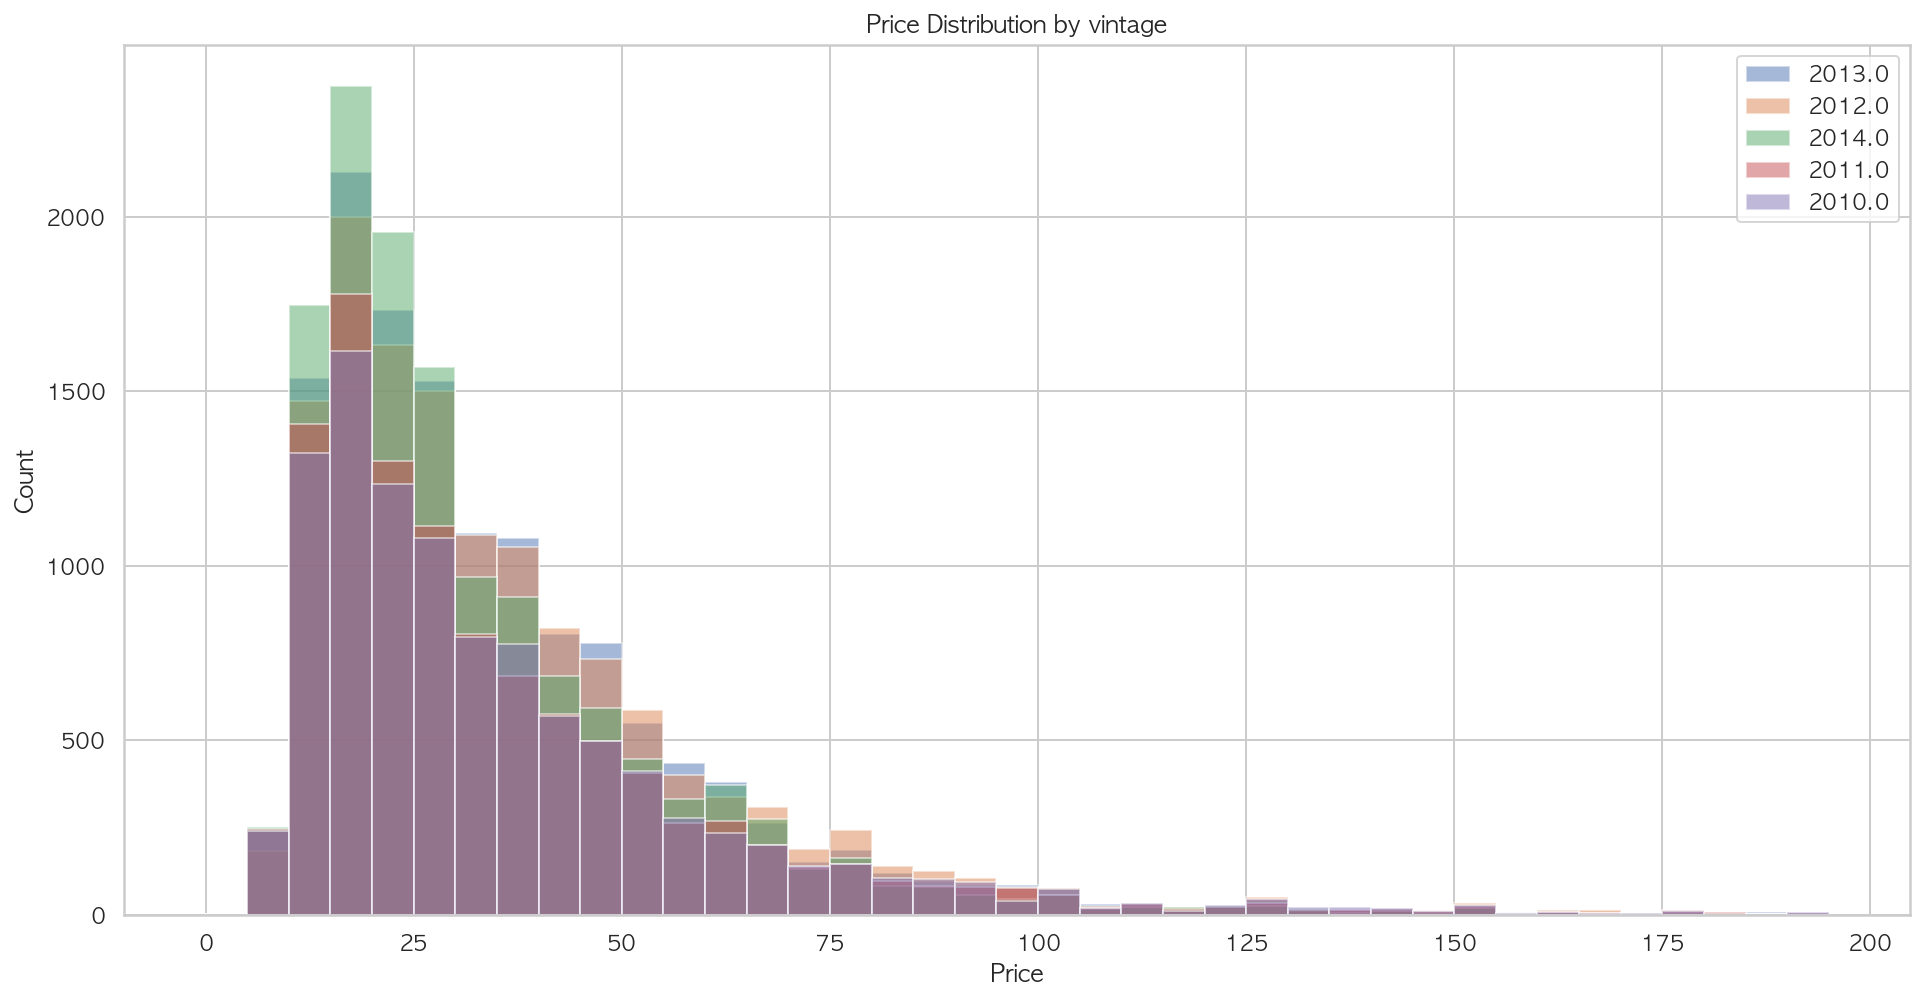

In [98]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in vintage.index[:5]:
    plt.hist(train_df.loc[train_df['vintage'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by vintage')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

##### 2015, 2009, 2008, 2007, 2006

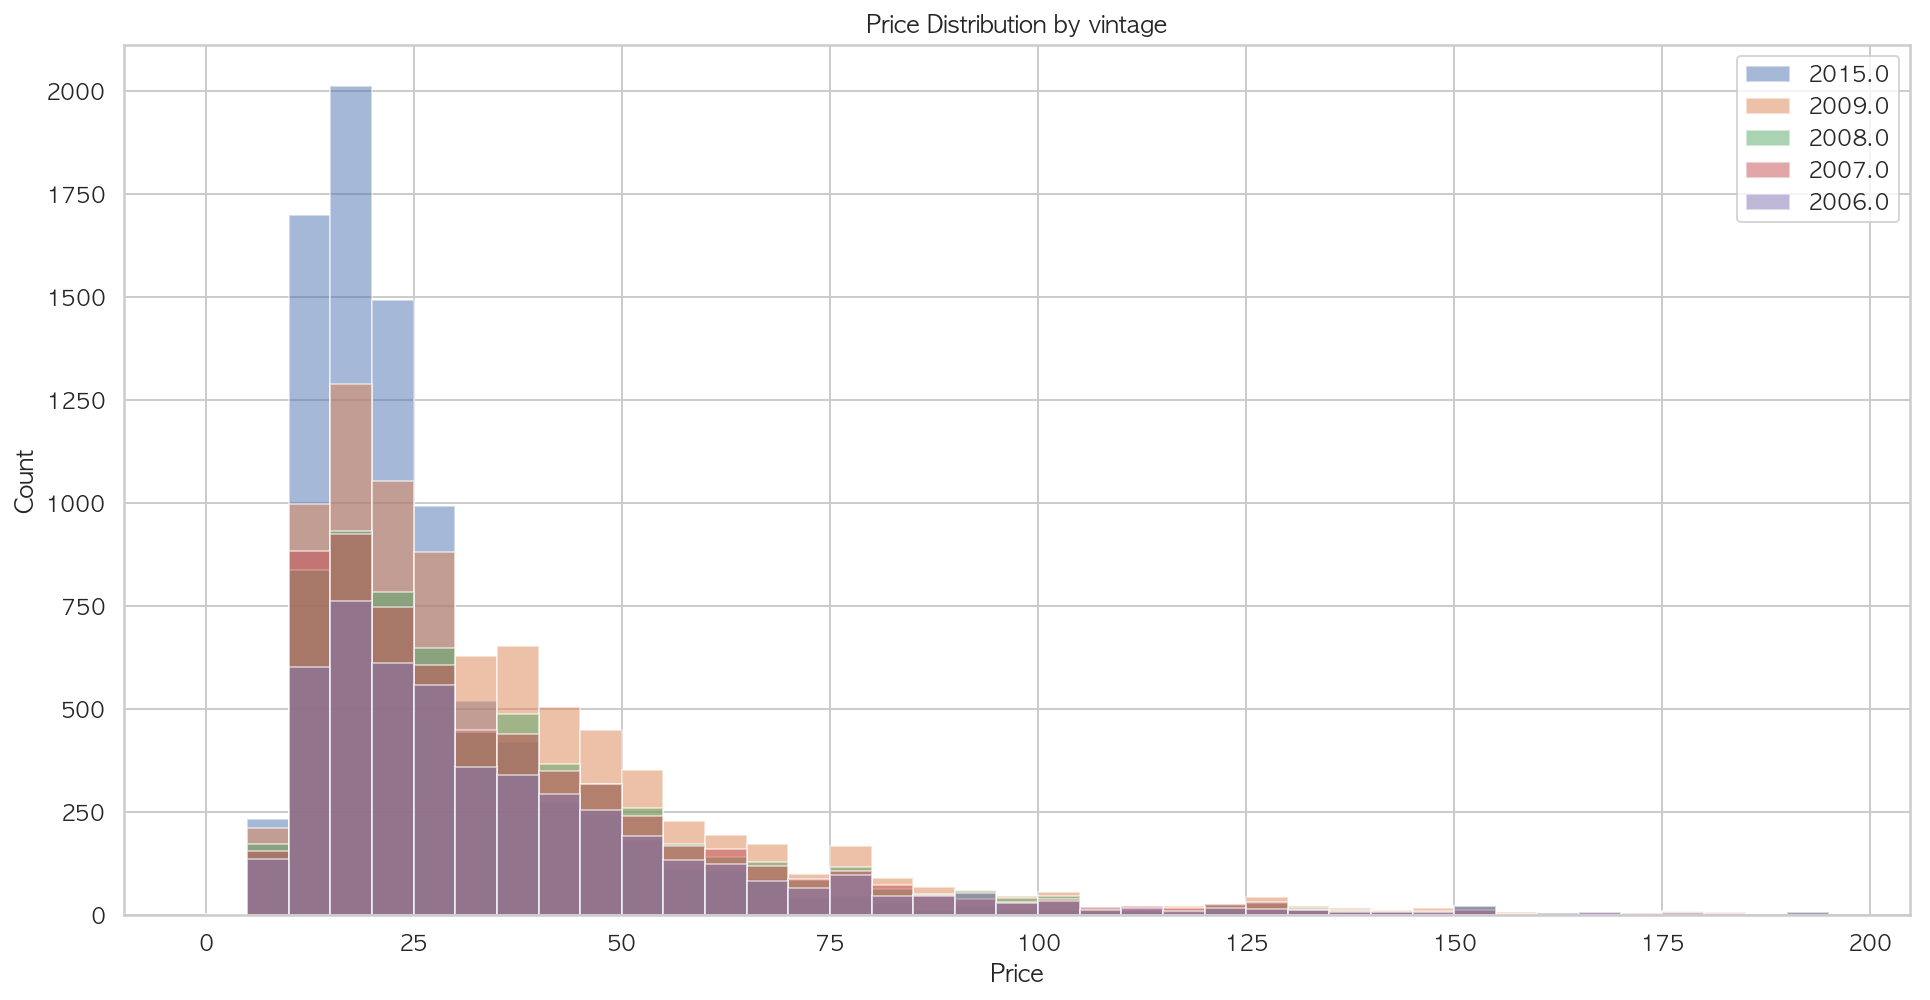

In [99]:
bins = range(0, 200, 5)

plt.figure(figsize = (16, 8))

for i in vintage.index[5:10]:
    plt.hist(train_df.loc[train_df['vintage'] == i]['price'],
             bins, alpha=0.5, label=i, edgecolor='white')

plt.title('Price Distribution by vintage')
plt.xlabel('Price')
plt.ylabel('Count')
plt.legend()
plt.show()

#### Box plot

In [100]:
top10_vintage = vintage.index[:10]

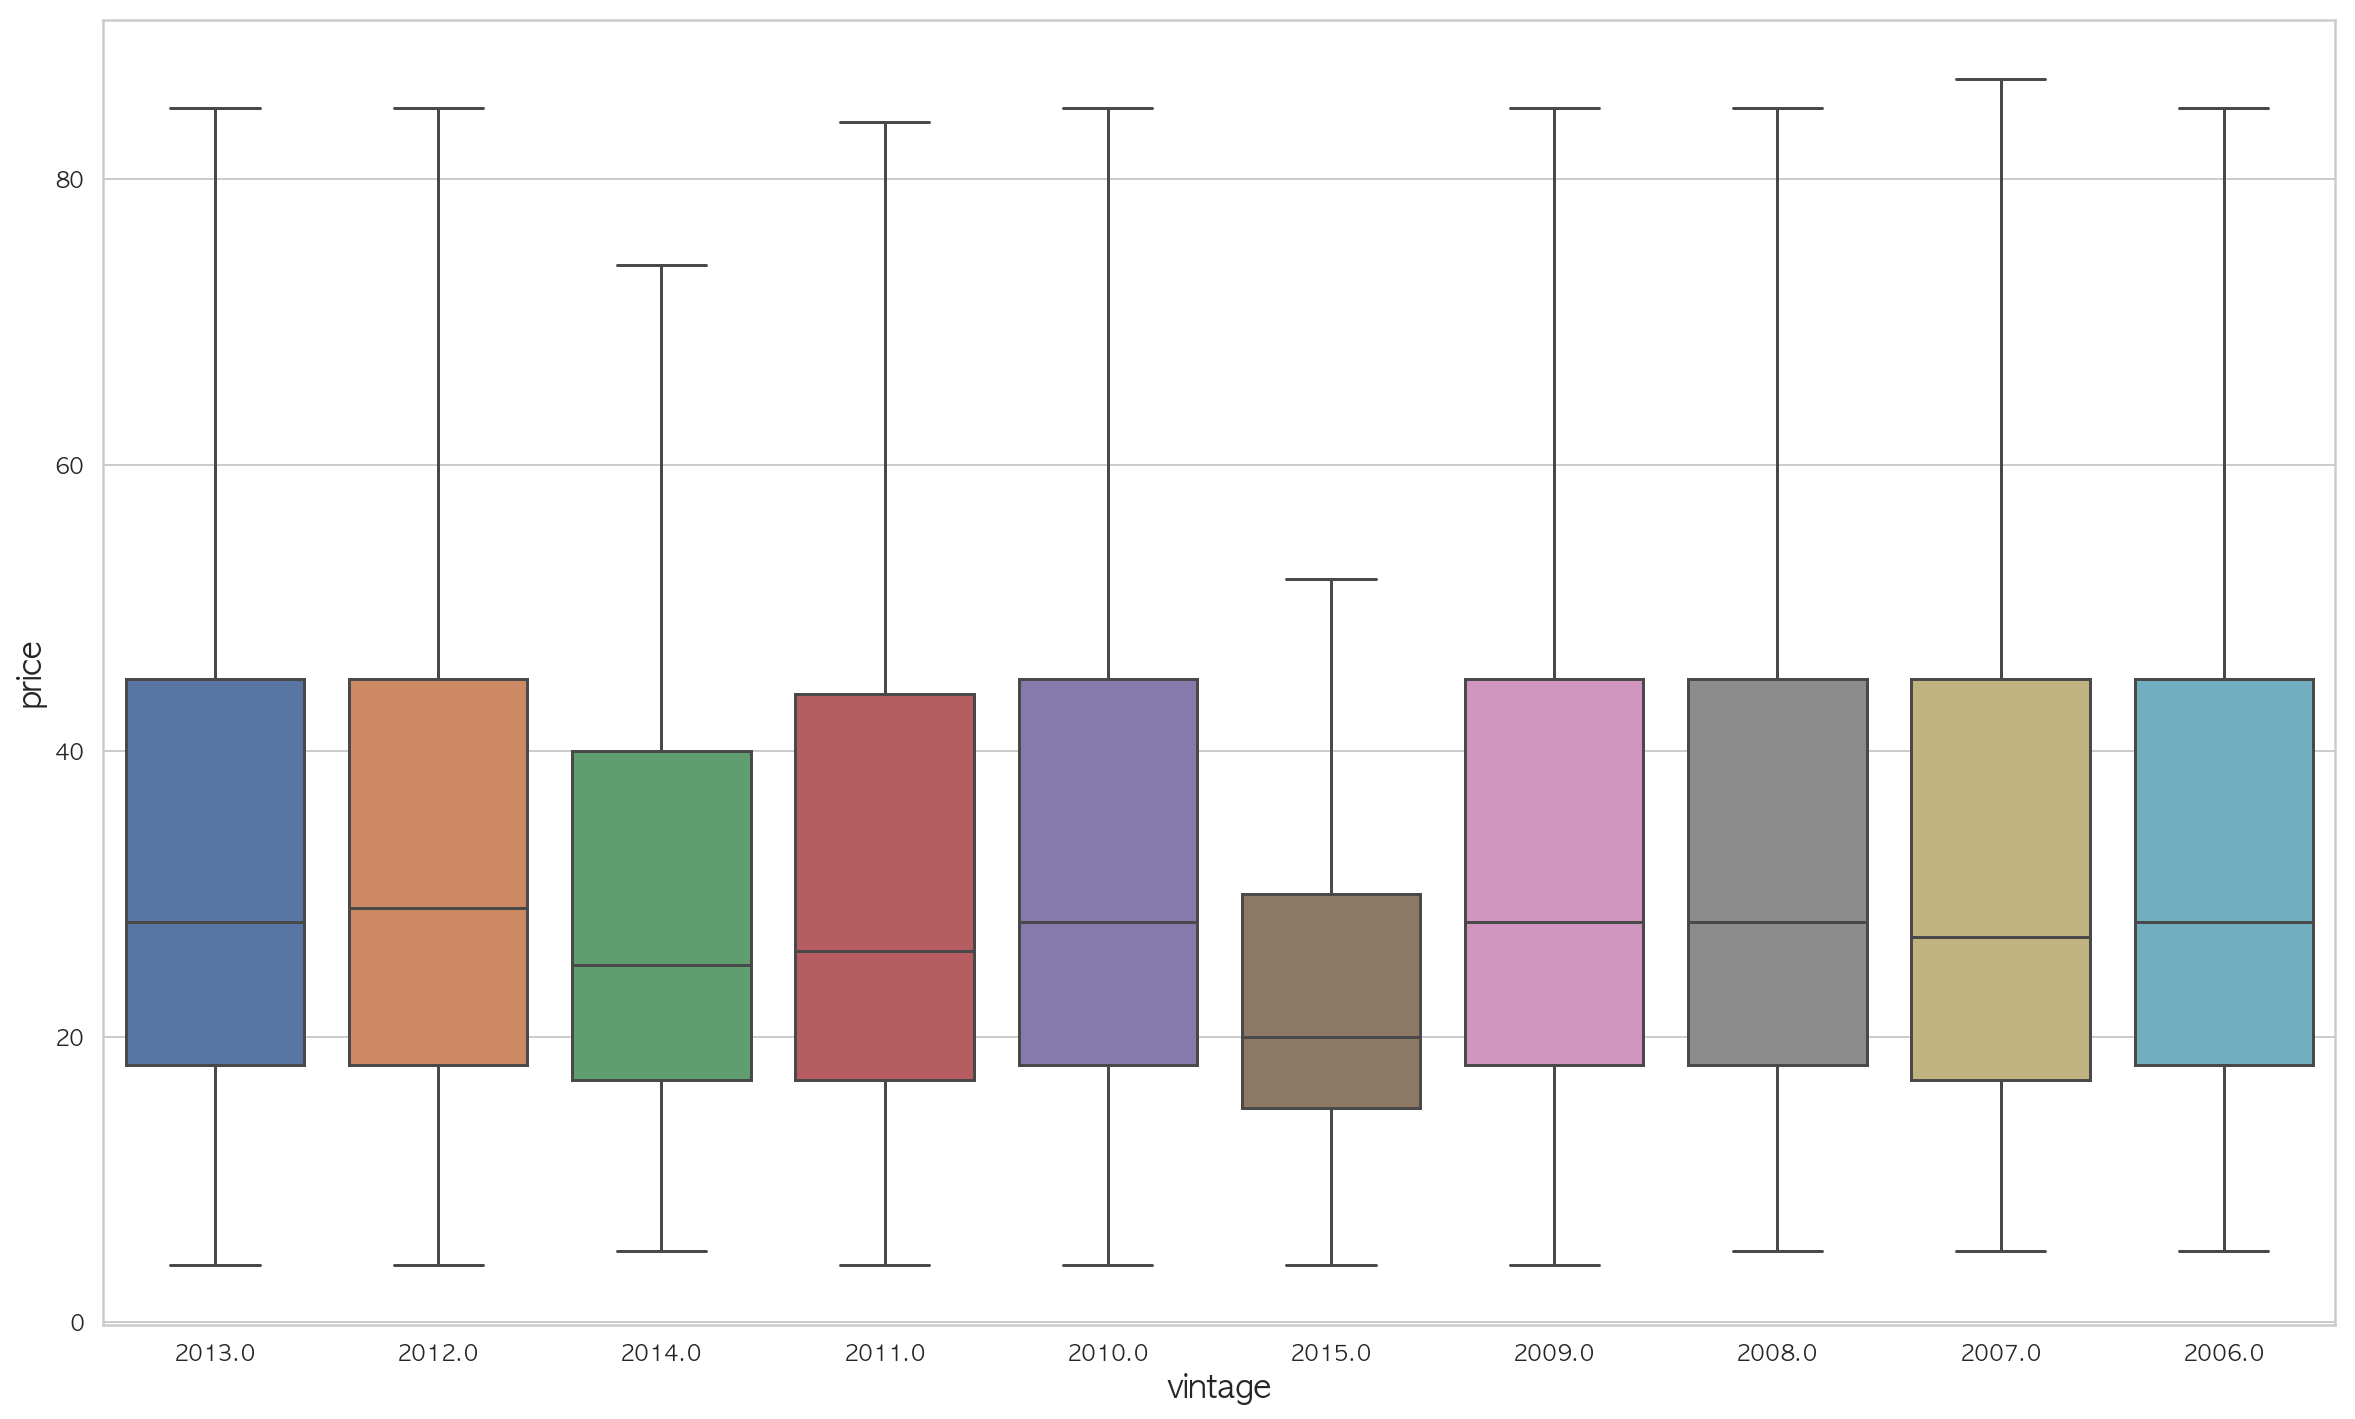

In [101]:
plt.figure(figsize=(20, 12))
sns.boxplot(x='vintage', y='price',
            data=train_df[train_df['vintage'].isin(top10_vintage)], 
            showfliers=False, 
            order=top10_vintage)
plt.xlabel('vintage', fontsize=16)
plt.ylabel('price', fontsize=16)

plt.show()

#### Missing value

In [102]:
missing_value(train_df, 'vintage')

Shape of Dataset: (111537, 13)
Missing value of vintage
NaN count	 0
NaN rate	 0.0%


---

### `description`

- `description`에 자주 등장하는 표현에 대해서 확인해보겠습니다.

### Pre-processing
- `description`에서 특수문자를 제거한 후 pos tagging을 이용한 lemmatizing 작업을 진행합니다.

#### Remove special characters

In [103]:
def remove_special_char(sentence):
    
    text = ''.join([word for word in sentence])
    stripped = re.sub("[^\w\s]", '', text)
    stripped = re.sub("_", '', stripped)
    stripped = re.sub(r"\b[a-zA-Z]\b", "", stripped)
    stripped = re.sub("\s+", " ", stripped)

    return stripped.strip()

#### Lemmatizing

In [104]:
lm = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    if tag == "V":
        return wordnet.VERB
    elif tag == "N":
        return wordnet.NOUN
    elif tag == "R":
        return wordnet.ADV
    elif tag == "J":
        return wordnet.ADJ
    return wordnet.NOUN

def lemmatize(sentence):
    sentence = str(sentence)
    tokens = word_tokenize(sentence)
    lemmatized = [lm.lemmatize(w, pos=get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemmatized)

In [105]:
%%time
train_df['description'] = train_df['description'].apply(remove_special_char)
train_df['description'] = train_df['description'].apply(lemmatize)

CPU times: user 8min 14s, sys: 30.4 s, total: 8min 44s
Wall time: 8min 45s


### Word frequency
`description`에서 가장 많이 등장하는 단어를 n-gram 단위로 알아봅니다.

In [106]:
def ngram_dist_plot(df, column, n):
    frequencies = defaultdict(int)
    stop_list = stopwords.words('english')
    
    for sent in df[column]:
        sent = str(sent)
        tokens = word_tokenize(sent)
        tokens = [token.lower() for token in tokens]
        tokens = [token for token in tokens if token.isalpha()\
                  if token != ""\
                  if token not in stop_list]

        for word in list(ngrams(tokens, n)):
            frequencies[word] += 1
    
    ngram_df = pd.DataFrame(sorted(frequencies.items(), 
                                   key=lambda x: x[1], 
                                   reverse=True),
                            columns = ["word", "wordcount"])
    ngram_df = ngram_df[:10]

    sns.set(style="whitegrid")
#     sns.set(font_scale=2)
    f, ax = plt.subplots(figsize=(10, 10))
    sns.barplot(x="wordcount", y="word", data=ngram_df,
                       label="Total", color="b")
    plt.show()

##### Uni-gram

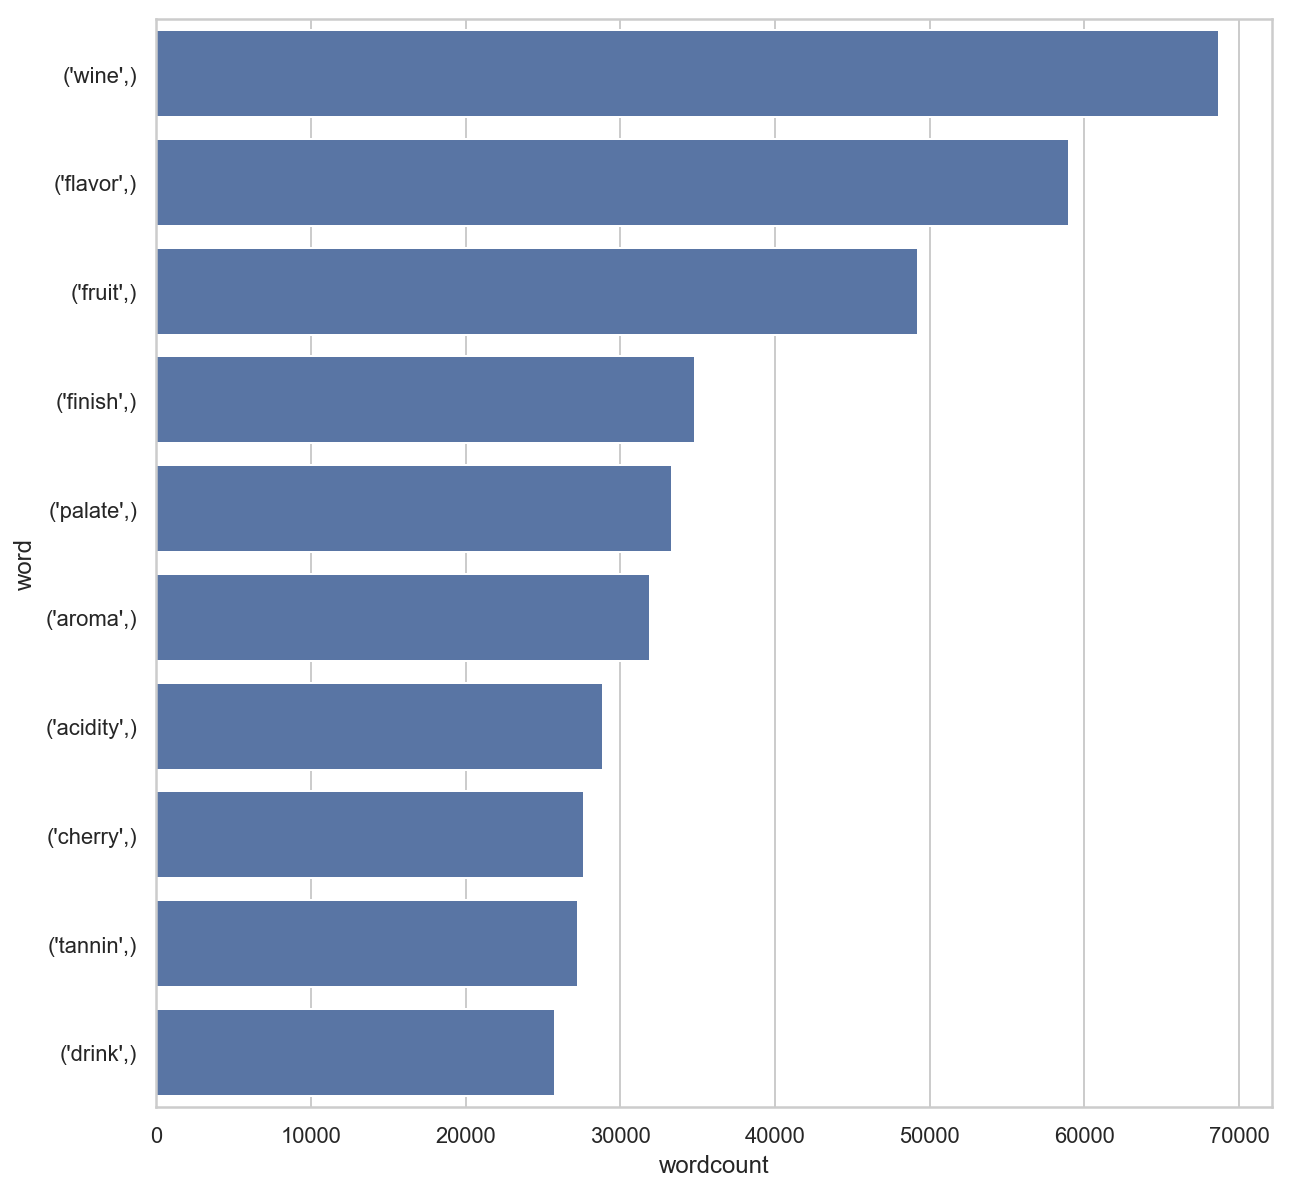

In [107]:
unigram = ngram_dist_plot(train_df, 'description', 1)

##### Bi-gram

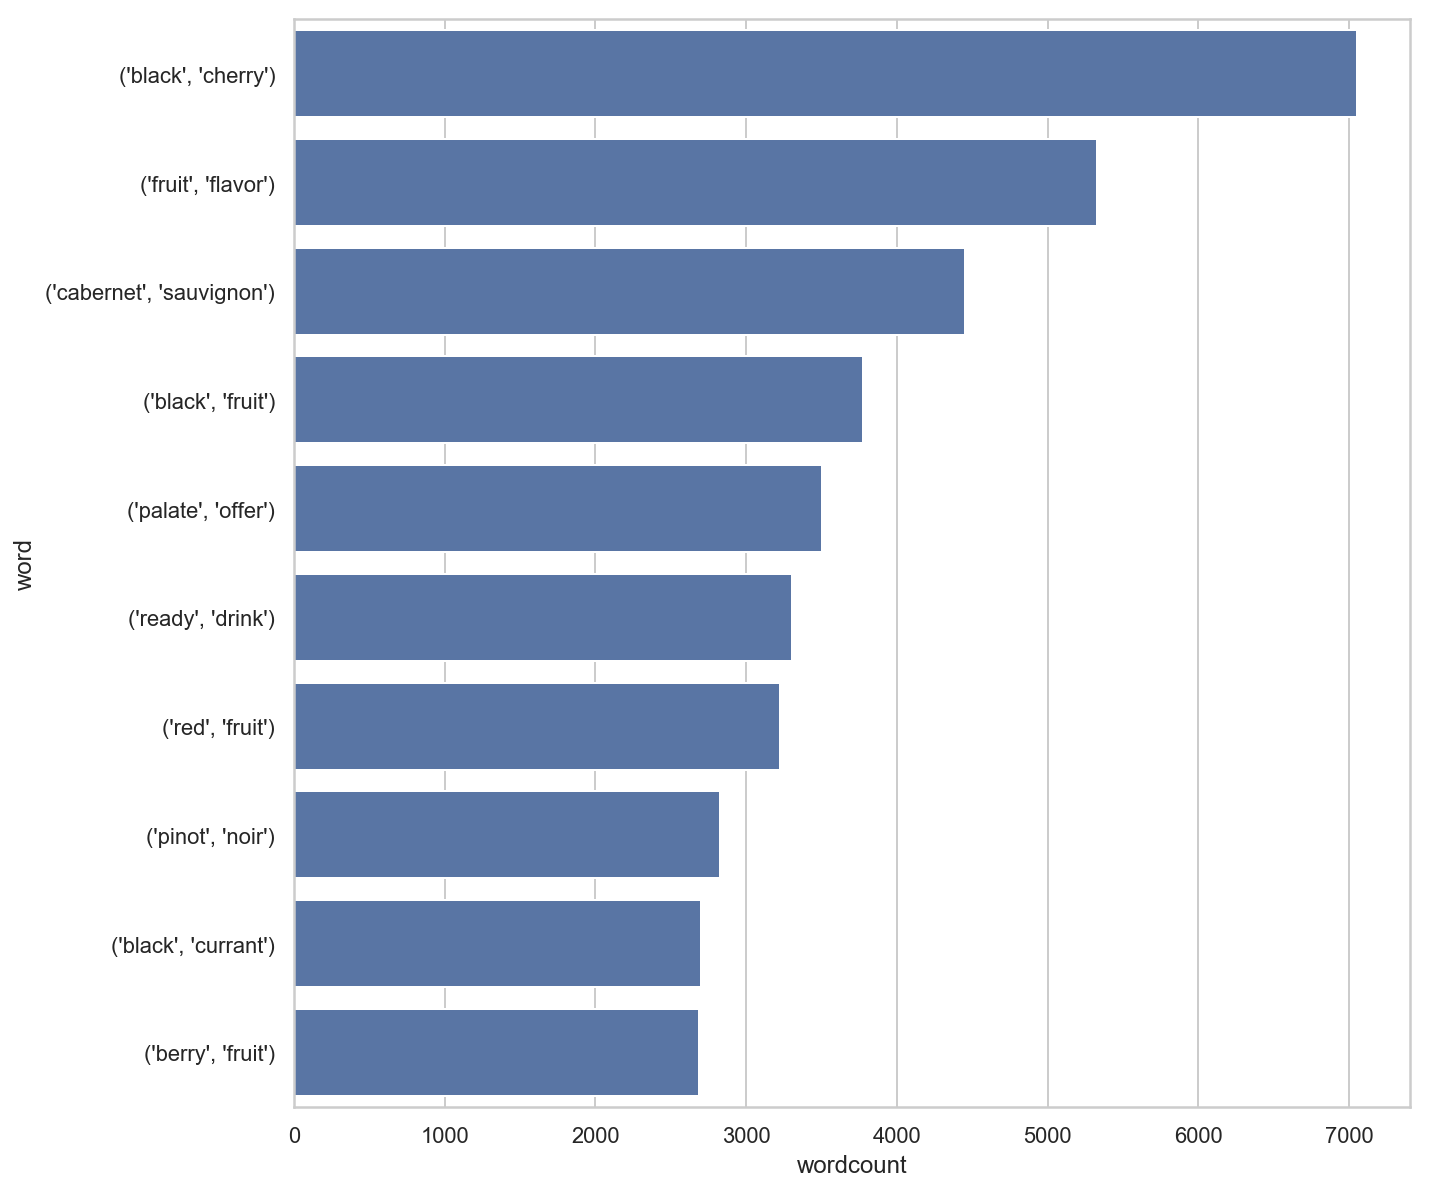

In [108]:
ngram_dist_plot(train_df, 'description', 2)

##### Tri-gram

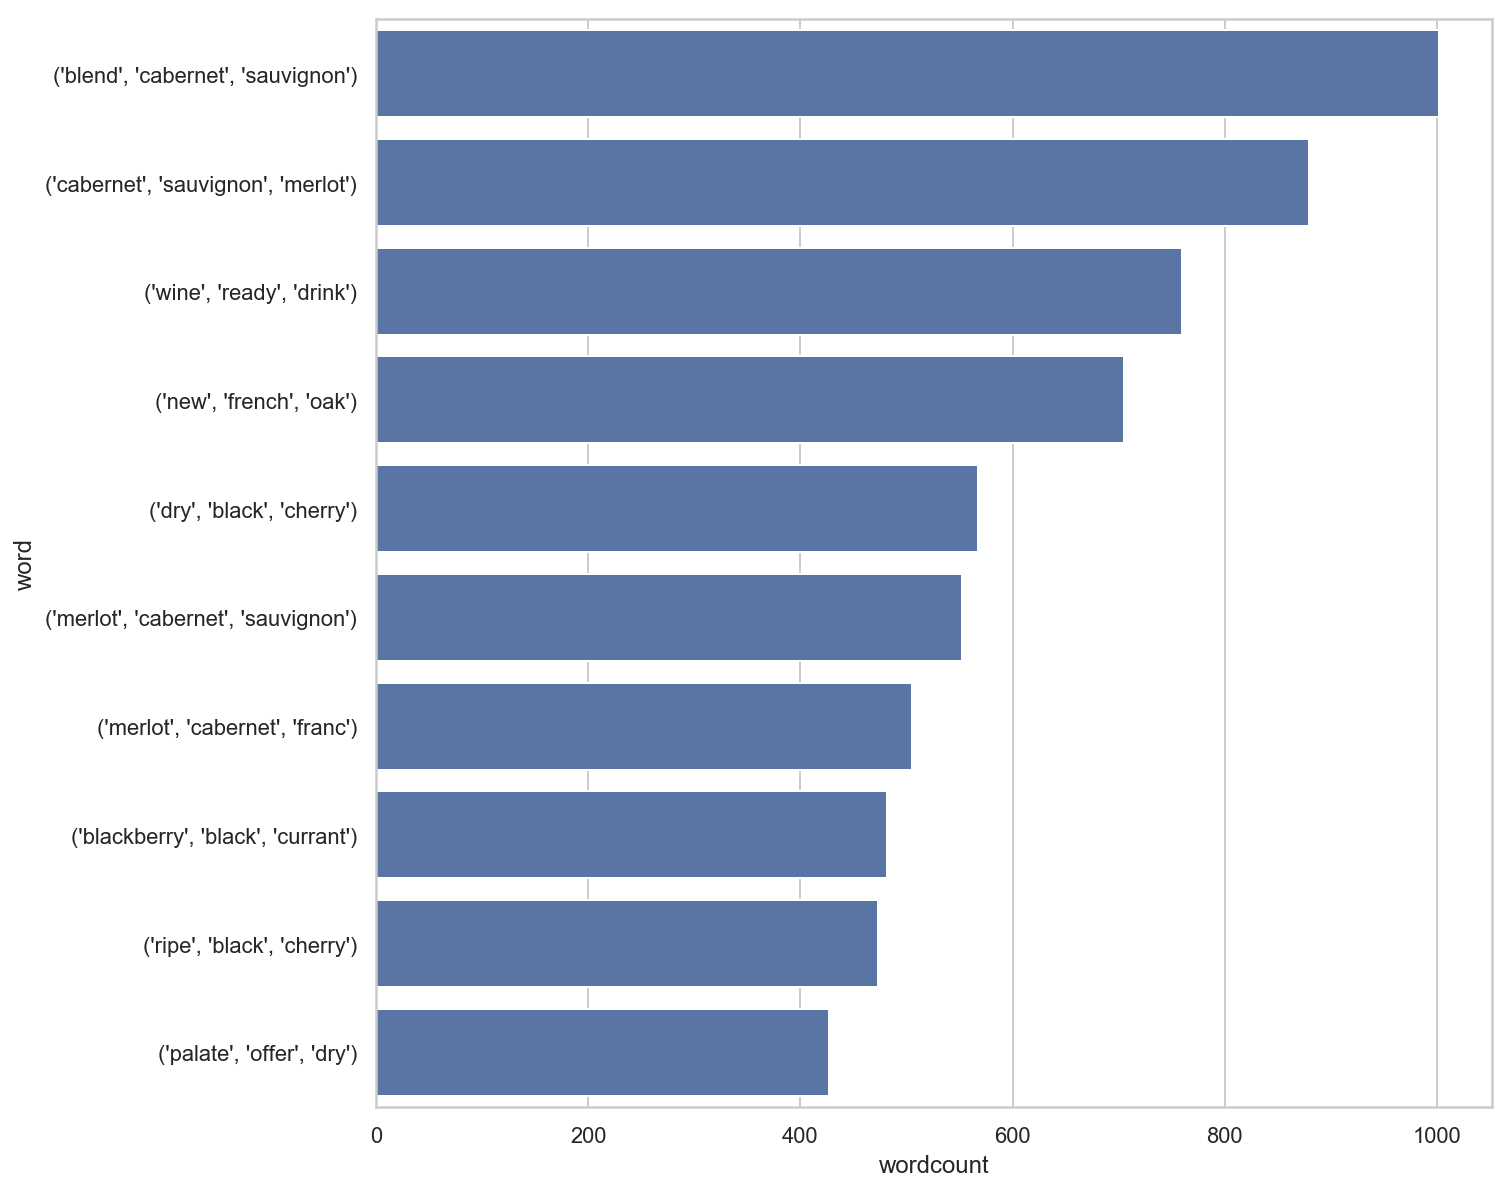

In [109]:
ngram_dist_plot(train_df, 'description', 3)

맛을 표현하는 수식은 '형용사+명사' 구조로 표현되는 경우가 많습니다. 따라서 이를 반영하기 위해서 텍스트를 Bigram 단위까지 vectorizing해야할 필요가 있습니다.

In [110]:
cv = CountVectorizer(stop_words='english',
                     ngram_range=(1, 2),
                     min_df=0.001)

In [111]:
review = cv.fit_transform(train_df['description'])
review = review.toarray()

## Dimension reduction
### Stacked auto-encoder
- Semi-supervised learning
- Feature matix의 latent space를 확보합니다.
- sparse한 one-hot encoding 값을 연속적인 수치형 데이터로 바꾸어 선형 회귀분석에 적합하게 만듭니다.

In [112]:
torch.manual_seed(42)

In [113]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [114]:
class Reviewset(Dataset):
    
    def __init__(self, X, y):
        self.len = X.shape[0]
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y)
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]
 

In [115]:
EPOCH = 10
BATCH_SIZE = 256
LEARNING_RATE= 0.0001

X = review.astype(np.float32)
dataset = Reviewset(X, train_df['price'].values)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [116]:
class ReviewAutoencoder(nn.Module):
    def __init__(self):
        super(ReviewAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(4157, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, 4157)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [117]:
ReviewAutoencoder = ReviewAutoencoder().to(DEVICE)
optimizer = torch.optim.Adam(ReviewAutoencoder.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

---

In [118]:
# %%time
# for epoch in range(1, EPOCH+1):
    
#     for x, _ in train_loader:
#         encoded, decoded = ReviewAutoencoder(x)
#         loss = criterion(decoded, x)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()   

#     print('epoch [{}/{}], loss:{:.4f}'
#           .format(epoch, EPOCH, loss.item()))

# torch.save(ReviewAutoencoder.state_dict(), 
#           "./output/auto_encoder/ReviewAutoencoder_state_dict.pth")

---

##### ReviewAutoencoder_state_dict.pth
```
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(4157, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, 4157)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
```

In [119]:
rae = ReviewAutoencoder
rae.load_state_dict(torch.load("./output/auto_encoder/ReviewAutoencoder_state_dict.pth"))
rae

ReviewAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4157, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=4157, bias=True)
  )
)

---

### Make Dataset

In [120]:
ae_description = rae.encoder(dataset.x_data)
ae_description = ae_description.detach().numpy()
ae_description = pd.DataFrame(ae_description, columns=['review_vect'])

In [121]:
train_df = train_df.reset_index(drop=True)
train_df = pd.concat([train_df, ae_description], axis=1)

In [122]:
del rae
del ae_description

In [123]:
train_df.drop(columns='description', inplace=True)

In [124]:
# train_df[['review_vect']].to_csv("./data/vectorized_description.csv", index=False)

---

### Remove outlier in advance
- `price`의 z-value를 기준으로 가격이 지나치게 높아 모델 훈련에 해가 되는 outlier를 사전에 제거하는 작업을 합니다.

In [125]:
outliers = train_df.loc[abs(zscore(train_df['price'])) > 2, :]
print("Threshold of price outliers:", outliers['price'].min())
print("Number of outliers removed:", len(outliers), "\t")
print("{}% of data has been removed.".format(round(len(outliers) / len(train_df) * 100), 2))
train_df.drop(index=outliers.index, inplace=True)

Threshold of price outliers: 120.0
Number of outliers removed: 2553 	
2% of data has been removed.


---

# Feature engineering

## One hot encoding

One hot encoding은 차원이 지나치게 증가하여 차원의 저주 문제를 발생시키고 메모리 부담이 커져 비효율적인 작업이 이루어지는 문제가 있습니다. 따라서 One hot encoding은 L1 regularization을 통한 feature selection 작업을 통해 가격에 실질적으로 영향을 미치는 세부 카테고리 변수가 어떤 것인지 파악하기 위한 용도와, one hot encoding의 문제에 대한 대책으로 적용한 target encoding과의 모델 결과 비교 용도로만 활용하고 최종 모델에는 반영하지 않았습니다.

In [126]:
def one_hot(df, column, drop=True):
    one_hot = pd.get_dummies(df[column], prefix=column[0])
    df = pd.concat([df, one_hot], axis=1)
    if drop:
        df.drop(columns=column, inplace=True)
#     print("Shape of dataset:", df.shape)
    return df

In [127]:
%%time
onehot_train_df = deepcopy(train_df)
onehot_train_df = one_hot(onehot_train_df, 'country')
onehot_train_df = one_hot(onehot_train_df, 'province')
onehot_train_df = one_hot(onehot_train_df, 'region_1')
onehot_train_df = one_hot(onehot_train_df, 'winery')
onehot_train_df = one_hot(onehot_train_df, 'variety')
onehot_train_df = one_hot(onehot_train_df, 'vintage')
onehot_train_df = one_hot(onehot_train_df, 'taster_name')

CPU times: user 47.9 s, sys: 15.6 s, total: 1min 3s
Wall time: 1min 4s


In [128]:
onehot_train_df.shape

(108984, 18110)

### Vectorize `description`
`designation`은 포도의 유통 및 관리 방식을 의미하는 개념과 포도원(농장)의 이름이 혼재되어 있으며 누락 데이터의 비율이 높고 각 카테고리가 매우 높은 high cardinality feature입니다. 따라서 `designation`를 텍스트 데이터로 간주하여 scikit-learn 라이브러리의 `CountVectorizer`를 활용하여 높은 빈도로 등장하는 포도의 유통 및 관리 방식을 의미하는 개념만을 추출해 보았습니다.
- scikit-learn 라이브러리의 `CountVectorizer` 활용

In [129]:
def remove_special_numbers(sentence):
    
    text = ''.join([word for word in sentence if not word.isdigit()])
    stripped = re.sub("[^\w\s]", '', text)
    stripped = re.sub("_", '', stripped)
    stripped = re.sub(r"\b[a-zA-Z]\b", "", stripped)
    stripped = re.sub("\s+", " ", stripped)

    return stripped.strip()

In [130]:
onehot_train_df['designation'] = train_df['designation'].apply(lambda x: x.lower())
onehot_train_df['designation'] = train_df['designation'].apply(remove_special_numbers)

In [131]:
vect = CountVectorizer(stop_words={'winery', 'wine'}, 
                       ngram_range=(1, 2),
                       max_features=100) # max_features로 빈도가 높은 값을 추출
X = vect.fit_transform(onehot_train_df['designation'])
print("Number of extracted designation features: ", X.shape[1])

Number of extracted designation features:  100


#### Caution!
dtype을 직접 지정하지 않을 경우, feature의 값이 대부분 0 혹은 1임에도 dtype이 int64로 적용되면서 불필요한 메모리가 쌓여 속도가 느려지고 커널이 죽는 문제가 발생할 수 있습니다. 이러한 현상을 방지하기 위해 꼭 dtype을 np.uint8로 지정해야 합니다.

In [132]:
%%time
feature_names = ["d_"+i for i in vect.get_feature_names()]
vect_df = pd.DataFrame(X.todense(), columns=feature_names, dtype=np.uint8)
onehot_train_df = onehot_train_df.reset_index(drop=True)
onehot_train_df = pd.concat([onehot_train_df, vect_df], axis=1)

CPU times: user 1.96 s, sys: 1.56 s, total: 3.51 s
Wall time: 3.51 s


In [133]:
del X
del vect_df

In [134]:
onehot_train_df.drop(columns='title', inplace=True)
onehot_train_df.drop(columns='designation', inplace=True)
onehot_train_df.shape

(108984, 18208)

### Feature selection
- L1-based feature selection  

L1(=Lasso) regularization 작업을 통해 일부를 선별하고 feature vector의 차원을 축소하는 작업을 하겠습니다.

### Remove some feature
- 반복적인 모델링 과정에서 관측된 훈련과 분석을 어렵게 하는 feature들을 제거합니다.

In [135]:
# unknown
onehot_train_df.drop(columns='r_unknown', inplace=True)
onehot_train_df.drop(columns='d_unknown', inplace=True)
onehot_train_df.drop(columns='t_unknown', inplace=True)

# unknown vintage
onehot_train_df.drop(columns='v_nan', inplace=True)

# designation 텍스트에 포함된 조사, 전치사 같은 불필요한 요소
onehot_train_df.drop(columns='d_the', inplace=True)
onehot_train_df.drop(columns='d_de', inplace=True)
onehot_train_df.drop(columns='d_of', inplace=True)
onehot_train_df.drop(columns='d_les', inplace=True)
onehot_train_df.drop(columns='d_di', inplace=True)
onehot_train_df.drop(columns='d_le', inplace=True)
onehot_train_df.drop(columns='d_du', inplace=True)
onehot_train_df.drop(columns='d_da', inplace=True)
onehot_train_df.drop(columns='d_do', inplace=True)

# d_Champagne와 조합될 경우 회귀계수가 지나치게 집중되는 문제가 있음
onehot_train_df.drop(columns='r_Champagne', inplace=True) 

In [136]:
onehot_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108984 entries, 0 to 108983
Columns: 18194 entries, points to d_white
dtypes: float32(1), float64(2), uint8(18191)
memory usage: 1.8 GB


### Train Test Split
- 데이터를 Train set, Validation set, Test set으로 나눕니다.

In [137]:
X = onehot_train_df.drop(columns='price')
y = np.log(onehot_train_df['price']) 

In [138]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

print("train_set size :", X_train.shape) # 60%
print("validation_set size :", X_val.shape) # 20%
print("test_set size :", X_test.shape) # 20%

train_set size : (65390, 18193)
validation_set size : (21797, 18193)
test_set size : (21797, 18193)


In [139]:
# del onehot_train_df
del X
del y

### Feature selection with `SelectFromModel`
- `Lasso`와 `SelectFromModel`를 통해서 feature를 선별하는 작업을 진행합니다.

L1 regularization은 가중치의 **절대값**의 합을 최소화하는 것을 추가적인 제약 조건으로 걸어서 입력된 독립변수 중 일부를 0으로 빠르게 수렴하도록 만들고 overfitting을 방지하는 효과가 있습니다. 이러한 특성으로 L1 regularization은 중요한 변수를 선택하는 효과가 있으며 몇 개의 변수만 선택적으로 0이 아닌 계수를 가지도록 하기 때문에 sparse modeling 이라고도 부릅니다. 이 과정을 통해 성능을 저하하지 않으면서도 모델에 사용할 features의 개수를 최소화할 수 있는데, 주로 타겟에 대한 레버리지가 높으면서도 많은 데이터에서 등장한 독립변수가 선택됩니다.  

In [140]:
# %%time
# alpha = 0.001
# threshold = 0.01
# sfm_lasso = SelectFromModel(estimator=Lasso(alpha=alpha),
#                             threshold=threshold)
# sfm_lasso.fit(X_train, y_train)

KeyboardInterrupt: 

In [141]:
# joblib.dump(sfm_lasso, './output/less_designation_sfm_lasso.pkl')

In [144]:
sfm_lasso = joblib.load('./output/less_designation_sfm_lasso.pkl')

---

### 참고: `LassoCV`
`LassoCV`는 반복적인 cross-validation을 통해 가장 좋은 alpha 값을 선택하여 lasso regression 작업을 수행하는 모델입니다. 이 모델 객체를 `SelectFromModel`의 인자로 전달하여 계수가 0에 수렴하지 않는 적절한 feature를 선별할 수 있습니다.

```
clf = LassoCV(cv=5, alphas=[0.01, 0.001], random_state=42)
sfm_lasso = SelectFromModel(estimator=clf, threshold=0.1)
sfm_lasso.fit(X_train, y_train)
```

---

In [145]:
X_l1_train = sfm_lasso.transform(X_train)
n_features = X_l1_train.shape[1]
print("Number of selected features:", n_features)

Number of selected features: 79


In [146]:
features = X_val.columns[sfm_lasso.get_support()]

In [147]:
X_l1_train = pd.DataFrame(X_l1_train, columns=features)
# X_l1_train.to_csv(IDIR + "X_l1_train.csv", index=False)

In [148]:
X_l1_val = X_val.loc[:, sfm_lasso.get_support()]
# X_l1_val.to_csv(IDIR + "X_l1_val.csv", index=False)

In [149]:
X_l1_test = X_test.loc[:, sfm_lasso.get_support()]
# X_l1_test.to_csv(IDIR + "X_l1_test.csv", index=False)

In [150]:
X_l1_train.shape, X_l1_val.shape, X_l1_test.shape

((65390, 79), (21797, 79), (21797, 79))

In [ ]:
# X_l1_train = pd.read_csv(IDIR + "X_l1_train.csv")
# X_l1_test = pd.read_csv(IDIR + "X_l1_test.csv")
# X_l1_val = pd.read_csv(IDIR + "X_l1_val.csv") 

---

# Modeling
- 위의 과정을 통해서 만든 최종 feature matrix로 회귀분석 모델링을 진행합니다.

## Linear Regression with selected features(by L1 regularization)
- One hot encoding된 데이터를 L1 regularization을 통한 feature selection과정을 거쳐 총 79개의 feature를 선택하여 선형 회귀분석한 결과

In [151]:
ols = sm.OLS(y_train.values, X_l1_train)
ols_result = ols.fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 2.805e+04
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:35:24   Log-Likelihood:                -55184.
No. Observations:               65390   AIC:                         1.105e+05
Df Residuals:                   65311   BIC:                         1.112e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [152]:
print("Model's train R-squared score:", ols_result.rsquared)

Model's train R-squared score: 0.971373380479987


### Coef
- 회귀 분석에 활용된 feature들의 회귀 계수 결과입니다.

정확한 회귀계수 분석을 위하여, 단일계수 t 검정의 p-value가 5% 이상인 feature는 제외합니다.

In [153]:
params = ols_result.params[ols_result.pvalues < 0.05]
excluded_features = ols_result.params[ols_result.pvalues >= 0.05]
print("단일계수 t 검정의 p-value가 5% 이하인 feature 갯수:")
print(excluded_features.index, "를 제외한", len(params), "개")

단일계수 t 검정의 p-value가 5% 이하인 feature 갯수:
Index(['p_Port', 'p_Sicily & Sardinia', 'r_Mendoza', 'v_Pinot Grigio',
       'v_Portuguese White', 'v_2013.0', 'd_cru', 'd_dry'],
      dtype='object') 를 제외한 71 개


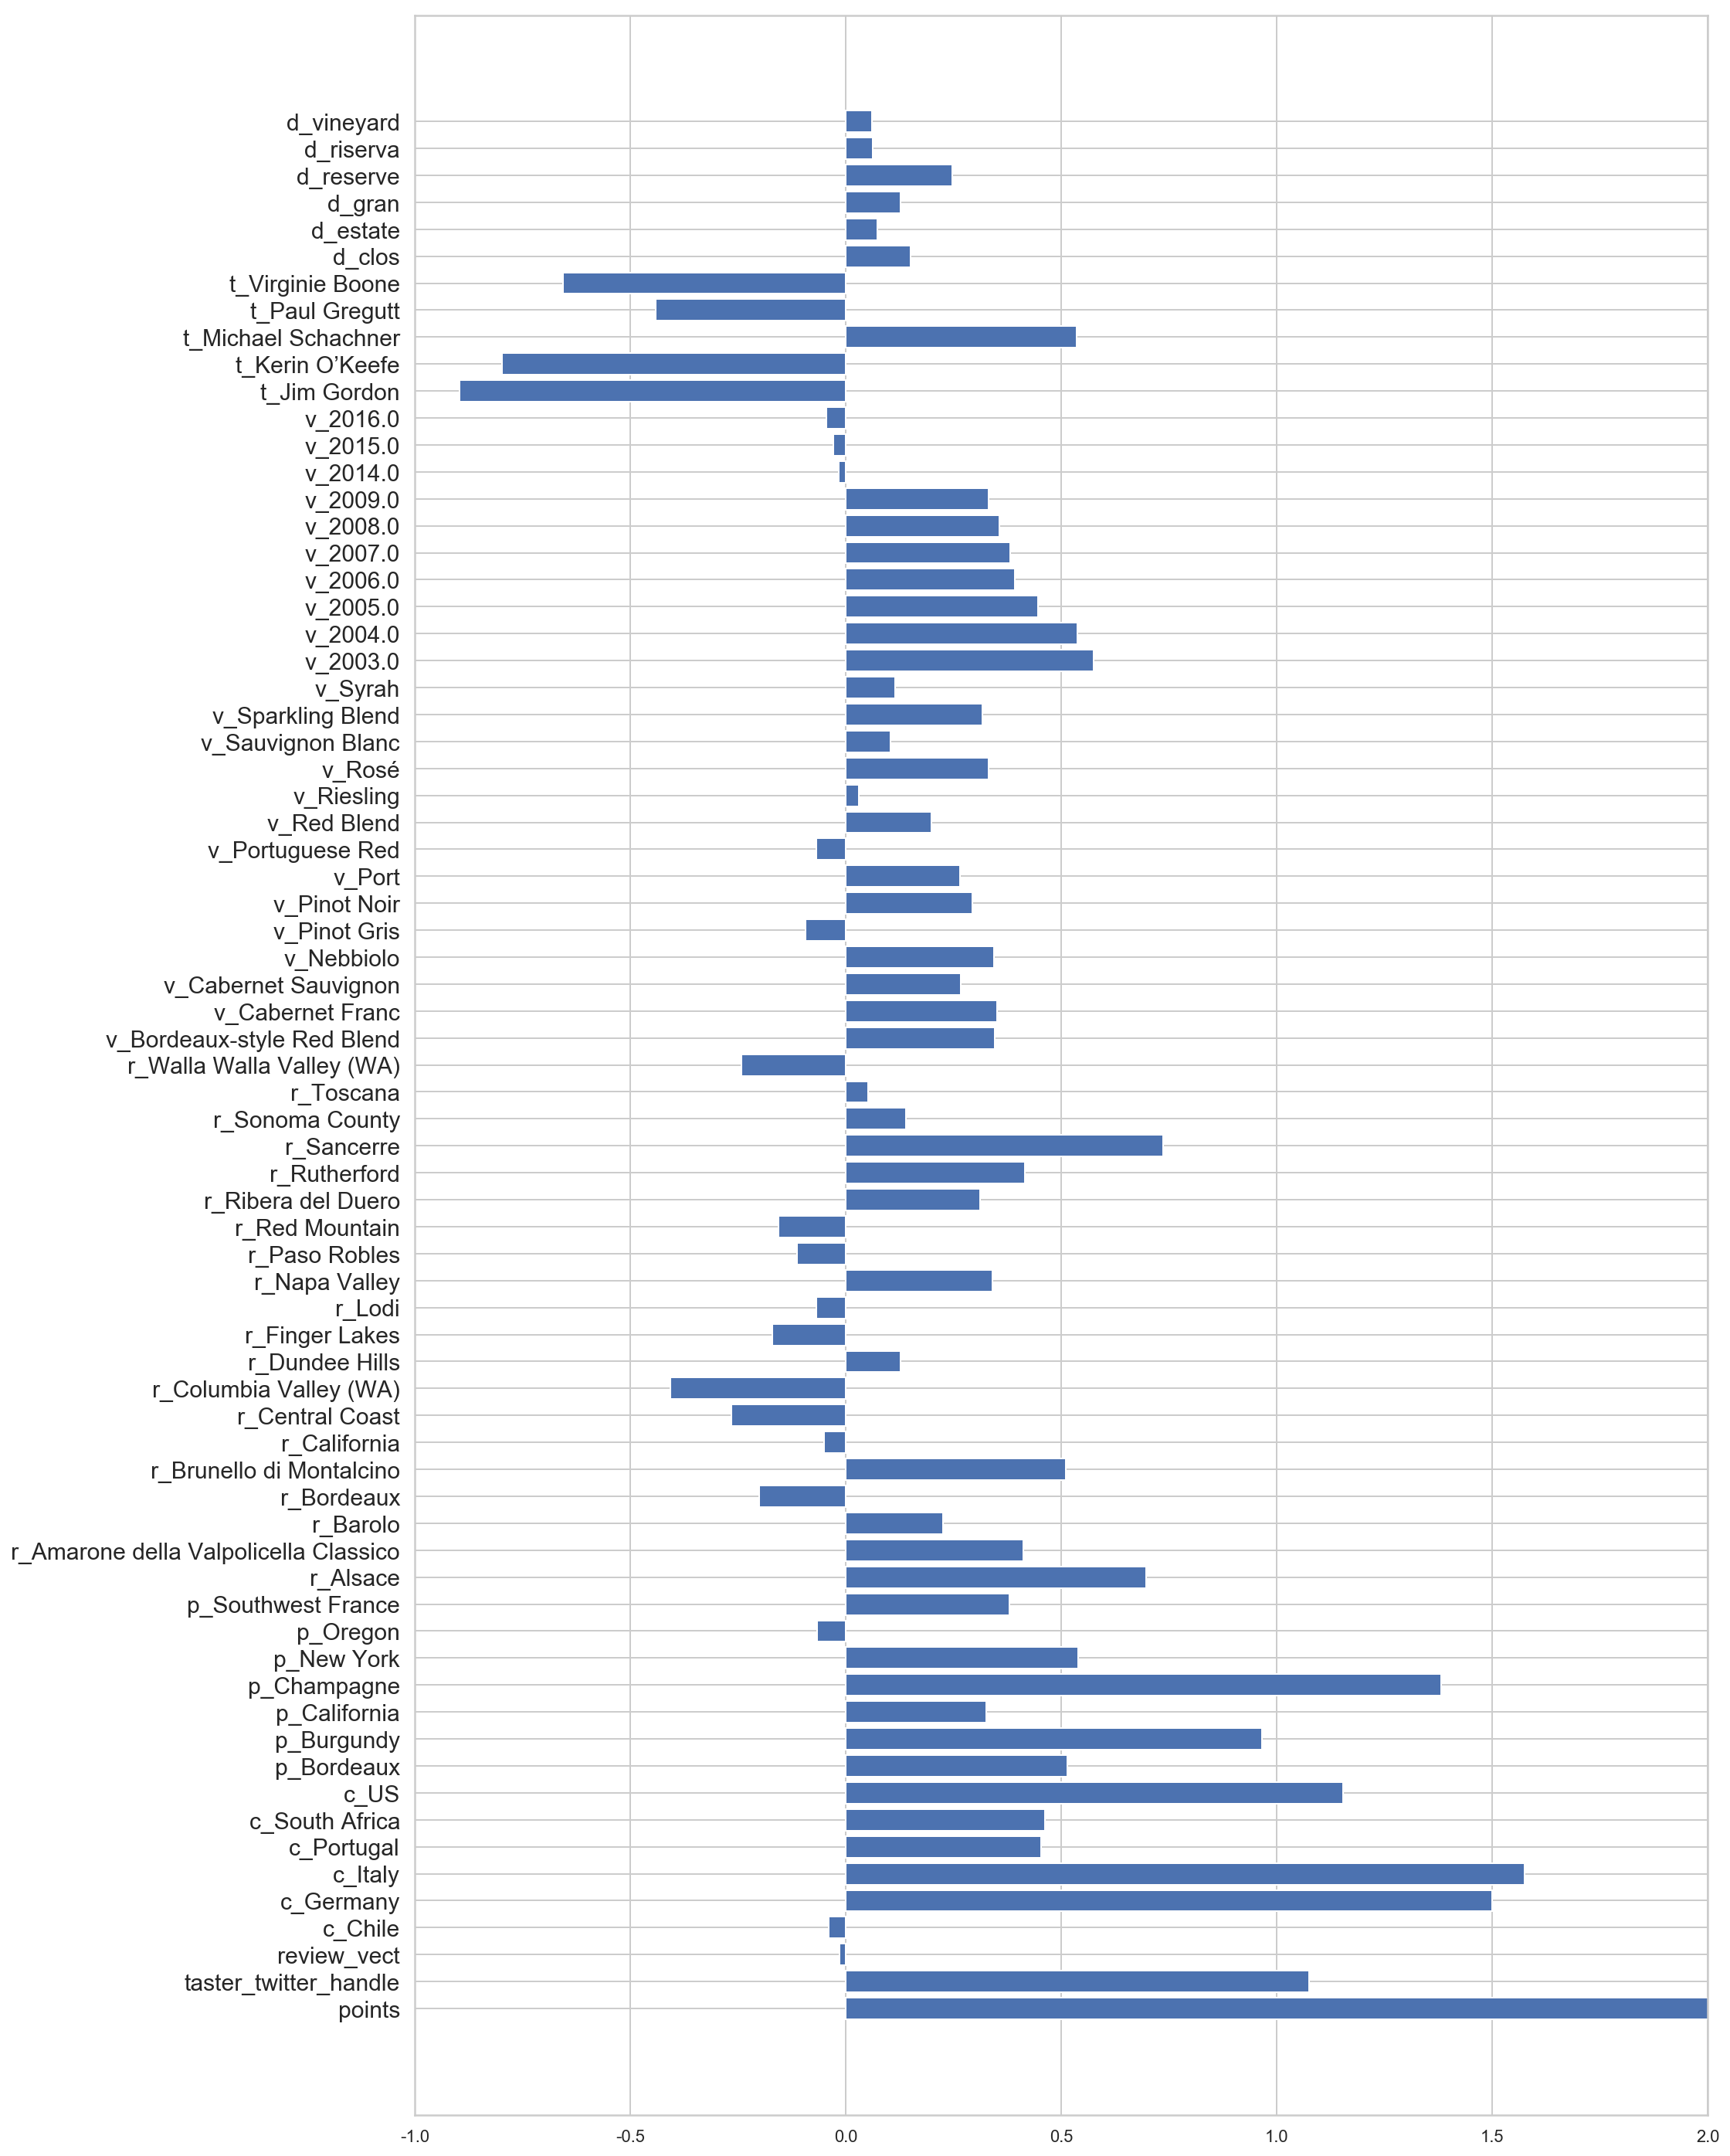

In [154]:
plt.figure(figsize=(15, 25))
plt.barh(params.index, params)
plt.xlim(-1, 2)
plt.yticks(fontsize=15)
plt.show()

>1. 가장 coef가 높은 feature은 `points` 입니다. 종속 변수인 `price`와의 양적 상관관계가 반영되었습니다.
1. vintage는 2003년까지 시간을 거슬러 올라갈수록 가치가 상승합니다.
1. variety에서 백포도 품종(Sauvignon Blanc, Riesling, Pino Gris 등)에 비해서 적포도 품종(Cabernet Sauvignon, Syrah, Nebbiolo 등)이 가격에 대한 영향력이 더 강하고 가치가 높은 편입니다.
1. `winery`의 모든 값들이 feature selection 과정에서 탈락되었습니다. 
1. country 중 ‘미국, 남아프리카, 포르투갈, 이탈리아, 독일, 칠레’가 feature selection 결과로 선택되었습니다.


---

## Model validation

### Metrics
RMSE(Root mean squared error)
$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$

In [155]:
y_pred = ols_result.predict(X_l1_test)

In [156]:
print("RMSE score of test set:", np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred))))

RMSE score of test set: 21.346859478400802


### Cross validation
- Check if Overfitting

In [157]:
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(X_l1_train)):
    dfX_train = X_l1_train.iloc[idx_train]
    dfy_train = y_train.iloc[idx_train]
    dfX_test = X_l1_train.iloc[idx_test]
    dfy_test = y_train.iloc[idx_test]
    
    model = sm.OLS(dfy_train.values, dfX_train)
    cv_result = model.fit()
    
    pred = cv_result.predict(dfX_test)
    rmse = np.sqrt(mean_squared_error(np.exp(dfy_test), np.exp(pred)))
    
    scores[i] = rmse

print("cv scores:", scores)

cv scores: [21.31918813 21.04491947 21.44173443 21.27667076 20.95184523]


교차검증 결과, 일관된 값으로 과최적화 문제는 발견되지 않았습니다.

---

## Target encoding (=mean encoding)
- categorical feature를 카테고리 단위로 groupby 하여 target에 대한 평균값으로 연산하는 인코딩 방식입니다.
- High cardinality categorical feature에 적합한 방식이며 One hot encoding과 label encoding과 비교했을 때 차원이 증가하는 문제를 방지하면서도 feature와 target의 상관관계를 반영할 수 있다는 장점이 있습니다.
- http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html

### Train Test Split
- 데이터를 Train set, Validation set, Test set으로 나눕니다.

In [160]:
X = train_df.drop(columns='price')
y = np.log(train_df['price']) # Make it similar to normal distribution for better training

In [161]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

print("train_set size :", X_train.shape) # 60%
print("validation_set size :", X_val.shape) # 20%
print("test_set size :", X_test.shape) # 20%

train_set size : (65390, 12)
validation_set size : (21797, 12)
test_set size : (21797, 12)


---

## Target encoding (=mean encoding)
- categorical feature를 카테고리 단위로 groupby 하여 target에 대한 평균값으로 연산하는 인코딩 방식입니다.
- High cardinality categorical feature에 적합한 방식이며 One hot encoding과 label encoding과 비교했을 때 차원이 증가하는 문제를 방지하면서도 feature와 target의 상관관계를 반영할 수 있다는 장점이 있습니다.
- http://contrib.scikit-learn.org/categorical-encoding/targetencoder.html

### Encode dataframe

In [162]:
encoder = ce.TargetEncoder(cols=['country', 'designation', 'province', 
                                 'region_1', 'taster_name', 'variety', 
                                 'winery', 'vintage'])

In [163]:
encoder.fit(X_train, y_train)

TargetEncoder(cols=['country', 'designation', 'province', 'region_1', 'taster_name', 'variety', 'winery', 'vintage'],
       drop_invariant=False, handle_missing='value',
       handle_unknown='value', min_samples_leaf=1, return_df=True,
       smoothing=1.0, verbose=0)

In [164]:
encoded_X_train = encoder.transform(X_train, y_train)
encoded_X_train = encoded_X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
encoded_train = pd.concat([encoded_X_train, y_train], axis=1)

In [165]:
encoded_X_val = encoder.transform(X_val, y_val)
encoded_X_val = encoded_X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
encoded_val = pd.concat([encoded_X_val, y_val], axis=1)

In [167]:
encoded_X_test = encoder.transform(X_test, y_test)
encoded_X_test = encoded_X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
encoded_test = pd.concat([encoded_X_test, y_test], axis=1)

## Modeling
- Linear regression with Target encoding data

In [168]:
lm_1 = sm.OLS.from_formula("price ~ points + scale(country) + scale(designation) + scale(province) \
                            + scale(region_1) + scale(taster_name) + taster_twitter_handle \
                            + scale(variety) + scale(winery) + scale(vintage) + review_vect", 
                           data=encoded_train)

lm_1_result = lm_1.fit()
print(lm_1_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                 1.695e+04
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:36:54   Log-Likelihood:                -15133.
No. Observations:               65390   AIC:                         3.029e+04
Df Residuals:                   65378   BIC:                         3.040e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.90

>`country`의 경우 단일 계수 t검정에 대한 유의확률(p-value)이 유의수준 5%를 넘기 때문에, 귀무가설(H0: w = 0)을 채택하여 종속변수 `price`에 영향을 미치지 않는 변수로 분석하였습니다.

#### R-squared, RMSE score

In [169]:
first_pred = lm_1_result.predict(encoded_X_test)
first_rsquared = lm_1_result.rsquared
first_rmse = np.sqrt(mean_squared_error(np.exp(first_pred), np.exp(y_test)))
print("R-squared score:", first_rsquared)
print("RMSE score:", first_rmse)

R-squared score: 0.7403784161715321
RMSE score: 13.494477794537062


>앞의 One hot encoding 모델과 비교했을 때 R-squared는 약 0.21가 감소하지만, RMSE score가 9.57만큼 감소하는 의미 있는 성과가 있었습니다.


### F 검정을 사용한 변수 중요도 비교
- F 검정은 각 독립변수의 중요도를 비교하기 위해 사용할 수 있습니다. 전체 모형과 각 변수 하나만을 뺀 모형들의 성능을 비교하는 방법으로 중요도를 파악합니다. 이는 간접적으로 각 독립 변수의 영향력을 측정하는 것과 같습니다.
- `country`, `taster_name`, `taster_twitter_handle`의 경우 변수의 중요도가 가장 낮은 feature로 분석되었습니다.

In [170]:
sm.stats.anova_lm(lm_1_result, typ=2)

sum_sq       df             F         PR(>F)
points                 777.355817   1.0      8356.148340   0.000000e+00 
scale(country)         0.019959     1.0      0.214553      6.432236e-01 
scale(designation)     777.415626   1.0      8356.791256   0.000000e+00 
scale(province)        9.249329     1.0      99.425207     2.117131e-23 
scale(region_1)        361.124404   1.0      3881.889121   0.000000e+00 
scale(taster_name)     5.394037     1.0      57.982940     2.679378e-14 
taster_twitter_handle  0.196676     1.0      2.114156      1.459473e-01 
scale(variety)         131.402830   1.0      1412.508298   7.506541e-306
scale(winery)          1868.398396  1.0      20084.257182  0.000000e+00 
scale(vintage)         94.282936    1.0      1013.489810   1.032315e-220
review_vect            14.180497    1.0      152.432558    5.575964e-35 
Residual               6081.984971  65378.0 NaN           NaN

---

### Feature selection
- 위의 F 검정을 통해 중요도가 낮다고 판단한 `country`, `taster_name`, `taster_twitter_handle`를 제외한 모델링입니다.

#### `country`, `taster_name`, `taster_twitter_handle` 제외

In [171]:
lm_2 = sm.OLS.from_formula("price ~  points + scale(province) \
                        + scale(designation) + scale(region_1) + scale(variety) \
                        + scale(winery) + scale(vintage) + scale(review_vect)", 
                        data=encoded_train)

lm_2_result = lm_2.fit()
print(lm_2_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                 2.326e+04
Date:                Wed, 07 Aug 2019   Prob (F-statistic):               0.00
Time:                        22:37:07   Log-Likelihood:                -15180.
No. Observations:               65390   AIC:                         3.038e+04
Df Residuals:                   65381   BIC:                         3.046e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9119      0

### Visualize coef

In [172]:
lm_2_params = lm_2_result.params[lm_2_result.pvalues < 0.05]

In [173]:
features = ['points', 'scale(province)', 'scale(designation)', 
            'scale(region_1)', 'scale(variety)', 'scale(winery)',
            'scale(vintage)', 'scale(review_vect)']
lm_2_params = lm_2_params[features]

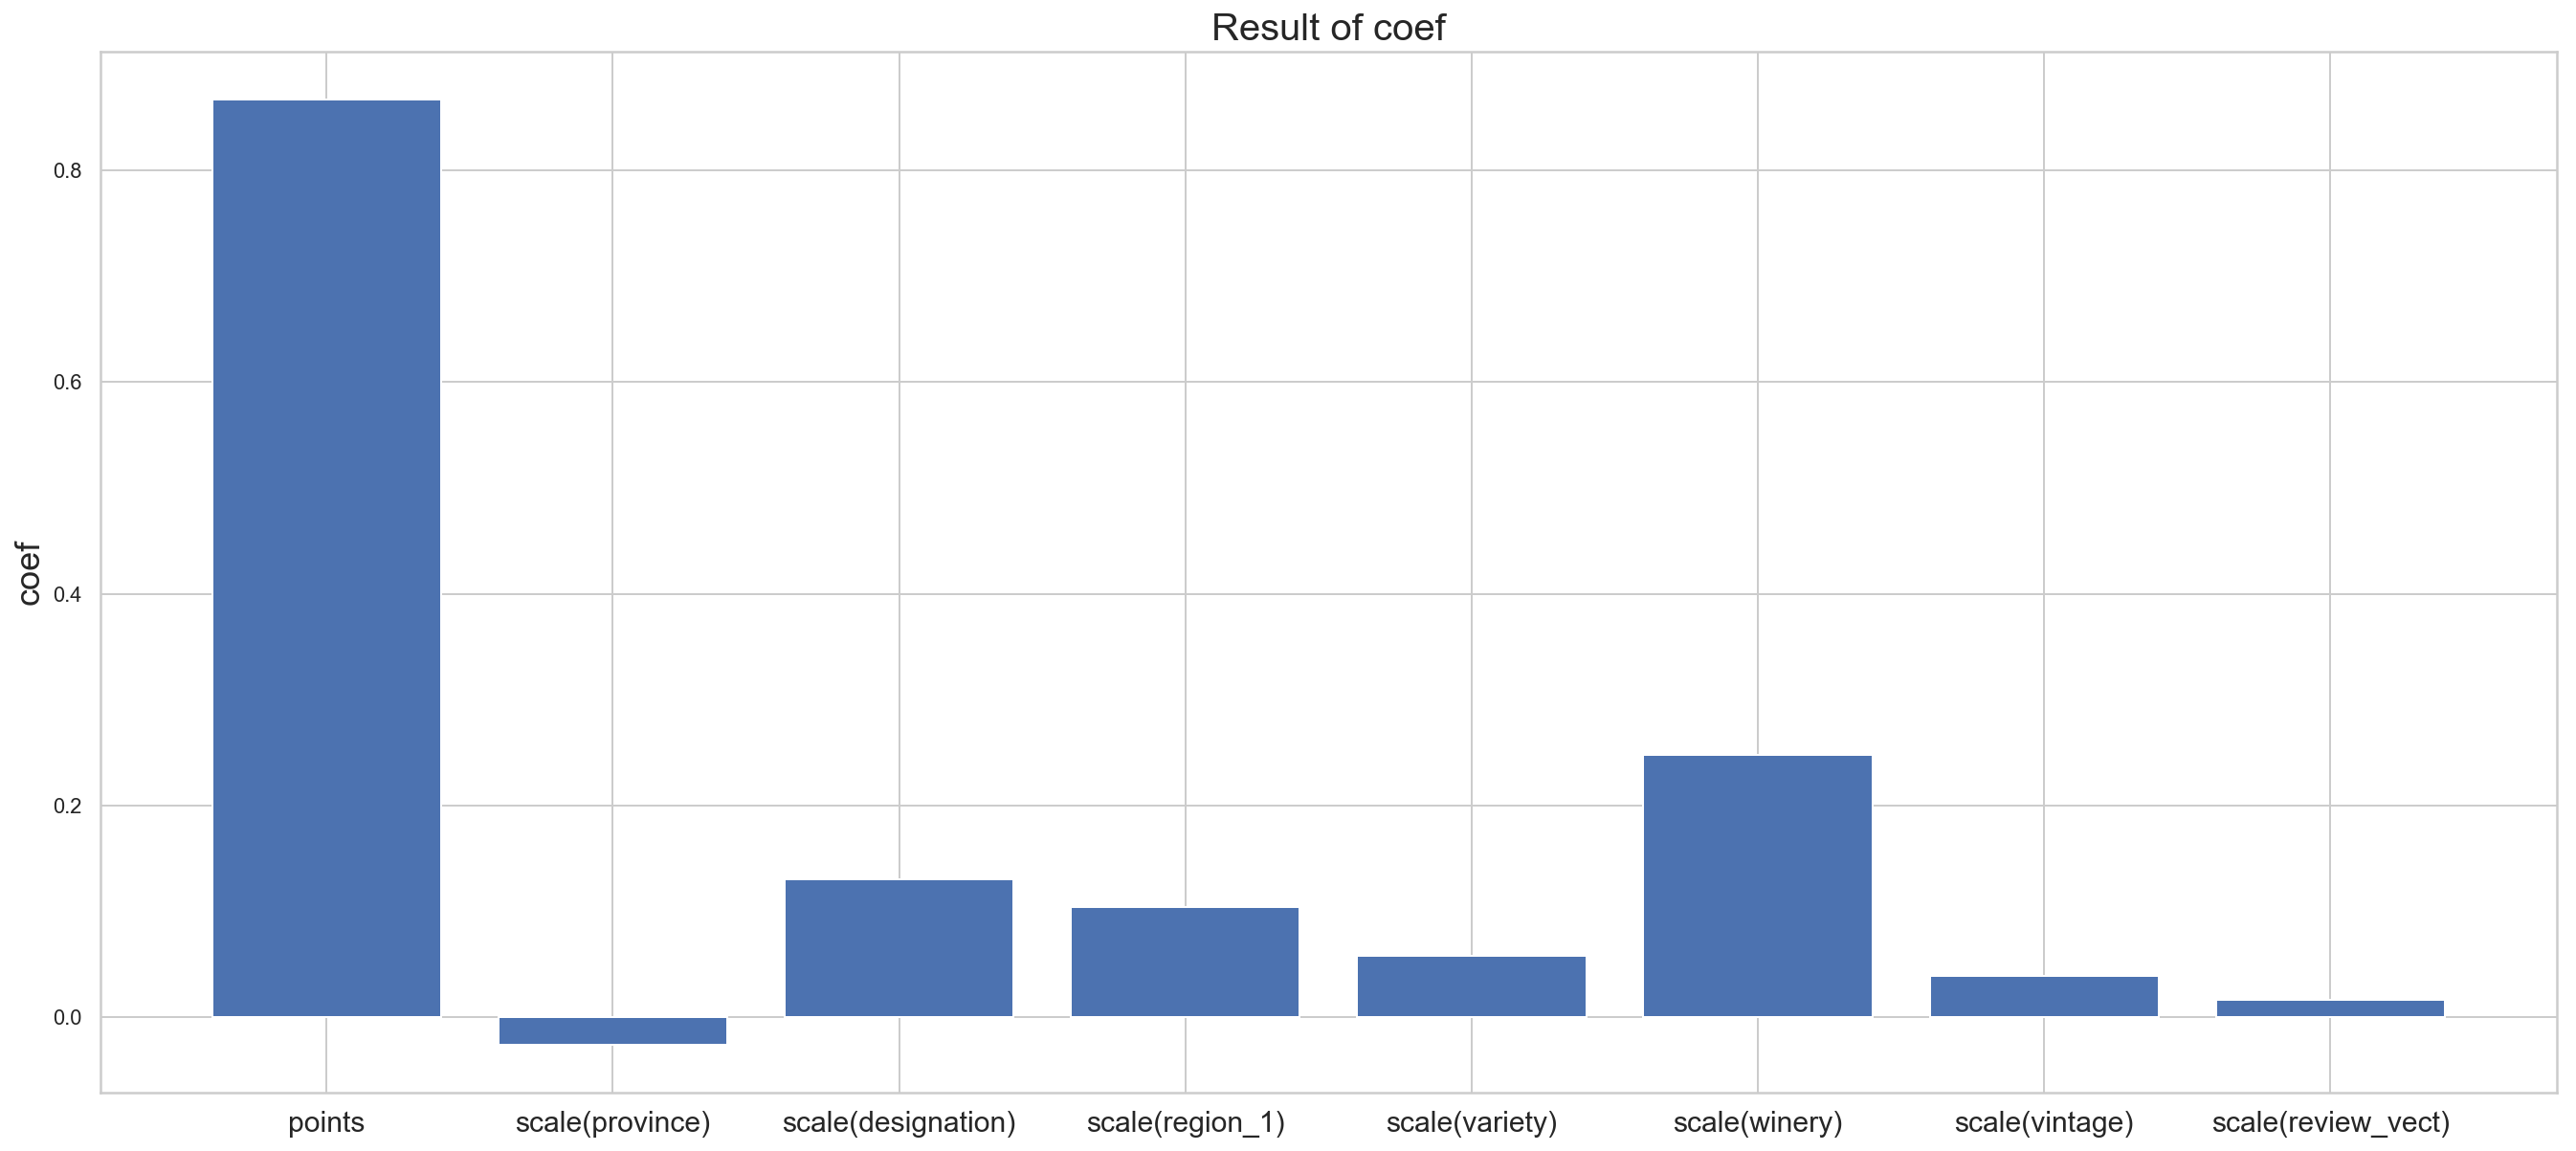

Intercept: 2.9528


In [174]:
plt.figure(figsize=(23, 10))
plt.bar(lm_2_params.index, lm_2_params)
# plt.xlim(-1, 1)
plt.xticks(fontsize=18)
plt.xticks(fontsize=15)
plt.title("Result of coef", fontsize=20)
plt.ylabel("coef", fontsize=18)
plt.show()
print("Intercept:", 2.9528)

#### R-squared, RMSE score

In [175]:
second_pred = lm_2_result.predict(encoded_X_test)
second_rsquared = lm_2_result.rsquared
second_rmse = np.sqrt(mean_squared_error(np.exp(second_pred), np.exp(y_test)))
print("R-squared score:", second_rsquared)
print("RMSE score:", second_rmse)

R-squared score: 0.7400045185273967
RMSE score: 13.514456571725036


In [176]:
pd.DataFrame([[first_rsquared, second_rsquared],
              [first_rmse, second_rmse]],
             index=['R_squared', 'RMSE'],
             columns=['All features', 'Selected features']
            )

All features  Selected features
R_squared  0.740378      0.740005         
RMSE       13.494478     13.514457

>위의 세 가지 feature를 제외해도 R-squared, rmse score에 변화가 없는 것을 확인할 수 있습니다.

#### Check overfitting
- cross validation을 통해 모델에 overfitting 문제가 있는지 판단합니다.

In [177]:
scores = np.zeros(5)
cv = KFold(5, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(encoded_train)):
    df_train = encoded_train.iloc[idx_train]
    df_test = encoded_train.iloc[idx_test]
    
    model = sm.OLS.from_formula("price ~  points + scale(province) \
                        + scale(designation) + scale(region_1) + scale(variety) \
                        + scale(winery) + scale(vintage) + scale(review_vect)", data=df_train)
    cv_result = model.fit()
    
    pred = cv_result.predict(df_test)
    rmse = np.sqrt(mean_squared_error(np.exp(df_test.price), np.exp(pred)))
    
    scores[i] = rmse

print("cv scores:", scores)

cv scores: [12.00268422 11.95215308 12.21701477 12.32480189 12.25761831]


> 5개의 결과값에 큰 차이가 없으므로 overfitting 문제는 없는 것으로 판단되었습니다.

### Check with plot
- 실제값과 예측값을 비교

Text(0, 0.5, 'y_pred')

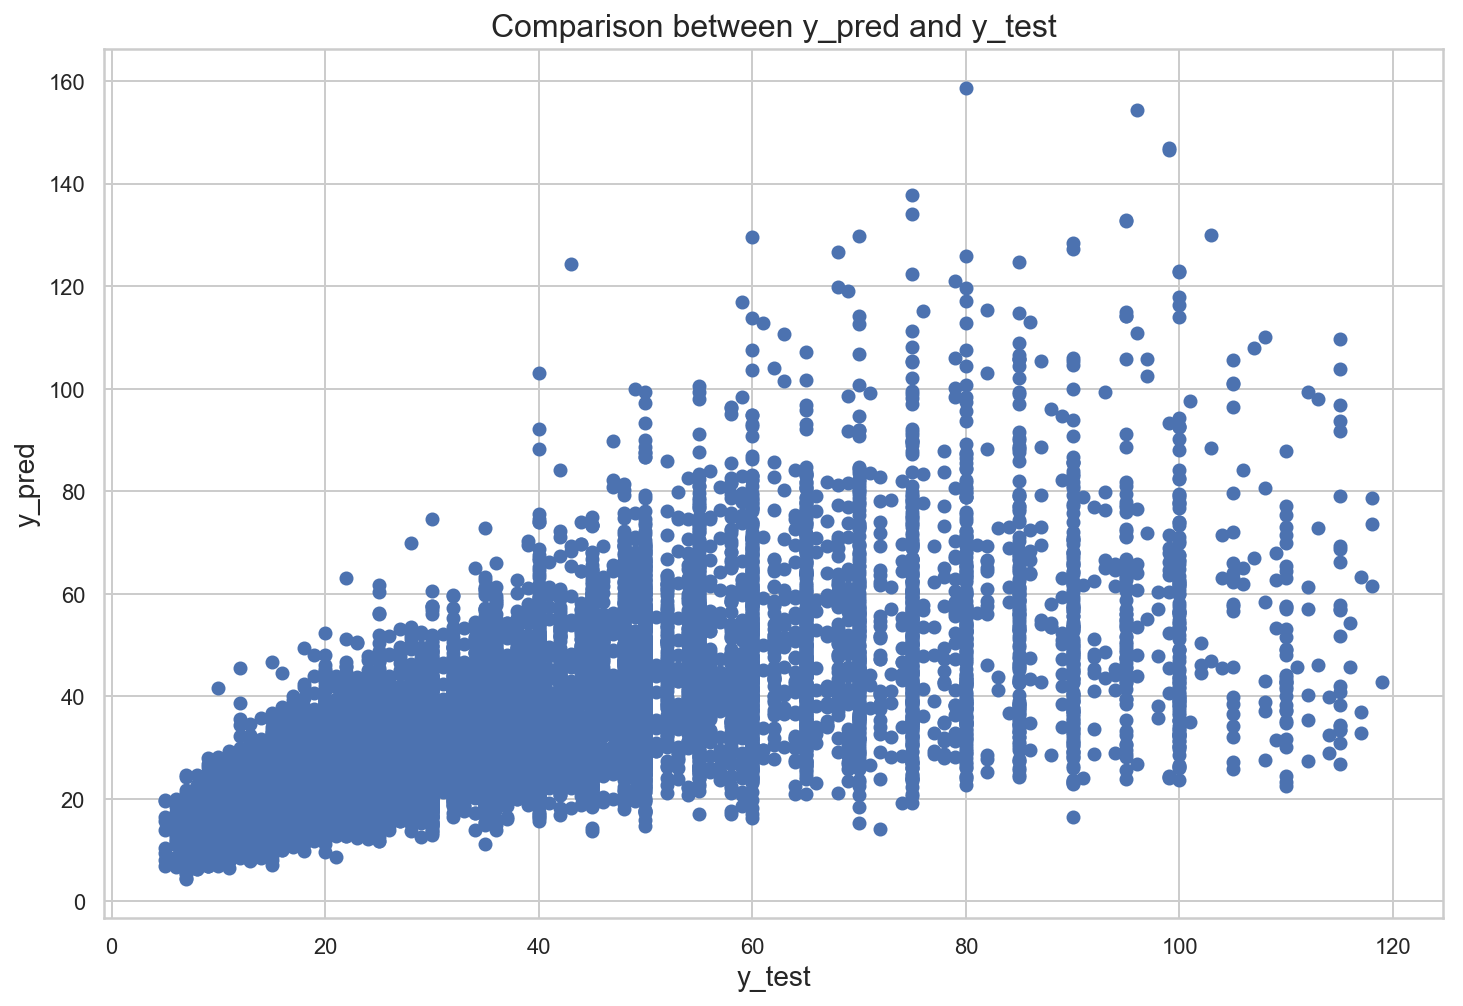

In [178]:
plt.figure(figsize=(12, 8))
plt.scatter(np.exp(y_test), np.exp(second_pred))
plt.title("Comparison between y_pred and y_test", fontsize=16)
plt.xlabel("y_test", fontsize=14)
plt.ylabel("y_pred", fontsize=14)

### 잔차 정규성(Residual normality) 검사
- 회귀분석에 사용된 데이터가 회귀분석에 사용된 모델 가정을 만족하고 있는지 확인하는 과정입니다.
- Q-Q plot을 확인하고 SciPy의 D'Agostino's K-squared test(`normaltest`)를 이용하여 잔차의 정규성 검정을 하겠습니다.

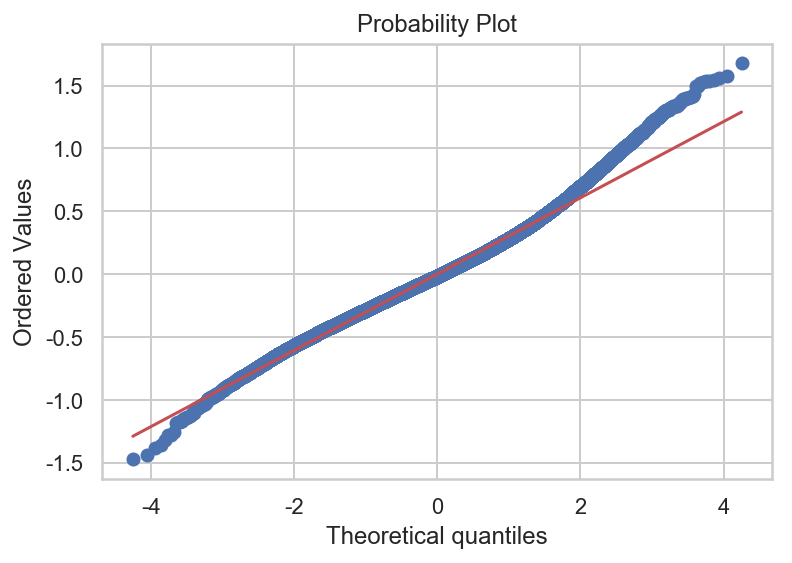

In [179]:
sp.stats.probplot(lm_2_result.resid, plot=plt)
plt.show()

>양쪽 꼬리가 중심선에서 떨어져 있기 때문에 잔차가 정규성을 지니고 있다고 판단하기 어렵습니다.

In [180]:
normaltest(lm_2_result.resid)

NormaltestResult(statistic=3149.967891279617, pvalue=0.0)

>검정 결과, p-value < 0.01로 귀무가설이 기각되어 잔차가 정규성을 가지고 있지 않습니다. 따라서 회귀분석에 사용된 데이터가 회귀분석에 사용된 모형 가정을 제대로 만족하고 있다고 할 수 없습니다.

## Final model: Gradient Boosting Regressor

1. 회귀분석 모델 진단 결과, 데이터가 모델의 가정을 제대로 만족하고 있지 않은 문제
1. 복수의 모델을 결합하는 원리로 단일 모델에 비해 모델의 성능을 더욱 끌어올릴 수 있는 Ensemble model의 강력함

위의 두 가지 사항을 고려하여 최종 모델을 LightGBM 패키지를 활용한 Gradient Boosting Regressor로 선정하였습니다.


In [181]:
selected_features = ['designation', 'points', 'province', 
                     'region_1', 'variety', 'winery', 
                     'vintage', 'review_vect']

In [182]:
lgb_train = lgb.Dataset(encoded_X_train[selected_features], y_train)
lgb_eval = lgb.Dataset(encoded_X_val[selected_features], y_val, reference=lgb_train)

In [183]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'max_depth': 5,
    'num_leaves': 30,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'random_seed': 42
}

In [184]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=930108,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)

# gbm.save_model('./output/gbm.pkl')

[1]	valid_0's rmse: 0.592177
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 0.588773
[3]	valid_0's rmse: 0.585215
[4]	valid_0's rmse: 0.581641
[5]	valid_0's rmse: 0.578263
[6]	valid_0's rmse: 0.574858
[7]	valid_0's rmse: 0.571498
[8]	valid_0's rmse: 0.568302
[9]	valid_0's rmse: 0.565029
[10]	valid_0's rmse: 0.561801
[11]	valid_0's rmse: 0.55852
[12]	valid_0's rmse: 0.555287
[13]	valid_0's rmse: 0.552103
[14]	valid_0's rmse: 0.549054
[15]	valid_0's rmse: 0.546029
[16]	valid_0's rmse: 0.543068
[17]	valid_0's rmse: 0.540116
[18]	valid_0's rmse: 0.537286
[19]	valid_0's rmse: 0.534337
[20]	valid_0's rmse: 0.531504
[21]	valid_0's rmse: 0.528745
[22]	valid_0's rmse: 0.526064
[23]	valid_0's rmse: 0.523252
[24]	valid_0's rmse: 0.52068
[25]	valid_0's rmse: 0.518058
[26]	valid_0's rmse: 0.515476
[27]	valid_0's rmse: 0.51293
[28]	valid_0's rmse: 0.510388
[29]	valid_0's rmse: 0.507864
[30]	valid_0's rmse: 0.505421
[31]	valid_0's rmse: 0.503035
[32]	valid_0's rmse:

[281]	valid_0's rmse: 0.322889
[282]	valid_0's rmse: 0.322766
[283]	valid_0's rmse: 0.322645
[284]	valid_0's rmse: 0.322526
[285]	valid_0's rmse: 0.322409
[286]	valid_0's rmse: 0.322324
[287]	valid_0's rmse: 0.322189
[288]	valid_0's rmse: 0.322111
[289]	valid_0's rmse: 0.322015
[290]	valid_0's rmse: 0.321874
[291]	valid_0's rmse: 0.321766
[292]	valid_0's rmse: 0.321648
[293]	valid_0's rmse: 0.321555
[294]	valid_0's rmse: 0.32146
[295]	valid_0's rmse: 0.321359
[296]	valid_0's rmse: 0.321249
[297]	valid_0's rmse: 0.321152
[298]	valid_0's rmse: 0.321079
[299]	valid_0's rmse: 0.321012
[300]	valid_0's rmse: 0.320914
[301]	valid_0's rmse: 0.3208
[302]	valid_0's rmse: 0.320685
[303]	valid_0's rmse: 0.320565
[304]	valid_0's rmse: 0.32046
[305]	valid_0's rmse: 0.320369
[306]	valid_0's rmse: 0.320293
[307]	valid_0's rmse: 0.320217
[308]	valid_0's rmse: 0.32014
[309]	valid_0's rmse: 0.320065
[310]	valid_0's rmse: 0.319966
[311]	valid_0's rmse: 0.319866
[312]	valid_0's rmse: 0.319767
[313]	valid_0

[605]	valid_0's rmse: 0.309729
[606]	valid_0's rmse: 0.309706
[607]	valid_0's rmse: 0.309686
[608]	valid_0's rmse: 0.309669
[609]	valid_0's rmse: 0.309653
[610]	valid_0's rmse: 0.309635
[611]	valid_0's rmse: 0.309621
[612]	valid_0's rmse: 0.309615
[613]	valid_0's rmse: 0.309603
[614]	valid_0's rmse: 0.309593
[615]	valid_0's rmse: 0.309581
[616]	valid_0's rmse: 0.30957
[617]	valid_0's rmse: 0.309551
[618]	valid_0's rmse: 0.309533
[619]	valid_0's rmse: 0.309526
[620]	valid_0's rmse: 0.309515
[621]	valid_0's rmse: 0.309507
[622]	valid_0's rmse: 0.309497
[623]	valid_0's rmse: 0.309494
[624]	valid_0's rmse: 0.309489
[625]	valid_0's rmse: 0.309482
[626]	valid_0's rmse: 0.309473
[627]	valid_0's rmse: 0.309465
[628]	valid_0's rmse: 0.309457
[629]	valid_0's rmse: 0.309444
[630]	valid_0's rmse: 0.309436
[631]	valid_0's rmse: 0.309426
[632]	valid_0's rmse: 0.309416
[633]	valid_0's rmse: 0.309385
[634]	valid_0's rmse: 0.309377
[635]	valid_0's rmse: 0.309357
[636]	valid_0's rmse: 0.309342
[637]	val

[890]	valid_0's rmse: 0.306989
[891]	valid_0's rmse: 0.306968
[892]	valid_0's rmse: 0.306959
[893]	valid_0's rmse: 0.306934
[894]	valid_0's rmse: 0.30693
[895]	valid_0's rmse: 0.306907
[896]	valid_0's rmse: 0.306902
[897]	valid_0's rmse: 0.306895
[898]	valid_0's rmse: 0.306891
[899]	valid_0's rmse: 0.306883
[900]	valid_0's rmse: 0.306876
[901]	valid_0's rmse: 0.306855
[902]	valid_0's rmse: 0.306835
[903]	valid_0's rmse: 0.306819
[904]	valid_0's rmse: 0.306804
[905]	valid_0's rmse: 0.306785
[906]	valid_0's rmse: 0.306782
[907]	valid_0's rmse: 0.306774
[908]	valid_0's rmse: 0.306769
[909]	valid_0's rmse: 0.306761
[910]	valid_0's rmse: 0.306756
[911]	valid_0's rmse: 0.306738
[912]	valid_0's rmse: 0.306723
[913]	valid_0's rmse: 0.306709
[914]	valid_0's rmse: 0.306692
[915]	valid_0's rmse: 0.306675
[916]	valid_0's rmse: 0.306669
[917]	valid_0's rmse: 0.306664
[918]	valid_0's rmse: 0.306661
[919]	valid_0's rmse: 0.306652
[920]	valid_0's rmse: 0.306646
[921]	valid_0's rmse: 0.306635
[922]	val

[1260]	valid_0's rmse: 0.303713
[1261]	valid_0's rmse: 0.303712
[1262]	valid_0's rmse: 0.303711
[1263]	valid_0's rmse: 0.303704
[1264]	valid_0's rmse: 0.303702
[1265]	valid_0's rmse: 0.303701
[1266]	valid_0's rmse: 0.303694
[1267]	valid_0's rmse: 0.303684
[1268]	valid_0's rmse: 0.303673
[1269]	valid_0's rmse: 0.303667
[1270]	valid_0's rmse: 0.303658
[1271]	valid_0's rmse: 0.303652
[1272]	valid_0's rmse: 0.303651
[1273]	valid_0's rmse: 0.303646
[1274]	valid_0's rmse: 0.30364
[1275]	valid_0's rmse: 0.303635
[1276]	valid_0's rmse: 0.303634
[1277]	valid_0's rmse: 0.303632
[1278]	valid_0's rmse: 0.303632
[1279]	valid_0's rmse: 0.303631
[1280]	valid_0's rmse: 0.303629
[1281]	valid_0's rmse: 0.303612
[1282]	valid_0's rmse: 0.303595
[1283]	valid_0's rmse: 0.303579
[1284]	valid_0's rmse: 0.303562
[1285]	valid_0's rmse: 0.303546
[1286]	valid_0's rmse: 0.303544
[1287]	valid_0's rmse: 0.303542
[1288]	valid_0's rmse: 0.30354
[1289]	valid_0's rmse: 0.30354
[1290]	valid_0's rmse: 0.303537
[1291]	vali

[1552]	valid_0's rmse: 0.301851
[1553]	valid_0's rmse: 0.301846
[1554]	valid_0's rmse: 0.301842
[1555]	valid_0's rmse: 0.301838
[1556]	valid_0's rmse: 0.301831
[1557]	valid_0's rmse: 0.301826
[1558]	valid_0's rmse: 0.301825
[1559]	valid_0's rmse: 0.30182
[1560]	valid_0's rmse: 0.301814
[1561]	valid_0's rmse: 0.301809
[1562]	valid_0's rmse: 0.301807
[1563]	valid_0's rmse: 0.301803
[1564]	valid_0's rmse: 0.30179
[1565]	valid_0's rmse: 0.301785
[1566]	valid_0's rmse: 0.301782
[1567]	valid_0's rmse: 0.301779
[1568]	valid_0's rmse: 0.301777
[1569]	valid_0's rmse: 0.301775
[1570]	valid_0's rmse: 0.301774
[1571]	valid_0's rmse: 0.301774
[1572]	valid_0's rmse: 0.301768
[1573]	valid_0's rmse: 0.301768
[1574]	valid_0's rmse: 0.301762
[1575]	valid_0's rmse: 0.301754
[1576]	valid_0's rmse: 0.30175
[1577]	valid_0's rmse: 0.301746
[1578]	valid_0's rmse: 0.301741
[1579]	valid_0's rmse: 0.301737
[1580]	valid_0's rmse: 0.301734
[1581]	valid_0's rmse: 0.301733
[1582]	valid_0's rmse: 0.301731
[1583]	vali

[1901]	valid_0's rmse: 0.300091
[1902]	valid_0's rmse: 0.300082
[1903]	valid_0's rmse: 0.300068
[1904]	valid_0's rmse: 0.30006
[1905]	valid_0's rmse: 0.300051
[1906]	valid_0's rmse: 0.300039
[1907]	valid_0's rmse: 0.300026
[1908]	valid_0's rmse: 0.300014
[1909]	valid_0's rmse: 0.300002
[1910]	valid_0's rmse: 0.29999
[1911]	valid_0's rmse: 0.299988
[1912]	valid_0's rmse: 0.299987
[1913]	valid_0's rmse: 0.299983
[1914]	valid_0's rmse: 0.299981
[1915]	valid_0's rmse: 0.299979
[1916]	valid_0's rmse: 0.299978
[1917]	valid_0's rmse: 0.299974
[1918]	valid_0's rmse: 0.299974
[1919]	valid_0's rmse: 0.299969
[1920]	valid_0's rmse: 0.299967
[1921]	valid_0's rmse: 0.299966
[1922]	valid_0's rmse: 0.299962
[1923]	valid_0's rmse: 0.299959
[1924]	valid_0's rmse: 0.299955
[1925]	valid_0's rmse: 0.299955
[1926]	valid_0's rmse: 0.299947
[1927]	valid_0's rmse: 0.29994
[1928]	valid_0's rmse: 0.299932
[1929]	valid_0's rmse: 0.299926
[1930]	valid_0's rmse: 0.299921
[1931]	valid_0's rmse: 0.299921
[1932]	vali

[2217]	valid_0's rmse: 0.298853
[2218]	valid_0's rmse: 0.298851
[2219]	valid_0's rmse: 0.29885
[2220]	valid_0's rmse: 0.298849
[2221]	valid_0's rmse: 0.298841
[2222]	valid_0's rmse: 0.298833
[2223]	valid_0's rmse: 0.298825
[2224]	valid_0's rmse: 0.298822
[2225]	valid_0's rmse: 0.298814
[2226]	valid_0's rmse: 0.298811
[2227]	valid_0's rmse: 0.298809
[2228]	valid_0's rmse: 0.298807
[2229]	valid_0's rmse: 0.298799
[2230]	valid_0's rmse: 0.298792
[2231]	valid_0's rmse: 0.298788
[2232]	valid_0's rmse: 0.298786
[2233]	valid_0's rmse: 0.298782
[2234]	valid_0's rmse: 0.298772
[2235]	valid_0's rmse: 0.298769
[2236]	valid_0's rmse: 0.298766
[2237]	valid_0's rmse: 0.298763
[2238]	valid_0's rmse: 0.29876
[2239]	valid_0's rmse: 0.298756
[2240]	valid_0's rmse: 0.298754
[2241]	valid_0's rmse: 0.298749
[2242]	valid_0's rmse: 0.298746
[2243]	valid_0's rmse: 0.298743
[2244]	valid_0's rmse: 0.29874
[2245]	valid_0's rmse: 0.298737
[2246]	valid_0's rmse: 0.298735
[2247]	valid_0's rmse: 0.298734
[2248]	vali

[2572]	valid_0's rmse: 0.297586
[2573]	valid_0's rmse: 0.297583
[2574]	valid_0's rmse: 0.29758
[2575]	valid_0's rmse: 0.297577
[2576]	valid_0's rmse: 0.297571
[2577]	valid_0's rmse: 0.29757
[2578]	valid_0's rmse: 0.297563
[2579]	valid_0's rmse: 0.297553
[2580]	valid_0's rmse: 0.297544
[2581]	valid_0's rmse: 0.297544
[2582]	valid_0's rmse: 0.297543
[2583]	valid_0's rmse: 0.297543
[2584]	valid_0's rmse: 0.297543
[2585]	valid_0's rmse: 0.297539
[2586]	valid_0's rmse: 0.297539
[2587]	valid_0's rmse: 0.297538
[2588]	valid_0's rmse: 0.297529
[2589]	valid_0's rmse: 0.297527
[2590]	valid_0's rmse: 0.297519
[2591]	valid_0's rmse: 0.297516
[2592]	valid_0's rmse: 0.297516
[2593]	valid_0's rmse: 0.297515
[2594]	valid_0's rmse: 0.297515
[2595]	valid_0's rmse: 0.297514
[2596]	valid_0's rmse: 0.297508
[2597]	valid_0's rmse: 0.297502
[2598]	valid_0's rmse: 0.297501
[2599]	valid_0's rmse: 0.297496
[2600]	valid_0's rmse: 0.297496
[2601]	valid_0's rmse: 0.297491
[2602]	valid_0's rmse: 0.297487
[2603]	val

[2865]	valid_0's rmse: 0.296798
[2866]	valid_0's rmse: 0.296796
[2867]	valid_0's rmse: 0.296791
[2868]	valid_0's rmse: 0.296791
[2869]	valid_0's rmse: 0.296789
[2870]	valid_0's rmse: 0.296788
[2871]	valid_0's rmse: 0.296785
[2872]	valid_0's rmse: 0.296784
[2873]	valid_0's rmse: 0.296783
[2874]	valid_0's rmse: 0.296783
[2875]	valid_0's rmse: 0.296782
[2876]	valid_0's rmse: 0.29678
[2877]	valid_0's rmse: 0.296779
[2878]	valid_0's rmse: 0.296774
[2879]	valid_0's rmse: 0.296772
[2880]	valid_0's rmse: 0.296771
[2881]	valid_0's rmse: 0.296767
[2882]	valid_0's rmse: 0.296764
[2883]	valid_0's rmse: 0.296765
[2884]	valid_0's rmse: 0.296762
[2885]	valid_0's rmse: 0.296758
[2886]	valid_0's rmse: 0.296755
[2887]	valid_0's rmse: 0.296754
[2888]	valid_0's rmse: 0.29675
[2889]	valid_0's rmse: 0.296746
[2890]	valid_0's rmse: 0.296743
[2891]	valid_0's rmse: 0.296738
[2892]	valid_0's rmse: 0.296736
[2893]	valid_0's rmse: 0.296731
[2894]	valid_0's rmse: 0.296729
[2895]	valid_0's rmse: 0.296725
[2896]	val

[3180]	valid_0's rmse: 0.296033
[3181]	valid_0's rmse: 0.296028
[3182]	valid_0's rmse: 0.296023
[3183]	valid_0's rmse: 0.296017
[3184]	valid_0's rmse: 0.296012
[3185]	valid_0's rmse: 0.296008
[3186]	valid_0's rmse: 0.296008
[3187]	valid_0's rmse: 0.296003
[3188]	valid_0's rmse: 0.296002
[3189]	valid_0's rmse: 0.296001
[3190]	valid_0's rmse: 0.296
[3191]	valid_0's rmse: 0.295995
[3192]	valid_0's rmse: 0.295989
[3193]	valid_0's rmse: 0.295985
[3194]	valid_0's rmse: 0.29598
[3195]	valid_0's rmse: 0.295978
[3196]	valid_0's rmse: 0.29597
[3197]	valid_0's rmse: 0.295967
[3198]	valid_0's rmse: 0.295964
[3199]	valid_0's rmse: 0.295961
[3200]	valid_0's rmse: 0.295958
[3201]	valid_0's rmse: 0.295954
[3202]	valid_0's rmse: 0.295952
[3203]	valid_0's rmse: 0.29595
[3204]	valid_0's rmse: 0.295948
[3205]	valid_0's rmse: 0.295947
[3206]	valid_0's rmse: 0.295944
[3207]	valid_0's rmse: 0.295944
[3208]	valid_0's rmse: 0.295942
[3209]	valid_0's rmse: 0.295942
[3210]	valid_0's rmse: 0.29594
[3211]	valid_0'

[3439]	valid_0's rmse: 0.295449
[3440]	valid_0's rmse: 0.295448
[3441]	valid_0's rmse: 0.295444
[3442]	valid_0's rmse: 0.295438
[3443]	valid_0's rmse: 0.295435
[3444]	valid_0's rmse: 0.295431
[3445]	valid_0's rmse: 0.295429
[3446]	valid_0's rmse: 0.295425
[3447]	valid_0's rmse: 0.295422
[3448]	valid_0's rmse: 0.29542
[3449]	valid_0's rmse: 0.295416
[3450]	valid_0's rmse: 0.295415
[3451]	valid_0's rmse: 0.295414
[3452]	valid_0's rmse: 0.295411
[3453]	valid_0's rmse: 0.295411
[3454]	valid_0's rmse: 0.295409
[3455]	valid_0's rmse: 0.295408
[3456]	valid_0's rmse: 0.295404
[3457]	valid_0's rmse: 0.295401
[3458]	valid_0's rmse: 0.295397
[3459]	valid_0's rmse: 0.295391
[3460]	valid_0's rmse: 0.295386
[3461]	valid_0's rmse: 0.295382
[3462]	valid_0's rmse: 0.295379
[3463]	valid_0's rmse: 0.295376
[3464]	valid_0's rmse: 0.295375
[3465]	valid_0's rmse: 0.295373
[3466]	valid_0's rmse: 0.295368
[3467]	valid_0's rmse: 0.295369
[3468]	valid_0's rmse: 0.295366
[3469]	valid_0's rmse: 0.295362
[3470]	va

[3711]	valid_0's rmse: 0.294819
[3712]	valid_0's rmse: 0.294819
[3713]	valid_0's rmse: 0.294818
[3714]	valid_0's rmse: 0.294818
[3715]	valid_0's rmse: 0.294817
[3716]	valid_0's rmse: 0.294815
[3717]	valid_0's rmse: 0.294814
[3718]	valid_0's rmse: 0.294813
[3719]	valid_0's rmse: 0.294811
[3720]	valid_0's rmse: 0.29481
[3721]	valid_0's rmse: 0.294805
[3722]	valid_0's rmse: 0.294801
[3723]	valid_0's rmse: 0.294796
[3724]	valid_0's rmse: 0.294793
[3725]	valid_0's rmse: 0.294791
[3726]	valid_0's rmse: 0.29479
[3727]	valid_0's rmse: 0.294789
[3728]	valid_0's rmse: 0.294785
[3729]	valid_0's rmse: 0.294784
[3730]	valid_0's rmse: 0.294781
[3731]	valid_0's rmse: 0.29478
[3732]	valid_0's rmse: 0.294778
[3733]	valid_0's rmse: 0.294775
[3734]	valid_0's rmse: 0.294771
[3735]	valid_0's rmse: 0.294768
[3736]	valid_0's rmse: 0.294766
[3737]	valid_0's rmse: 0.294766
[3738]	valid_0's rmse: 0.294763
[3739]	valid_0's rmse: 0.294763
[3740]	valid_0's rmse: 0.294763
[3741]	valid_0's rmse: 0.294761
[3742]	vali

In [185]:
y_pred = gbm.predict(encoded_X_val[selected_features], num_iteration=gbm.best_iteration)
print('The rmse of val set:', np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_pred))))

The rmse of val set: 11.11970672441562


In [186]:
y_pred = gbm.predict(encoded_X_test[selected_features], num_iteration=gbm.best_iteration)
print('The rmse of test set:', np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred))))

The rmse of test set: 11.177115163763576


### Feature importance
Boosting model의 feature importance는 tree에서 어떠한 변수를 사용한 노드가 모델의 엔트로피를 낮추는데 공헌하는지(=information gain을 높이는지)를 기준으로 중요도를 계산합니다.

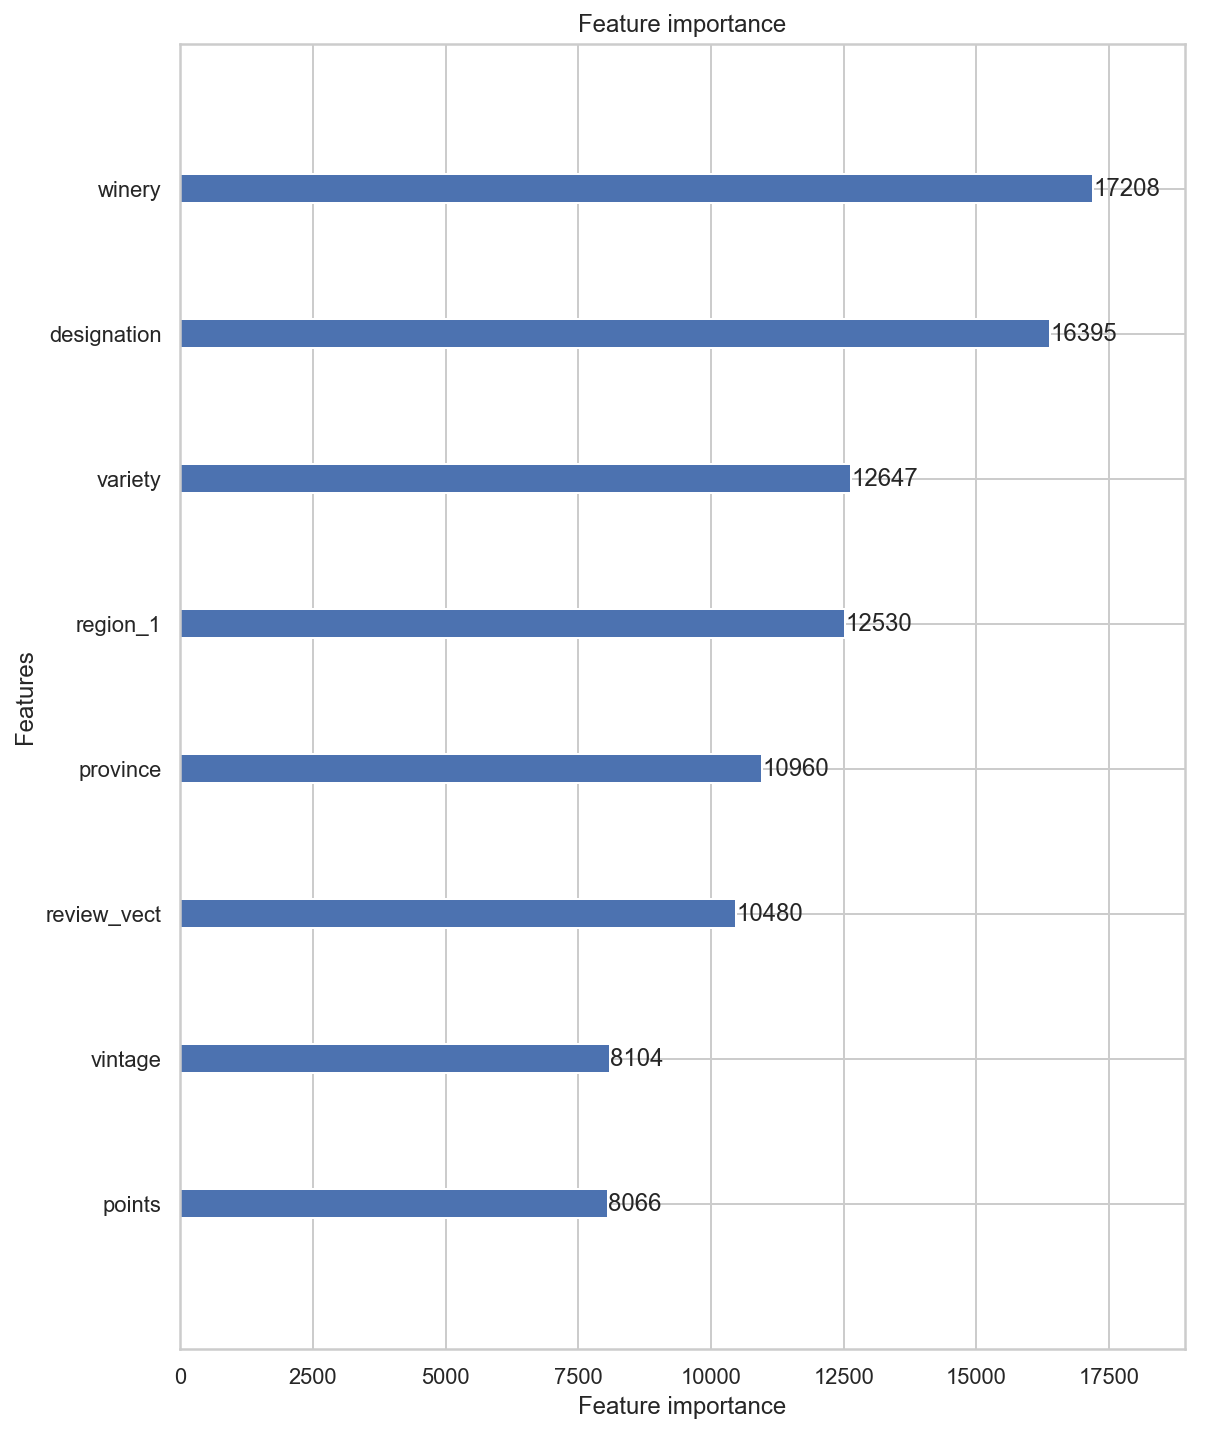

In [188]:
lgb.plot_importance(gbm, importance_type='split', figsize=(9, 12))

---

### 참고) Target encoding dataset의 feature 간 상관관계 및 `price`와의 분포

#### Scaling

In [189]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = ['province', 'designation', 'region_1', 'variety', 'winery', 'vintage', 'review_vect']
train_analysis = pd.DataFrame(scaler.fit_transform(encoded_train[scaled_features]), columns=scaled_features)
train_analysis = pd.concat([train_analysis, encoded_train[['points', 'price']]], axis=1)

#### Correlation

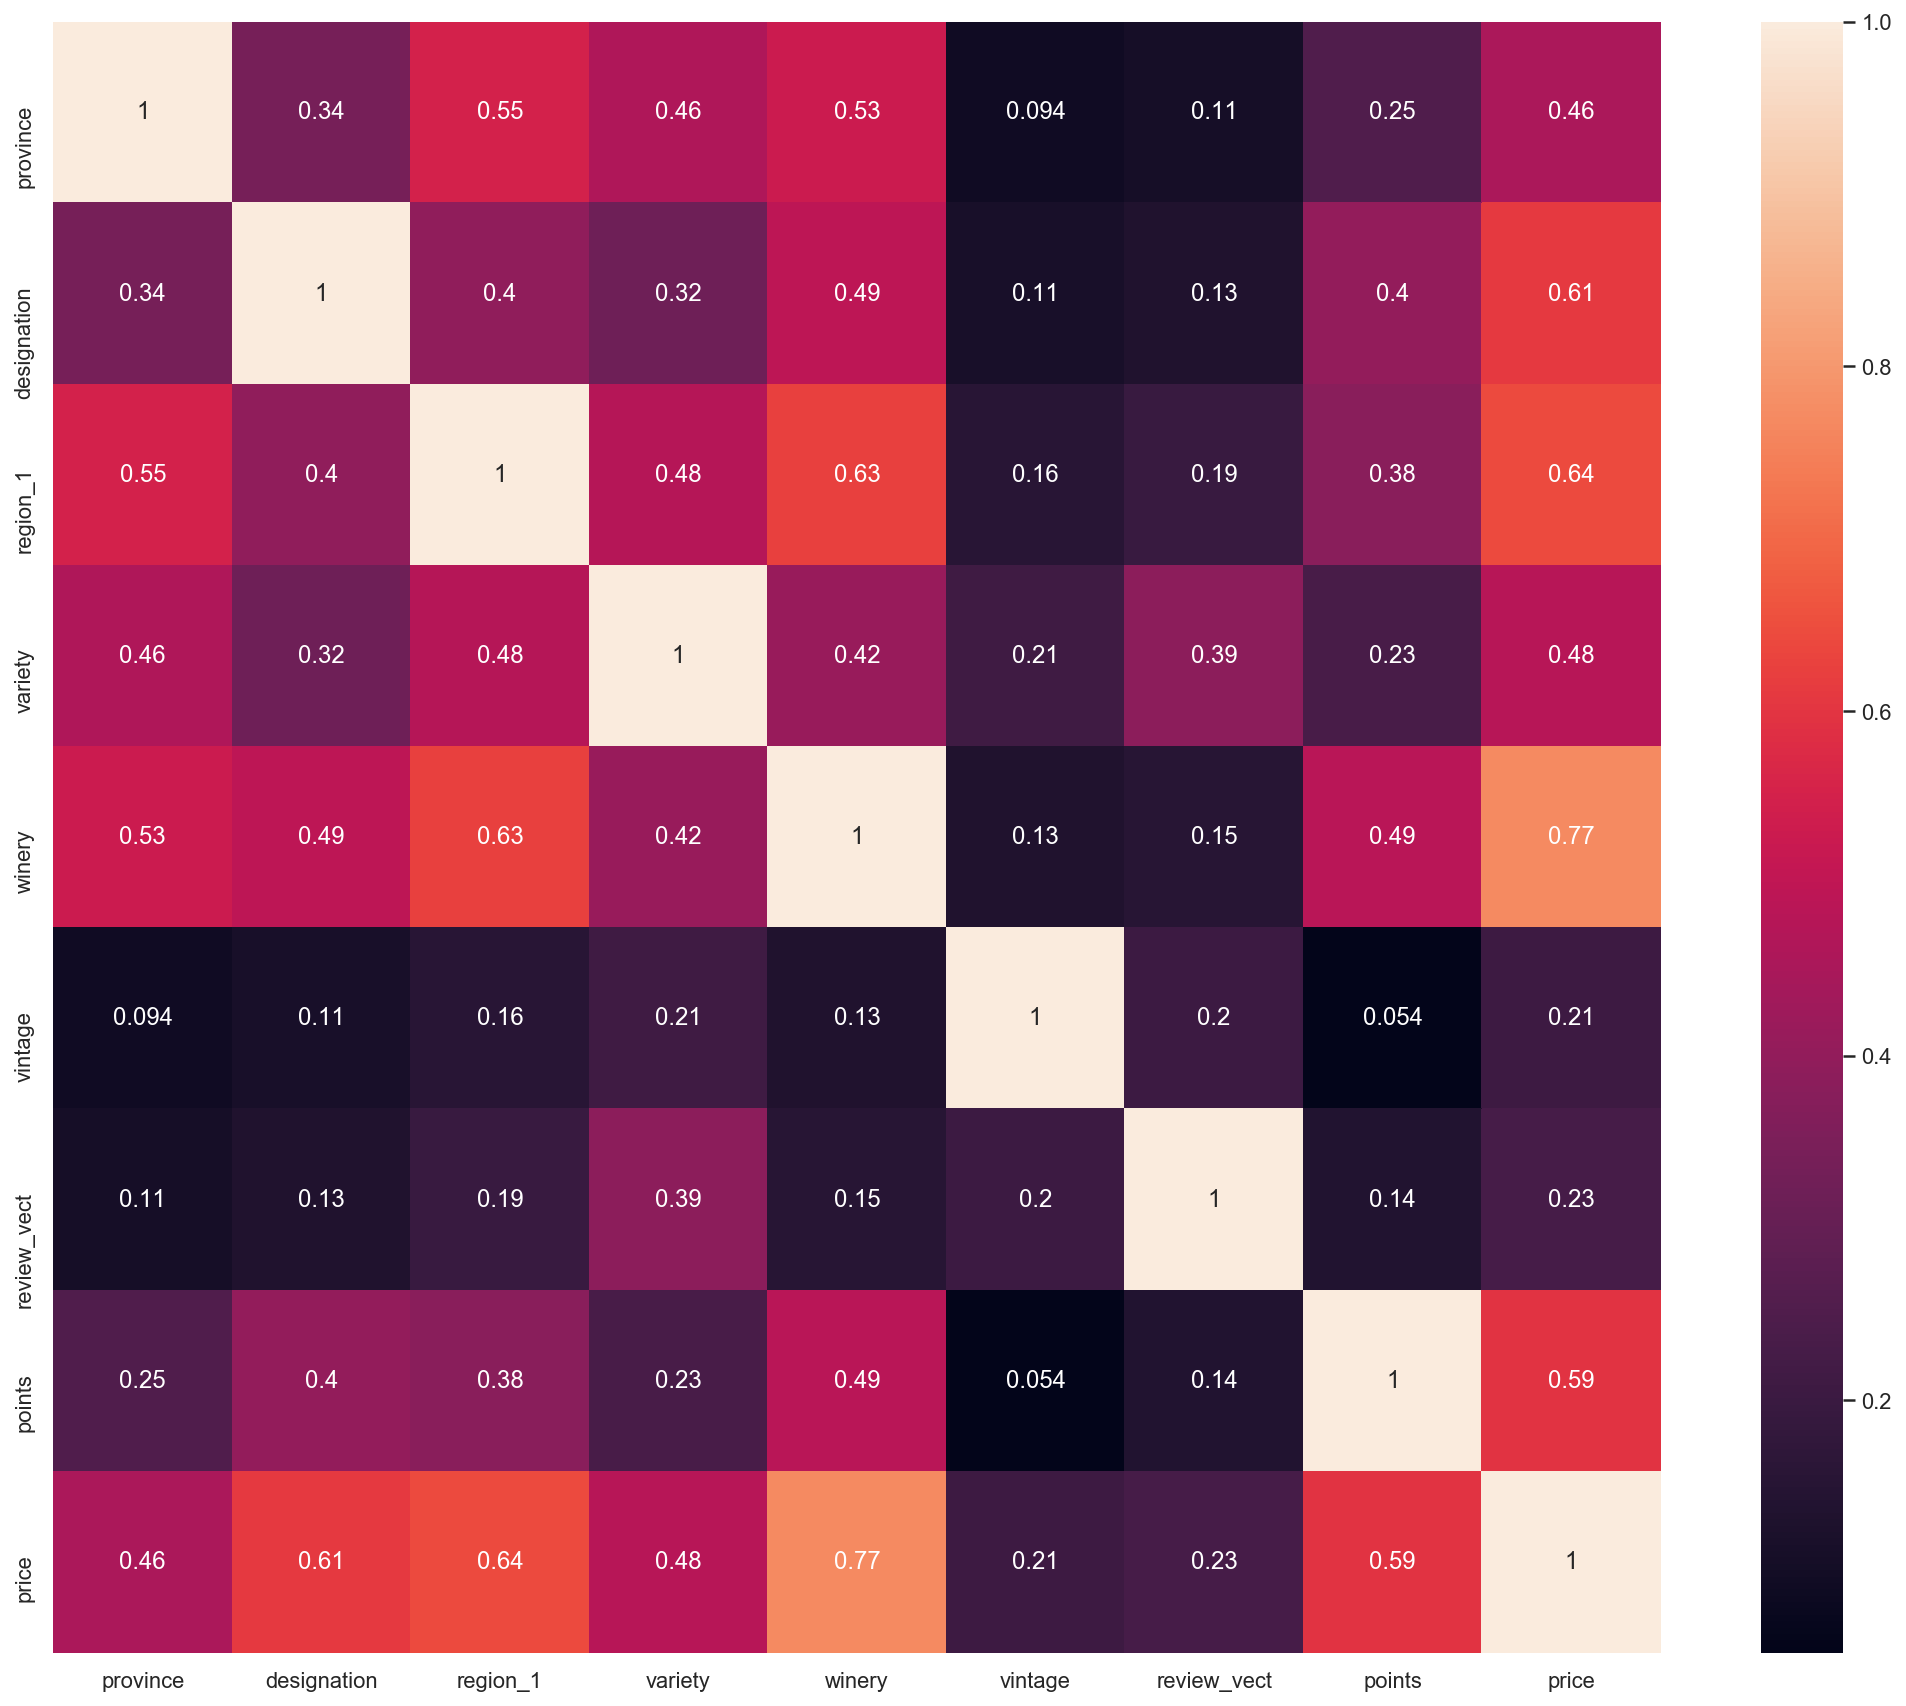

In [190]:
corrmat = train_analysis.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(18,15))
#plot heat map
g=sns.heatmap(train_analysis[top_corr_features].corr(), annot=True)

#### feature와 `price`의 분포

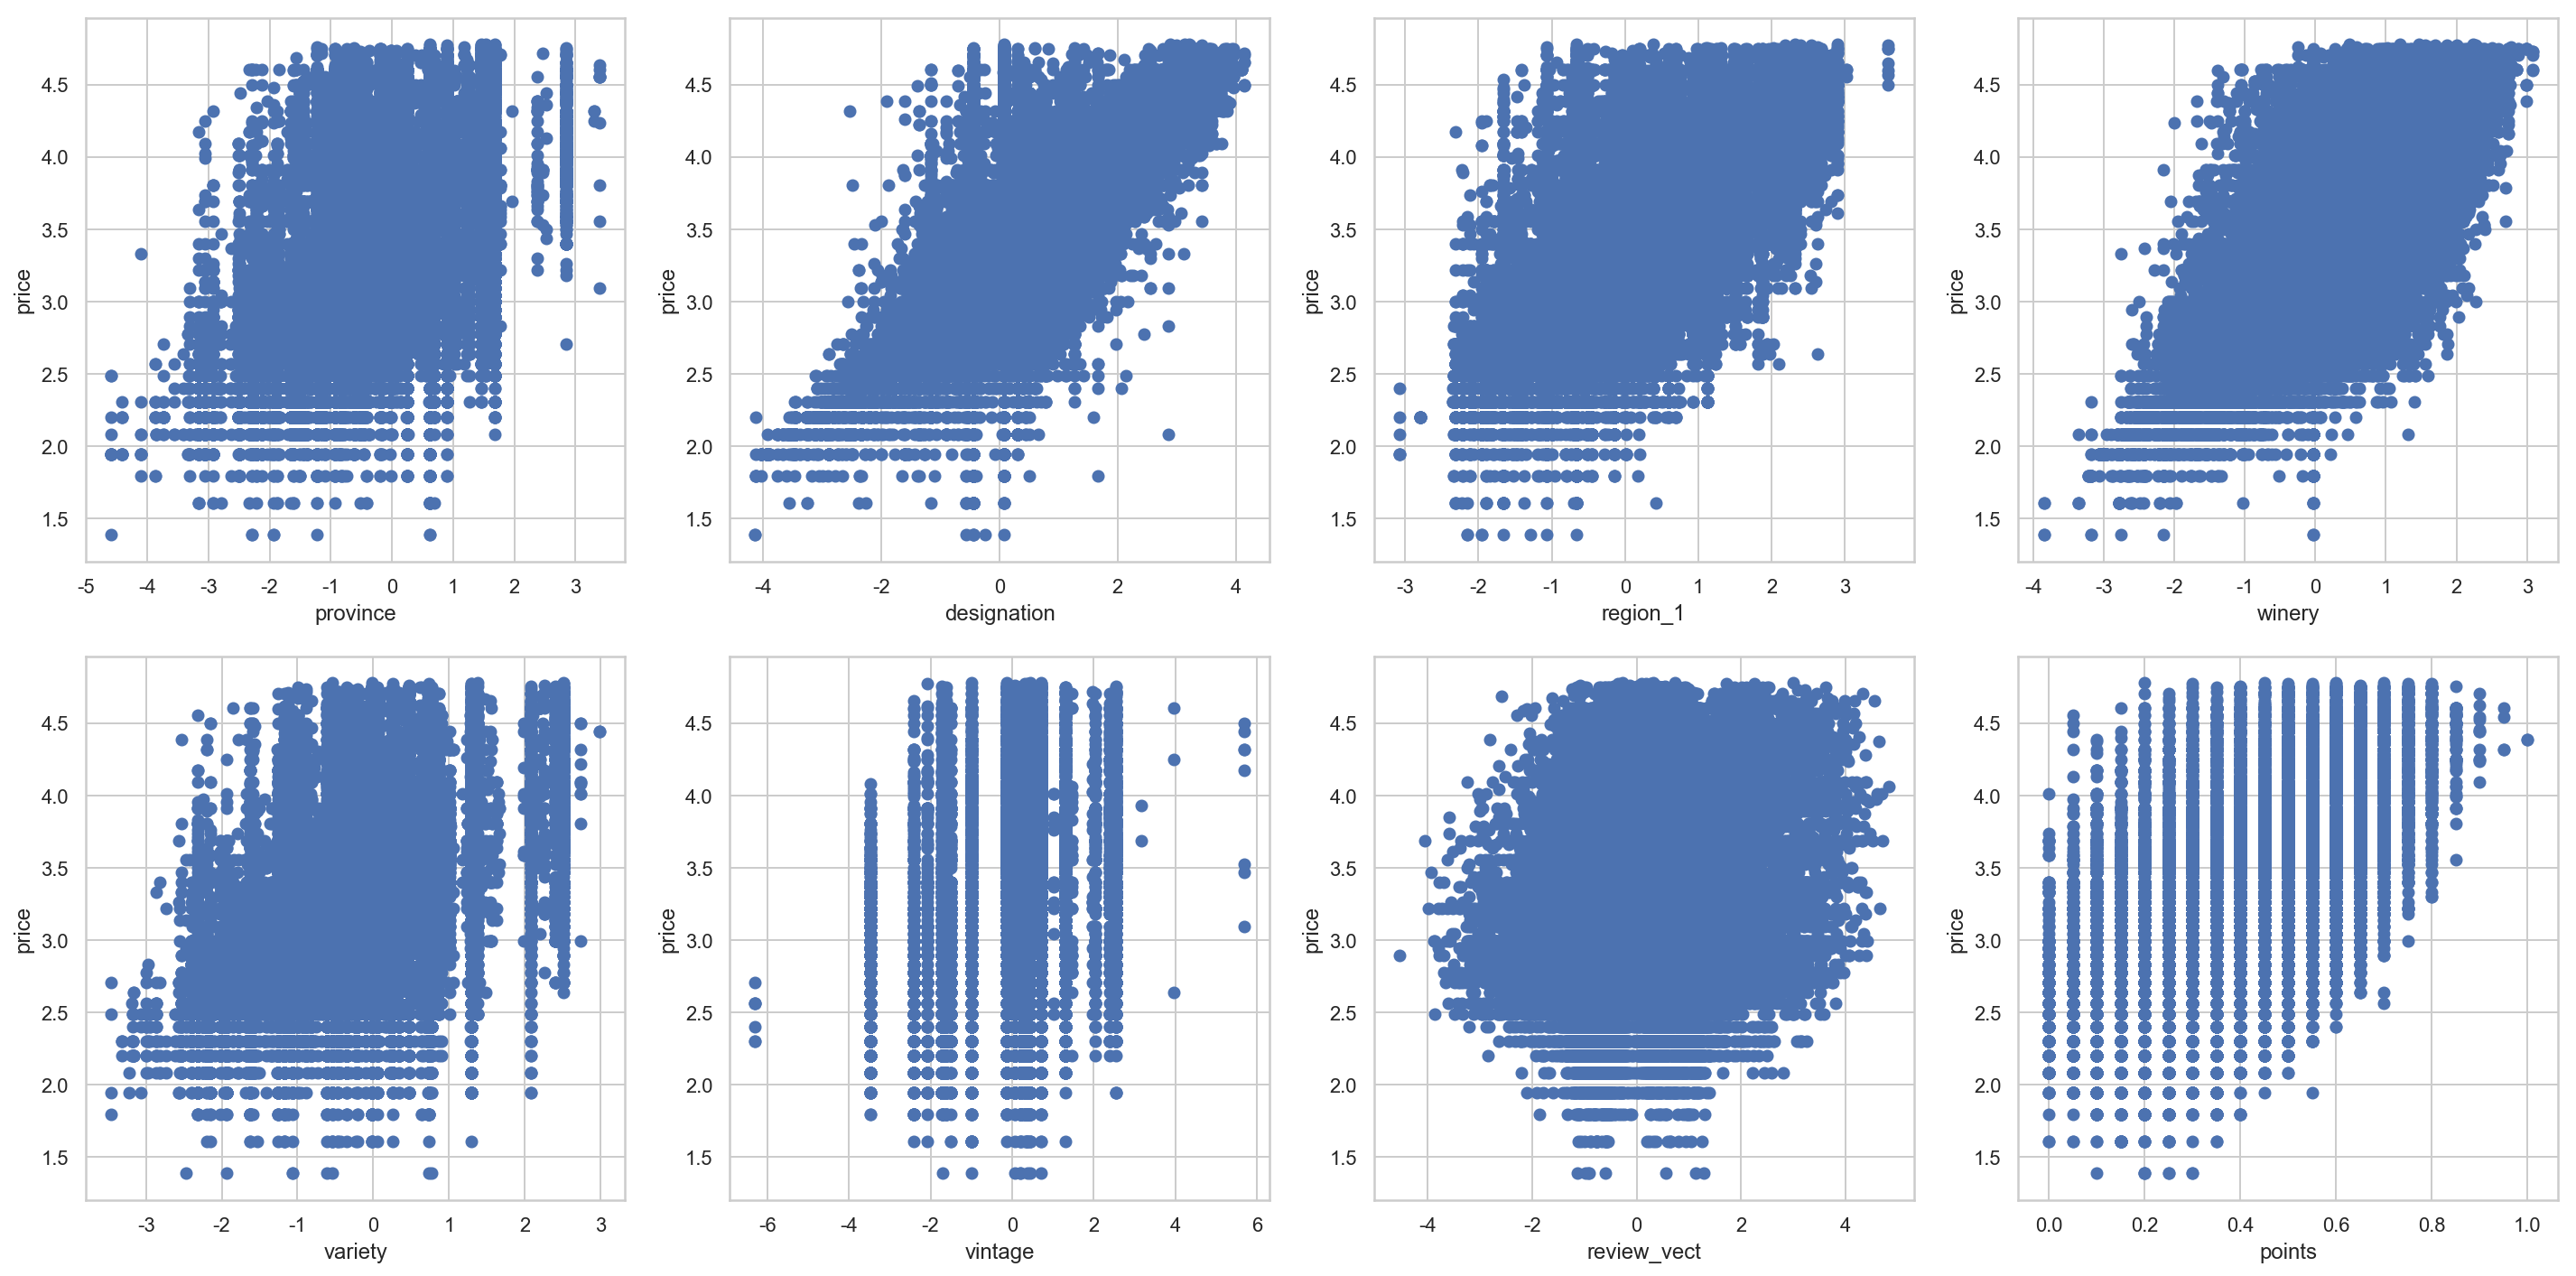

In [191]:
plt.figure(figsize=(20, 10))

plt.subplot(241)
plt.scatter(train_analysis['province'], train_analysis['price'])
plt.ylabel('price')
plt.xlabel('province')


plt.subplot(242)
plt.scatter(train_analysis['designation'], train_analysis['price'])
plt.ylabel('price')
plt.xlabel('designation')


plt.subplot(243)
plt.scatter(train_analysis['region_1'], train_analysis['price'])
plt.ylabel('price')
plt.xlabel('region_1')


plt.subplot(244)
plt.scatter(train_analysis['winery'], train_analysis['price'])
plt.ylabel('price')
plt.xlabel('winery')


plt.subplot(245)
plt.scatter(train_analysis['variety'], train_analysis['price'])
plt.ylabel('price')
plt.xlabel('variety')


plt.subplot(246)
plt.scatter(train_analysis['vintage'], train_analysis['price'])
plt.ylabel('price')
plt.xlabel('vintage')


plt.subplot(247)
plt.scatter(train_analysis['review_vect'], train_analysis['price'])
plt.ylabel('price')
plt.xlabel('review_vect')


plt.subplot(248)
plt.scatter(train_analysis['points'], train_analysis['price'])
plt.ylabel('price')
plt.xlabel('points')


plt.tight_layout()
plt.show()

---